$
\def\D{\Omega}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{ {\vec d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \obsop u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{{\vec{x}}_1, \ldots, {\vec{x}}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The parameter-to-observable map $\iFF \,\ipar := \obsop\, u(\ipar)$ maps an initial condition $\ipar \in L^2(\D)$ to pointwise spatiotemporal observations of the concentration field $u({\vec x},t)$ through solution of the advection-diffusion equation given by

$$
\begin{split}
u_t - \kappa\Delta u + {\vec v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot {\vec{n}} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\D \subset \R^d$ ($d \in \{2, 3\}$) is a bounded domain, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta {\vec v} + \nabla q + {\vec v} \cdot \nabla {\vec v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot {\vec v} &= 0 &&\text{ in }\D,\\
{\vec v} &= {\vec g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
${\vec g} \in \R^d$ is given by 
${\vec g} = {\vec e}_2$ on the left wall of the domain, 
${\vec g}=-{\vec e}_2$ on the right wall,  and ${\vec g} = {\vec 0}$ everywhere else.

### The adjoint problem:

The adjoint problem is a final value problem, since $p$ is specified at $t = T$ rather than at $t = 0$. Thus, it is solved backwards in time, which amounts to the solution of the advection-diffusion equation

$$
\begin{aligned}
-p_t - \nabla \cdot (p {\vec v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
({ \vec{v} }p+\kappa\nabla p)\cdot {\vec{n}}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

Then, the adjoint of the parameter to observable map $\iFF^*$ is defined by setting $\iFF^*\obs = p({\vec x}, 0).$

## 1. Load modules

In [1]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *
sys.path.append( "/home/nick/repos/hippylib/applications/ad_diff" )

# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD, SpaceTimePointwiseStateObservation

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

from scipy.spatial import KDTree
import scipy.sparse.linalg as spla
import scipy.linalg as sla
from localpsf.bilaplacian_regularization import BiLaplacianRegularization
from localpsf.morozov_discrepancy import compute_morozov_regularization_parameter
import nalger_helper_functions as nhf

import hlibpro_python_wrapper as hpro
from localpsf.product_convolution_kernel import ProductConvolutionKernel
from localpsf.product_convolution_hmatrix import make_hmatrix_from_kernel

# Options

In [2]:
num_refinements = 2
# kappa=5.e-5 # marginally too small
# kappa=1e-3 # standard for hippylib. Quite smoothing
# kappa = 3.e-4 # Good value
# kappa = 1.e-4 # pretty small but still good
# kappa = 2.e-3 # big but good
kappa = 5e-4
# kappa = 1.e-2

t_final        = 0.5 #1.0
dt             = .1 #0.05

gamma = 1.
# delta = 8.
# gamma = 0.25
# gamma = 0.1
# delta = 8.
prior_correlation_length = 0.25

num_checkers_x = 6
num_checkers_y = 6

rel_noise=0.01

# Mesh and finite element spaces

In [3]:
mesh = dl.Mesh("ad_20.xml")
for _ in range(num_refinements):
    mesh = dl.refine( mesh )

Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print( "Number of dofs: {0}".format( Vh.dim() ) )

dof_coords = Vh.tabulate_dof_coordinates()
dof_kdt = KDTree(dof_coords)

find_nearest_dof = lambda p: dof_kdt.query(p)[1]

Number of dofs: 7863


# Velocity field

In [4]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS # original
        

Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
XW = dl.FunctionSpace(mesh, mixed_element)

Re = dl.Constant(1e2)

g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1) # original
bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
bcs = [bc1, bc2]

vq = dl.Function(XW)
(v,q) = ufl.split(vq)
(v_test, q_test) = dl.TestFunctions (XW)

def strain(v):
    return ufl.sym(ufl.grad(v))

F = ( (2./Re)*ufl.inner(strain(v),strain(v_test))+ ufl.inner (ufl.nabla_grad(v)*v, v_test)
       - (q * ufl.div(v_test)) + ( ufl.div(v) * q_test) ) * ufl.dx

dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                     {"relative_tolerance":1e-4, "maximum_iterations":100}})

wind_velocity = v

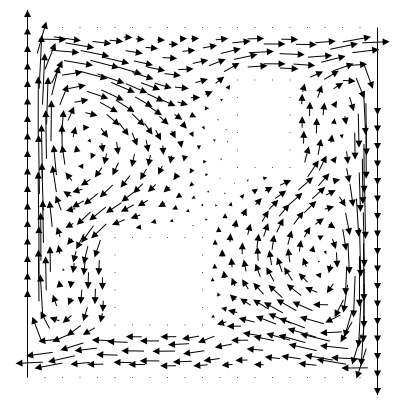

In [5]:
vh = dl.project(v,Xh)
qh = dl.project(q,Wh)

v_plot = nb.coarsen_v(vh)
plot_mesh = v_plot.function_space().mesh()
plt.figure(figsize=(5,5))
w0 = v_plot.compute_vertex_values(plot_mesh)

X = plot_mesh.coordinates()[:, 0]
Y = plot_mesh.coordinates()[:, 1]
U = w0[:plot_mesh.num_vertices()]
V = w0[plot_mesh.num_vertices():]
# C = np.sqrt(U*U+V*V)
C = np.ones(U.shape)
# pivot='middle'
pivot='tail'
plt.quiver(X,Y,U,V, C, units='x', headaxislength=7, headwidth=7, headlength=7, scale=4, pivot=pivot)

plt.axis('off')
plt.set_cmap('gray')
plt.gca().set_aspect('equal')
plt.show()


# Initial condition

In [6]:
class FenicsFunctionSmoother:
    def __init__(me, function_space_V, smoothing_time=1e-2, num_timesteps=10):
        me.function_space_V = function_space_V
        me.num_timesteps = num_timesteps
        me.dt = smoothing_time / num_timesteps

        u = dl.TrialFunction(function_space_V)
        v = dl.TestFunction(function_space_V)

        mass_form = u * v * dl.dx
        stiffness_form = dl.inner(dl.grad(u), dl.grad(v)) * dl.dx

        me.M = dl.assemble(mass_form)
        Z = dl.assemble(mass_form + me.dt * stiffness_form)

        me.Z_solver = dl.LUSolver(Z)

    def smooth(me, function_f):
        for k in range(me.num_timesteps):
            me.Z_solver.solve(function_f.vector(), me.M * function_f.vector())
            
    def random_smooth_function(me):
        f = dl.Function(me.function_space_V)
        f.vector()[:] = np.random.randn(me.function_space_V.dim())
        me.smooth(f)
        return f

In [7]:
def checkerboard_function(nx, ny, Vh, smoothing_time=2e-4):
    xx = list(np.linspace(0.0, 1.0, nx+1))
    yy = list(np.linspace(0.0, 1.0, ny+1))
    sx = ''
    for x in xx[1:-1]:
        sx += '(2*(x[0] > ' + str(x) + ')-1)*'
    sy = ''
    for y in yy[1:-1]:
        sy += '(2*(x[1] > ' + str(y) + ')-1)*'
    s = sx + sy + '0.5 + 0.5'
    checker_expr = dl.Expression(s, element=Vh.ufl_element())

    checker_func = dl.interpolate(checker_expr, Vh)
    Vh_smoother = FenicsFunctionSmoother(Vh, smoothing_time=smoothing_time)
    Vh_smoother.smooth(checker_func)
    return checker_func

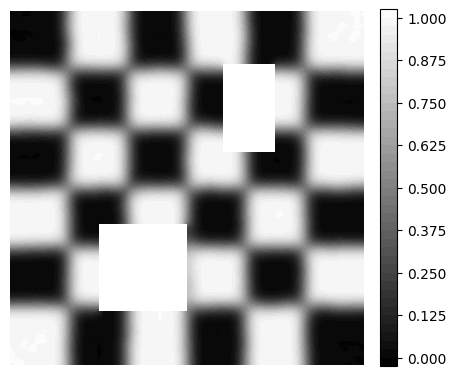

In [8]:
ic_func = checkerboard_function(num_checkers_x, num_checkers_y, Vh)
true_initial_condition = ic_func.vector()

utrue_initial = dl.Function(Vh)
utrue_initial.vector()[:] = true_initial_condition

cmap = 'gray' #'binary_r' #'gist_gray' #'binary' # 'afmhot'

plt.figure(figsize=(5,5))
cm = dl.plot(utrue_initial, cmap=cmap)
plt.axis('off')
plt.colorbar(cm,fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.show()

# Prior

In [9]:
prior_mean_func = dl.interpolate(dl.Constant(0.25), Vh)

# Mass matrix

In [10]:
M_petsc = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M_petsc)

M_scipy = nhf.csr_fenics2scipy(M_petsc)

def apply_M_numpy(x_numpy):
    return M_scipy @ x_numpy

def solve_M_numpy(x_numpy):
    x_petsc = dl.Function(Vh).vector()
    x_petsc[:] = x_numpy
    y_petsc = dl.Function(Vh).vector()
    M_solver.solve(y_petsc, x_petsc)
    return y_petsc[:]

mass_lumps = apply_M_numpy(np.ones(Vh.dim()))

apply_ML_numpy = lambda x: x * mass_lumps
solve_ML_numpy = lambda x: x / mass_lumps

# Forward problem and misfit

In [11]:
dt = 0.1
t_init = 0.
obs_coords = Vh.tabulate_dof_coordinates() # observe everywhere
print ("Number of observation points: {0}".format(obs_coords.shape[0]) )

class AdvectionDiffusionProblem:
    def __init__(me, kappa, t_final, gamma):
        print('AdvectionDiffusionMisfitStuff: kappa=', kappa, ', t_final=', t_final)
        me.kappa = kappa
        me.t_final = t_final
        me._gamma = gamma
        
        me.REG = BiLaplacianRegularization(me._gamma, prior_correlation_length, 
                                           dl.Function(Vh), prior_mean_func)
    
        me.simulation_times = np.arange(t_init, me.t_final+.5*dt, dt)
        me.observation_times = np.array([me.t_final])

        me.misfit = SpaceTimePointwiseStateObservation(Vh, 
                                                       me.observation_times, 
                                                       obs_coords)

        fake_gamma = 1.0
        fake_delta = 1.0

        fake_prior = BiLaplacianPrior(Vh, fake_gamma, fake_delta, robin_bc=True)
        
        me.problem = TimeDependentAD(mesh, [Vh,Vh,Vh], fake_prior, 
                                     me.misfit, me.simulation_times, 
                                     wind_velocity, True, kappa=me.kappa)
        
        me.utrue = me.problem.generate_vector(STATE)
        x = [me.utrue, true_initial_condition, None]
        me.problem.solveFwd(x[STATE], x)
        me.misfit.observe(x, me.misfit.d)

        me.true_obs_numpy = me.misfit.d.data[0][:].copy()

        MAX = me.misfit.d.norm("linf", "linf")
        noise_std_dev = rel_noise * MAX
        parRandom.normal_perturb(noise_std_dev, me.misfit.d)
        me.misfit.noise_variance = noise_std_dev*noise_std_dev

        me.obs_numpy = me.misfit.d.data[0][:].copy()

        me.noise_numpy = me.true_obs_numpy - me.obs_numpy
        me.noise_norm = np.linalg.norm(me.noise_numpy)
        print('noise_norm=', me.noise_norm)

        uf_petsc = dl.Function(Vh).vector()
        x[0].retrieve(uf_petsc, t_final)

        me.utrue_final = dl.Function(Vh)
        me.utrue_final.vector()[:] = uf_petsc
        
        me.H = ReducedHessian(me.problem, misfit_only=True)
        
        me.apply_Hr = me.REG.apply_hessian_petsc
        me.solve_Hr = me.REG.solve_hessian_petsc
        
    @property
    def gamma(me):
        return me._gamma
    
    def update_gamma(me, new_gamma):
        me._gamma = gamma
        me.REG.update_gamma(new_gamma)
        
    def eval_misfit_objective(me, m_petsc):
        [u,m,p] = me.problem.generate_vector()
        m[:] = m_petsc
        me.problem.solveFwd(u, [u,m,p])
        me.problem.solveAdj(p, [u,m,p])
        total_cost, reg_cost, misfit_cost = me.problem.cost([u,m,p])
        return misfit_cost
    
    def eval_misfit_gradient(me, m_petsc, return_gradnorm=False):
        [u,m,p] = me.problem.generate_vector()
        m[:] = m_petsc
        me.problem.solveFwd(u, [u,m,p])
        me.problem.solveAdj(p, [u,m,p])
        mg = me.problem.generate_vector(PARAMETER)
        grad_norm = me.problem.evalGradientParameter([u,m,p], mg, misfit_only=True)
        if return_gradnorm:
            return mg, grad_norm
        else:
            return mg

    def apply_Hd(me, x_petsc):
        y_petsc = dl.Function(Vh).vector()
        me.H.mult(x_petsc, y_petsc)
        return y_petsc
    
    def apply_Hd_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_Hd(x_petsc)[:]
    
    def eval_regularization_objective(me, m_petsc):
        me.REG.parameter.vector()[:] = m_petsc
        return me.REG.cost()

    def eval_objective(me, m_petsc):
        return me.eval_misfit_objective(m_petsc) + me.eval_regularization_objective(m_petsc)
        
    def eval_regularization_gradient(me, m_petsc):
        me.REG.parameter.vector()[:] = m_petsc
        return me.REG.gradient_petsc()

    def eval_gradient(me, m_petsc):
        return me.eval_misfit_gradient(m_petsc) + me.eval_regularization_gradient(m_petsc)
    
    def eval_gradient_numpy(me, m_numpy):
        m_petsc = dl.Function(Vh).vector()
        m_petsc[:] = m_numpy
        return me.eval_gradient(m_petsc)[:]

    def apply_H(me, x_petsc):
        return me.apply_Hd(x_petsc) + me.apply_Hr(x_petsc)
    
    def apply_H_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_H(x_petsc)[:]
    
    def apply_Hr_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_Hr(x_petsc)[:]
    
    def solve_Hr_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.solve_Hr(x_petsc)[:]
    
    def get_impulse_response(me, k: int, lumped_mass=False
                            ) -> np.ndarray: # impulse response at kth dof location
        ek = np.zeros(Vh.dim())
        ek[k] = 1.0
        if lumped_mass:
            return solve_ML_numpy(me.apply_Hd_numpy(solve_ML_numpy(ek)))
        else:
            return solve_M_numpy(me.apply_Hd_numpy(solve_M_numpy(ek)))
        
    def compute_morozov_discrepancy(me, m_star_numpy):
        m_star = dl.Function(Vh).vector()
        m_star[:] = m_star_numpy
        u_star = me.problem.generate_vector(STATE)
        x = [u_star, m_star, None]
        me.problem.solveFwd(x[STATE], x)
        new_obs = me.misfit.d.copy()
        new_obs.zero()
        me.misfit.observe(x, new_obs)
        return np.linalg.norm(new_obs.data[0][:] - me.obs_numpy)

ADP = AdvectionDiffusionProblem(kappa, t_final, gamma)

cmap = 'gray' #'binary_r' #'gist_gray' #'binary' # 'afmhot'

plt.figure(figsize=(5,5))
cm = dl.plot(ADP.utrue_final, cmap=cmap)
plt.axis('off')
cm.set_clim(0.0, 1.0)
# cm.extend = 'both'
plt.colorbar(cm, fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.show()

plt.set_cmap('viridis')

plt.figure(figsize=(5,5))
p = np.array([0.25, 0.75])
impulse_response0 = dl.Function(Vh)
impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
cm = dl.plot(impulse_response0)
plt.colorbar(cm)
plt.title('impulse response near ' + str(p))

Number of observation points: 7863
AdvectionDiffusionMisfitStuff: kappa= 0.0005 , t_final= 0.5


AttributeError: 'BiLaplacianRegularization' object has no attribute 'K_petsc'

# Gradient

In [ ]:
m_petsc = dl.Function(Vh).vector()
mg = ADP.eval_gradient(m_petsc)
grad_norm = np.linalg.norm(mg[:])

print( "(g,g) = ", grad_norm)

# Finite difference check

In [ ]:
Vh_smoother = FenicsFunctionSmoother(Vh, smoothing_time=5e-4)
ms = Vh_smoother.random_smooth_function()
dl.plot(ms)

In [ ]:
m0_petsc = Vh_smoother.random_smooth_function().vector()
J0 = ADP.eval_objective(m0_petsc)
G0 = ADP.eval_gradient(m0_petsc)

dm_petsc = Vh_smoother.random_smooth_function().vector()
H0_dm = ADP.apply_H(dm_petsc)

dJ = np.dot(G0[:], dm_petsc[:])

ss = np.logspace(-15,0,16)
grad_errors = []
hess_errors = []
for s in ss:
    m1_petsc = m0_petsc + s*dm_petsc
    J1 = ADP.eval_objective(m1_petsc)
    G1 = ADP.eval_gradient(m1_petsc)
    
    dJ_diff = (J1 - J0)/s
    err_grad = np.abs(dJ - dJ_diff) / np.linalg.norm(dJ_diff)
    grad_errors.append(err_grad)
    
    dG_diff = (G1 - G0)/s
    err_hess = np.linalg.norm(H0_dm - dG_diff) / np.linalg.norm(dG_diff)
    hess_errors.append(err_hess)
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    
plt.loglog(ss, grad_errors)
plt.xlabel('step size s')
plt.ylabel('error')
plt.title('gradient finite difference check')

plt.figure()
plt.loglog(ss, hess_errors)
plt.xlabel('step size s')
plt.ylabel('error')
plt.title('hessian finite difference check')

# Impulse responses for varying kappa

In [ ]:
p = np.array([0.25, 0.75])

all_kappa = [1e-2, 1e-3, 1e-4]
tf_multikappa = 0.5

for kappa_prime in all_kappa:
    ADP = AdvectionDiffusionProblem(kappa_prime, tf_multikappa, gamma)
    plt.figure(figsize=(5,5))
    impulse_response0 = dl.Function(Vh)
    impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
    cm = dl.plot(impulse_response0, cmap=cmap)
    plt.colorbar(cm)
    plt.title('kappa=' + str(kappa_prime) + ', T=' + str(tf_multikappa))

# Impulse responses for varying T

In [ ]:
all_tf = [0.5, 1.0, 3.0]
kappa_multiT = 1e-4

for tf_prime in all_tf:
    ADP = AdvectionDiffusionProblem(kappa_multiT, tf_prime, gamma)
    plt.figure(figsize=(5,5))
    impulse_response0 = dl.Function(Vh)
    impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
    cm = dl.plot(impulse_response0, cmap=cmap)
    plt.colorbar(cm)
    plt.title('kappa=' + str(kappa_multiT) + ', T=' + str(tf_prime))

# Krylov convergence and spectrum

In [17]:
ADP = AdvectionDiffusionProblem(kappa, t_final, gamma)

AdvectionDiffusionMisfitStuff: kappa= 0.0005 , t_final= 0.5
noise_norm= 0.8917447168868485


# Build Hmatrix approximations

In [18]:
num_batches = 20
tau = 3.0
num_neighbors = 10

plt.set_cmap('viridis')

PCK = ProductConvolutionKernel(Vh, Vh, 
                               ADP.apply_Hd, 
                               ADP.apply_Hd,
                               num_batches, num_batches,
                               tau_rows=tau, tau_cols=tau,
                               num_neighbors_rows=num_neighbors,
                               num_neighbors_cols=num_neighbors)

Computing impulse response moments
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
Preparing sample point batch stuff
Preparing c++ object
Building initial sample point batches


  0%|          | 0/20 [00:00<?, ?it/s]

/home/nick/repos/localpsf/localpsf/sample_point_batches.py:94: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :],


<Figure size 432x288 with 0 Axes>

Using ProductConvolutionKernelRBFColsOnly!


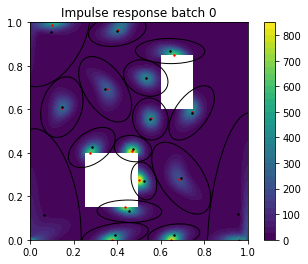

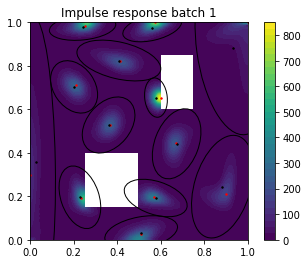

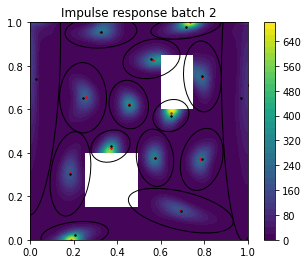

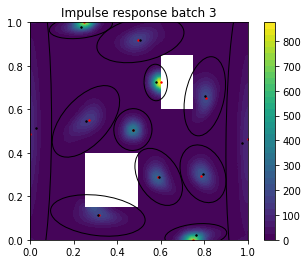

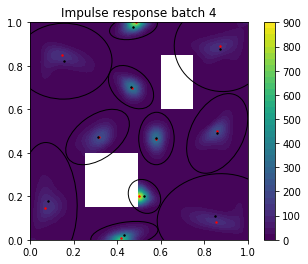

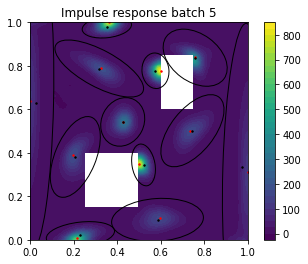

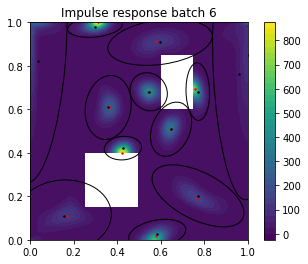

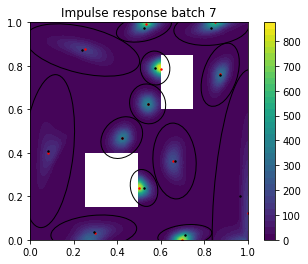

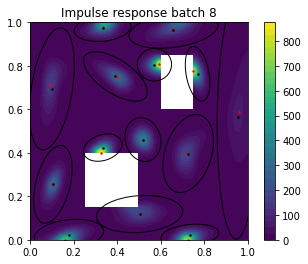

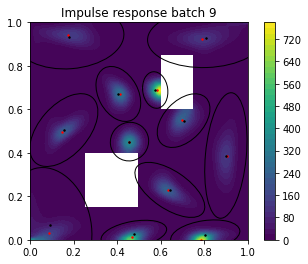

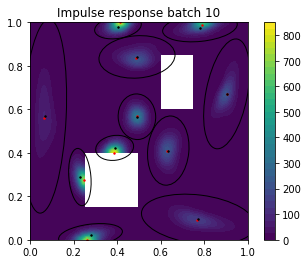

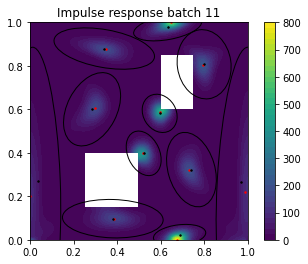

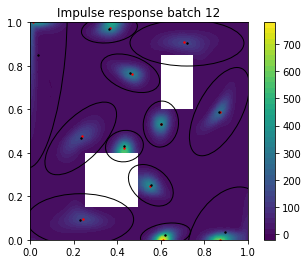

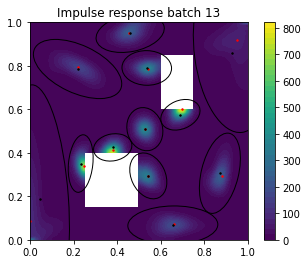

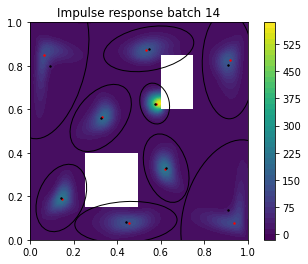

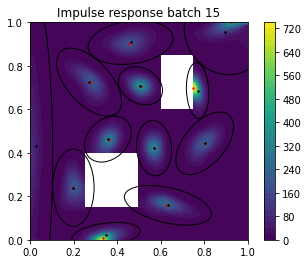

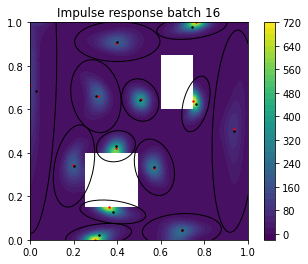

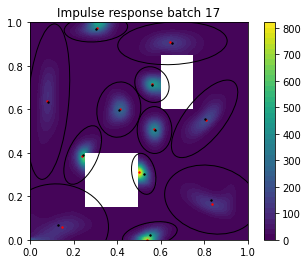

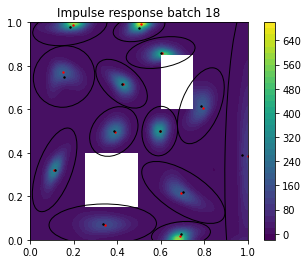

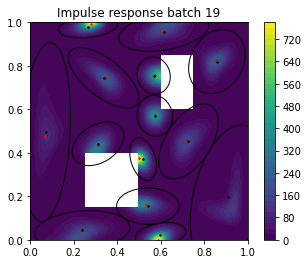

In [19]:
for k in range(PCK.col_batches.num_batches):
    PCK.col_batches.visualize_impulse_response_batch(k)

In [20]:
hmatrix_tol=1e-6
Hd_pch_nonsym, extras = make_hmatrix_from_kernel(PCK, hmatrix_tol=hmatrix_tol)

Making row and column cluster trees
Making block cluster trees
Building A kernel hmatrix
━━ building H-matrix ( tol = Making input and output mass matrix hmatrices
Computing A_hmatrix = M_out_hmatrix * A_kernel_hmatrix * M_in_hmatrix
1e-06 )
                                                         (618.17 MB)                           ]   7% ETA 1:25 m (544.72 MB)

In [21]:
Hd_pch_sym = Hd_pch_nonsym.sym()

    done in 90.72s                                                     
    size of H-matrix = 108.13 MB


In [22]:
x1 = np.random.randn(Vh.dim())
x2 = np.random.randn(Vh.dim())
t1 = np.dot(Hd_pch_sym.matvec(x1), x2)
t2 = np.dot(x1, Hd_pch_sym.matvec(x2))
nonsym = np.abs(t2-t1) / np.abs(t1)
print('nonsym=', nonsym)

nonsym= 1.335428803328358e-09


In [23]:
Hd_pch_dense = nhf.build_dense_matrix_from_matvecs(Hd_pch_sym.matvec, Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [24]:
Hr_dense = nhf.build_dense_matrix_from_matvecs(ADP.apply_Hr_numpy,Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [25]:
ee, P = sla.eigh(Hd_pch_dense, Hr_dense)

ee[:10]= [-1.05991193 -0.80275871 -0.61500576 -0.5581386  -0.48984224 -0.16237167
 -0.1378707  -0.12906815 -0.09798379 -0.09430978]
ee[-10:]= [ 2154.1361131   2494.77119462  3278.87822383  3595.66373079
  4466.01455326  4873.98594275  5817.61437904  6469.14691717
  9732.50122222 11582.54411148]


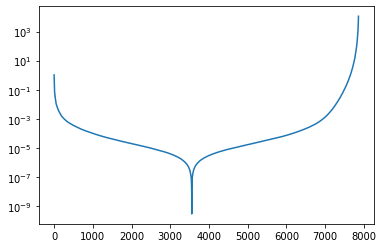

In [30]:
print('ee[:10]=', ee[:10])
print('ee[-10:]=', ee[-10:])
plt.semilogy(np.abs(ee))

Text(0.5, 1.0, 'k=0')

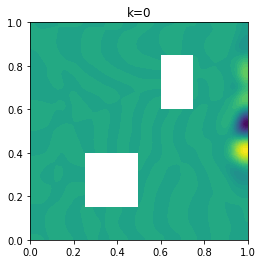

In [71]:
plt.figure()
k=0
uk_non = dl.Function(Vh)
uk_non.vector()[:] = P[:,k].copy()
dl.plot(uk_non)
plt.title('k='+str(k))

In [27]:
ee_non, P_non = sla.eigh(Hd_pch_dense)

ee_non[:10]= [-684.90397298 -593.48577705 -550.85539147 -546.10791252 -517.90337651
 -516.7032166  -479.24333904 -464.01435854 -440.0095393  -431.42423564]
ee_non[-10:]= [ 9795.97936749  9829.67839928  9883.7686387  10052.45623998
 10117.8190168  10256.35273713 10367.69522535 10489.03944656
 10811.29125841 11207.25184166]


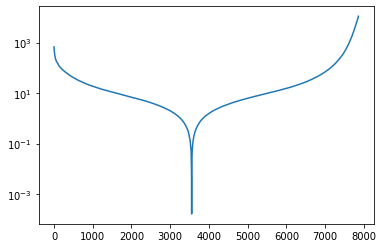

In [60]:
print('ee_non[:10]=', ee_non[:10])
print('ee_non[-10:]=', ee_non[-10:])
plt.semilogy(np.abs(ee_non))

Text(0.5, 1.0, 'k=0')

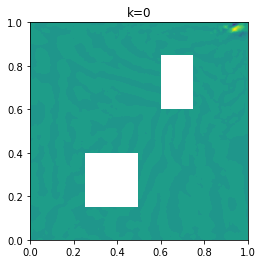

In [70]:
plt.figure()
k=0
uk_non = dl.Function(Vh)
uk_non.vector()[:] = P_non[:,k].copy()
dl.plot(uk_non)
plt.title('k='+str(k))

In [73]:
X = np.max(ee_non) * np.eye(Hd_pch_dense.shape[0]) - Hd_pch_dense

In [74]:
ee_X, P_X = sla.eigh(X, Hr_dense)

In [84]:
ee_X[-10:]

array([ 824.67505567,  844.41359733,  909.12058517, 1039.58727041,
       1110.29403957, 1156.04575355, 1423.59186596, 1573.17622312,
       1622.16238461, 1778.39784091])

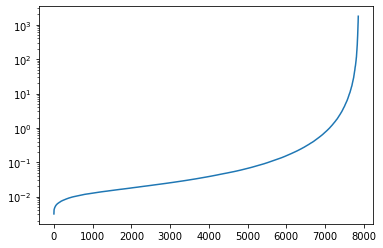

In [77]:
plt.semilogy(np.abs(ee_X[1:]))

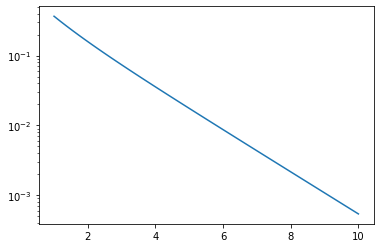

In [102]:
tt = np.linspace(1, 10)
yy = (np.power(3.0, np.power(2.0, -tt)) - 1.0) / 2.0
plt.semilogy(tt, yy)

In [103]:
ee

array([-1.05991193e+00, -8.02758708e-01, -6.15005756e-01, ...,
        6.46914692e+03,  9.73250122e+03,  1.15825441e+04])

In [117]:
u = np.random.randn(len(ee))
u / np.linalg.norm(u)
scalings = []
for k in range(10000):
    u = (np.max(ee) - ee) * u
    scaling = np.linalg.norm(u)
    u = u / scaling
    scalings.append(scaling)
    print('k=', k, ', scaling=', scaling, 'np.max(ee)=', np.max(ee))

k= 0 , scaling= 1013265.4549216162 np.max(ee)= 11582.544111481851
k= 1 , scaling= 11579.039991585474 np.max(ee)= 11582.544111481851
k= 2 , scaling= 11579.936451641517 np.max(ee)= 11582.544111481851
k= 3 , scaling= 11580.37350739761 np.max(ee)= 11582.544111481851
k= 4 , scaling= 11580.646443228485 np.max(ee)= 11582.544111481851
k= 5 , scaling= 11580.844761121203 np.max(ee)= 11582.544111481851
k= 6 , scaling= 11581.001575291628 np.max(ee)= 11582.544111481851
k= 7 , scaling= 11581.131344895979 np.max(ee)= 11582.544111481851
k= 8 , scaling= 11581.241538141596 np.max(ee)= 11582.544111481851
k= 9 , scaling= 11581.33662331951 np.max(ee)= 11582.544111481851
k= 10 , scaling= 11581.419584426405 np.max(ee)= 11582.544111481851
k= 11 , scaling= 11581.492568683614 np.max(ee)= 11582.544111481851
k= 12 , scaling= 11581.557199717314 np.max(ee)= 11582.544111481851
k= 13 , scaling= 11581.614747591357 np.max(ee)= 11582.544111481851
k= 14 , scaling= 11581.666230350856 np.max(ee)= 11582.544111481851
k= 15 ,

k= 200 , scaling= 11582.434696347622 np.max(ee)= 11582.544111481851
k= 201 , scaling= 11582.435098781592 np.max(ee)= 11582.544111481851
k= 202 , scaling= 11582.435497765267 np.max(ee)= 11582.544111481851
k= 203 , scaling= 11582.435893347665 np.max(ee)= 11582.544111481851
k= 204 , scaling= 11582.436285576825 np.max(ee)= 11582.544111481851
k= 205 , scaling= 11582.436674499824 np.max(ee)= 11582.544111481851
k= 206 , scaling= 11582.437060162809 np.max(ee)= 11582.544111481851
k= 207 , scaling= 11582.437442611024 np.max(ee)= 11582.544111481851
k= 208 , scaling= 11582.437821888818 np.max(ee)= 11582.544111481851
k= 209 , scaling= 11582.438198039683 np.max(ee)= 11582.544111481851
k= 210 , scaling= 11582.438571106251 np.max(ee)= 11582.544111481851
k= 211 , scaling= 11582.438941130362 np.max(ee)= 11582.544111481851
k= 212 , scaling= 11582.439308153005 np.max(ee)= 11582.544111481851
k= 213 , scaling= 11582.439672214427 np.max(ee)= 11582.544111481851
k= 214 , scaling= 11582.440033354087 np.max(ee)=

k= 391 , scaling= 11582.477910760075 np.max(ee)= 11582.544111481851
k= 392 , scaling= 11582.478039513102 np.max(ee)= 11582.544111481851
k= 393 , scaling= 11582.478167699299 np.max(ee)= 11582.544111481851
k= 394 , scaling= 11582.478295322459 np.max(ee)= 11582.544111481851
k= 395 , scaling= 11582.478422386328 np.max(ee)= 11582.544111481851
k= 396 , scaling= 11582.478548894642 np.max(ee)= 11582.544111481851
k= 397 , scaling= 11582.47867485108 np.max(ee)= 11582.544111481851
k= 398 , scaling= 11582.478800259303 np.max(ee)= 11582.544111481851
k= 399 , scaling= 11582.478925122932 np.max(ee)= 11582.544111481851
k= 400 , scaling= 11582.47904944556 np.max(ee)= 11582.544111481851
k= 401 , scaling= 11582.479173230744 np.max(ee)= 11582.544111481851
k= 402 , scaling= 11582.479296482012 np.max(ee)= 11582.544111481851
k= 403 , scaling= 11582.47941920286 np.max(ee)= 11582.544111481851
k= 404 , scaling= 11582.479541396764 np.max(ee)= 11582.544111481851
k= 405 , scaling= 11582.479663067144 np.max(ee)= 11

k= 610 , scaling= 11582.496987518347 np.max(ee)= 11582.544111481851
k= 611 , scaling= 11582.497046396671 np.max(ee)= 11582.544111481851
k= 612 , scaling= 11582.497105103243 np.max(ee)= 11582.544111481851
k= 613 , scaling= 11582.497163638829 np.max(ee)= 11582.544111481851
k= 614 , scaling= 11582.497222004195 np.max(ee)= 11582.544111481851
k= 615 , scaling= 11582.4972802001 np.max(ee)= 11582.544111481851
k= 616 , scaling= 11582.497338227302 np.max(ee)= 11582.544111481851
k= 617 , scaling= 11582.497396086554 np.max(ee)= 11582.544111481851
k= 618 , scaling= 11582.497453778597 np.max(ee)= 11582.544111481851
k= 619 , scaling= 11582.497511304184 np.max(ee)= 11582.544111481851
k= 620 , scaling= 11582.497568664046 np.max(ee)= 11582.544111481851
k= 621 , scaling= 11582.49762585892 np.max(ee)= 11582.544111481851
k= 622 , scaling= 11582.497682889534 np.max(ee)= 11582.544111481851
k= 623 , scaling= 11582.497739756616 np.max(ee)= 11582.544111481851
k= 624 , scaling= 11582.497796460884 np.max(ee)= 11

k= 812 , scaling= 11582.506197325674 np.max(ee)= 11582.544111481851
k= 813 , scaling= 11582.506232619704 np.max(ee)= 11582.544111481851
k= 814 , scaling= 11582.506267836057 np.max(ee)= 11582.544111481851
k= 815 , scaling= 11582.50630297501 np.max(ee)= 11582.544111481851
k= 816 , scaling= 11582.506338036823 np.max(ee)= 11582.544111481851
k= 817 , scaling= 11582.506373021759 np.max(ee)= 11582.544111481851
k= 818 , scaling= 11582.50640793009 np.max(ee)= 11582.544111481851
k= 819 , scaling= 11582.506442762073 np.max(ee)= 11582.544111481851
k= 820 , scaling= 11582.506477517969 np.max(ee)= 11582.544111481851
k= 821 , scaling= 11582.506512198042 np.max(ee)= 11582.544111481851
k= 822 , scaling= 11582.50654680255 np.max(ee)= 11582.544111481851
k= 823 , scaling= 11582.50658133175 np.max(ee)= 11582.544111481851
k= 824 , scaling= 11582.506615785902 np.max(ee)= 11582.544111481851
k= 825 , scaling= 11582.506650165258 np.max(ee)= 11582.544111481851
k= 826 , scaling= 11582.506684470074 np.max(ee)= 115

k= 1010 , scaling= 11582.511949543908 np.max(ee)= 11582.544111481851
k= 1011 , scaling= 11582.511973461971 np.max(ee)= 11582.544111481851
k= 1012 , scaling= 11582.51199733813 np.max(ee)= 11582.544111481851
k= 1013 , scaling= 11582.512021172492 np.max(ee)= 11582.544111481851
k= 1014 , scaling= 11582.512044965184 np.max(ee)= 11582.544111481851
k= 1015 , scaling= 11582.51206871632 np.max(ee)= 11582.544111481851
k= 1016 , scaling= 11582.512092426015 np.max(ee)= 11582.544111481851
k= 1017 , scaling= 11582.512116094387 np.max(ee)= 11582.544111481851
k= 1018 , scaling= 11582.512139721552 np.max(ee)= 11582.544111481851
k= 1019 , scaling= 11582.512163307627 np.max(ee)= 11582.544111481851
k= 1020 , scaling= 11582.51218685272 np.max(ee)= 11582.544111481851
k= 1021 , scaling= 11582.512210356952 np.max(ee)= 11582.544111481851
k= 1022 , scaling= 11582.512233820433 np.max(ee)= 11582.544111481851
k= 1023 , scaling= 11582.512257243283 np.max(ee)= 11582.544111481851
k= 1024 , scaling= 11582.512280625608

k= 1198 , scaling= 11582.515818969665 np.max(ee)= 11582.544111481851
k= 1199 , scaling= 11582.51583668588 np.max(ee)= 11582.544111481851
k= 1200 , scaling= 11582.515854376355 np.max(ee)= 11582.544111481851
k= 1201 , scaling= 11582.515872041158 np.max(ee)= 11582.544111481851
k= 1202 , scaling= 11582.515889680346 np.max(ee)= 11582.544111481851
k= 1203 , scaling= 11582.515907293979 np.max(ee)= 11582.544111481851
k= 1204 , scaling= 11582.515924882118 np.max(ee)= 11582.544111481851
k= 1205 , scaling= 11582.51594244483 np.max(ee)= 11582.544111481851
k= 1206 , scaling= 11582.515959982165 np.max(ee)= 11582.544111481851
k= 1207 , scaling= 11582.515977494193 np.max(ee)= 11582.544111481851
k= 1208 , scaling= 11582.515994980964 np.max(ee)= 11582.544111481851
k= 1209 , scaling= 11582.516012442551 np.max(ee)= 11582.544111481851
k= 1210 , scaling= 11582.516029878998 np.max(ee)= 11582.544111481851
k= 1211 , scaling= 11582.516047290377 np.max(ee)= 11582.544111481851
k= 1212 , scaling= 11582.51606467673

k= 1373 , scaling= 11582.518574755408 np.max(ee)= 11582.544111481851
k= 1374 , scaling= 11582.518588753634 np.max(ee)= 11582.544111481851
k= 1375 , scaling= 11582.518602734413 np.max(ee)= 11582.544111481851
k= 1376 , scaling= 11582.518616697795 np.max(ee)= 11582.544111481851
k= 1377 , scaling= 11582.518630643806 np.max(ee)= 11582.544111481851
k= 1378 , scaling= 11582.518644572488 np.max(ee)= 11582.544111481851
k= 1379 , scaling= 11582.518658483876 np.max(ee)= 11582.544111481851
k= 1380 , scaling= 11582.518672378003 np.max(ee)= 11582.544111481851
k= 1381 , scaling= 11582.518686254905 np.max(ee)= 11582.544111481851
k= 1382 , scaling= 11582.51870011462 np.max(ee)= 11582.544111481851
k= 1383 , scaling= 11582.518713957183 np.max(ee)= 11582.544111481851
k= 1384 , scaling= 11582.518727782626 np.max(ee)= 11582.544111481851
k= 1385 , scaling= 11582.51874159099 np.max(ee)= 11582.544111481851
k= 1386 , scaling= 11582.518755382302 np.max(ee)= 11582.544111481851
k= 1387 , scaling= 11582.51876915660

k= 1575 , scaling= 11582.521091148243 np.max(ee)= 11582.544111481851
k= 1576 , scaling= 11582.521102238406 np.max(ee)= 11582.544111481851
k= 1577 , scaling= 11582.521113316741 np.max(ee)= 11582.544111481851
k= 1578 , scaling= 11582.521124383271 np.max(ee)= 11582.544111481851
k= 1579 , scaling= 11582.52113543801 np.max(ee)= 11582.544111481851
k= 1580 , scaling= 11582.521146480987 np.max(ee)= 11582.544111481851
k= 1581 , scaling= 11582.52115751222 np.max(ee)= 11582.544111481851
k= 1582 , scaling= 11582.521168531728 np.max(ee)= 11582.544111481851
k= 1583 , scaling= 11582.521179539533 np.max(ee)= 11582.544111481851
k= 1584 , scaling= 11582.521190535657 np.max(ee)= 11582.544111481851
k= 1585 , scaling= 11582.521201520118 np.max(ee)= 11582.544111481851
k= 1586 , scaling= 11582.52121249294 np.max(ee)= 11582.544111481851
k= 1587 , scaling= 11582.521223454143 np.max(ee)= 11582.544111481851
k= 1588 , scaling= 11582.521234403745 np.max(ee)= 11582.544111481851
k= 1589 , scaling= 11582.521245341766

k= 1757 , scaling= 11582.522933460998 np.max(ee)= 11582.544111481851
k= 1758 , scaling= 11582.522942699881 np.max(ee)= 11582.544111481851
k= 1759 , scaling= 11582.522951930046 np.max(ee)= 11582.544111481851
k= 1760 , scaling= 11582.522961151502 np.max(ee)= 11582.544111481851
k= 1761 , scaling= 11582.522970364269 np.max(ee)= 11582.544111481851
k= 1762 , scaling= 11582.522979568354 np.max(ee)= 11582.544111481851
k= 1763 , scaling= 11582.522988763772 np.max(ee)= 11582.544111481851
k= 1764 , scaling= 11582.522997950544 np.max(ee)= 11582.544111481851
k= 1765 , scaling= 11582.523007128675 np.max(ee)= 11582.544111481851
k= 1766 , scaling= 11582.523016298177 np.max(ee)= 11582.544111481851
k= 1767 , scaling= 11582.523025459073 np.max(ee)= 11582.544111481851
k= 1768 , scaling= 11582.523034611368 np.max(ee)= 11582.544111481851
k= 1769 , scaling= 11582.523043755082 np.max(ee)= 11582.544111481851
k= 1770 , scaling= 11582.523052890221 np.max(ee)= 11582.544111481851
k= 1771 , scaling= 11582.523062016

k= 1956 , scaling= 11582.524616208488 np.max(ee)= 11582.544111481851
k= 1957 , scaling= 11582.52462394769 np.max(ee)= 11582.544111481851
k= 1958 , scaling= 11582.524631680395 np.max(ee)= 11582.544111481851
k= 1959 , scaling= 11582.524639406614 np.max(ee)= 11582.544111481851
k= 1960 , scaling= 11582.524647126356 np.max(ee)= 11582.544111481851
k= 1961 , scaling= 11582.524654839632 np.max(ee)= 11582.544111481851
k= 1962 , scaling= 11582.524662546442 np.max(ee)= 11582.544111481851
k= 1963 , scaling= 11582.524670246807 np.max(ee)= 11582.544111481851
k= 1964 , scaling= 11582.524677940732 np.max(ee)= 11582.544111481851
k= 1965 , scaling= 11582.524685628217 np.max(ee)= 11582.544111481851
k= 1966 , scaling= 11582.524693309284 np.max(ee)= 11582.544111481851
k= 1967 , scaling= 11582.524700983935 np.max(ee)= 11582.544111481851
k= 1968 , scaling= 11582.524708652181 np.max(ee)= 11582.544111481851
k= 1969 , scaling= 11582.524716314028 np.max(ee)= 11582.544111481851
k= 1970 , scaling= 11582.5247239694

k= 2153 , scaling= 11582.52602577845 np.max(ee)= 11582.544111481851
k= 2154 , scaling= 11582.526032392549 np.max(ee)= 11582.544111481851
k= 2155 , scaling= 11582.526039001634 np.max(ee)= 11582.544111481851
k= 2156 , scaling= 11582.526045605715 np.max(ee)= 11582.544111481851
k= 2157 , scaling= 11582.5260522048 np.max(ee)= 11582.544111481851
k= 2158 , scaling= 11582.526058798892 np.max(ee)= 11582.544111481851
k= 2159 , scaling= 11582.526065387998 np.max(ee)= 11582.544111481851
k= 2160 , scaling= 11582.526071972125 np.max(ee)= 11582.544111481851
k= 2161 , scaling= 11582.526078551278 np.max(ee)= 11582.544111481851
k= 2162 , scaling= 11582.526085125464 np.max(ee)= 11582.544111481851
k= 2163 , scaling= 11582.52609169469 np.max(ee)= 11582.544111481851
k= 2164 , scaling= 11582.52609825896 np.max(ee)= 11582.544111481851
k= 2165 , scaling= 11582.526104818284 np.max(ee)= 11582.544111481851
k= 2166 , scaling= 11582.526111372661 np.max(ee)= 11582.544111481851
k= 2167 , scaling= 11582.526117922103 n

k= 2360 , scaling= 11582.52729641474 np.max(ee)= 11582.544111481851
k= 2361 , scaling= 11582.527302110404 np.max(ee)= 11582.544111481851
k= 2362 , scaling= 11582.527307802151 np.max(ee)= 11582.544111481851
k= 2363 , scaling= 11582.527313489978 np.max(ee)= 11582.544111481851
k= 2364 , scaling= 11582.527319173898 np.max(ee)= 11582.544111481851
k= 2365 , scaling= 11582.527324853905 np.max(ee)= 11582.544111481851
k= 2366 , scaling= 11582.527330530009 np.max(ee)= 11582.544111481851
k= 2367 , scaling= 11582.527336202218 np.max(ee)= 11582.544111481851
k= 2368 , scaling= 11582.527341870526 np.max(ee)= 11582.544111481851
k= 2369 , scaling= 11582.527347534953 np.max(ee)= 11582.544111481851
k= 2370 , scaling= 11582.527353195483 np.max(ee)= 11582.544111481851
k= 2371 , scaling= 11582.52735885214 np.max(ee)= 11582.544111481851
k= 2372 , scaling= 11582.527364504913 np.max(ee)= 11582.544111481851
k= 2373 , scaling= 11582.527370153819 np.max(ee)= 11582.544111481851
k= 2374 , scaling= 11582.52737579885

k= 2545 , scaling= 11582.528287645788 np.max(ee)= 11582.544111481851
k= 2546 , scaling= 11582.528292684441 np.max(ee)= 11582.544111481851
k= 2547 , scaling= 11582.528297719882 np.max(ee)= 11582.544111481851
k= 2548 , scaling= 11582.528302752113 np.max(ee)= 11582.544111481851
k= 2549 , scaling= 11582.528307781142 np.max(ee)= 11582.544111481851
k= 2550 , scaling= 11582.528312806968 np.max(ee)= 11582.544111481851
k= 2551 , scaling= 11582.528317829598 np.max(ee)= 11582.544111481851
k= 2552 , scaling= 11582.528322849028 np.max(ee)= 11582.544111481851
k= 2553 , scaling= 11582.528327865271 np.max(ee)= 11582.544111481851
k= 2554 , scaling= 11582.528332878324 np.max(ee)= 11582.544111481851
k= 2555 , scaling= 11582.528337888194 np.max(ee)= 11582.544111481851
k= 2556 , scaling= 11582.52834289488 np.max(ee)= 11582.544111481851
k= 2557 , scaling= 11582.52834789839 np.max(ee)= 11582.544111481851
k= 2558 , scaling= 11582.52835289872 np.max(ee)= 11582.544111481851
k= 2559 , scaling= 11582.528357895884

k= 2758 , scaling= 11582.529293272923 np.max(ee)= 11582.544111481851
k= 2759 , scaling= 11582.529297695552 np.max(ee)= 11582.544111481851
k= 2760 , scaling= 11582.529302115585 np.max(ee)= 11582.544111481851
k= 2761 , scaling= 11582.52930653302 np.max(ee)= 11582.544111481851
k= 2762 , scaling= 11582.529310947855 np.max(ee)= 11582.544111481851
k= 2763 , scaling= 11582.529315360101 np.max(ee)= 11582.544111481851
k= 2764 , scaling= 11582.529319769761 np.max(ee)= 11582.544111481851
k= 2765 , scaling= 11582.529324176823 np.max(ee)= 11582.544111481851
k= 2766 , scaling= 11582.529328581306 np.max(ee)= 11582.544111481851
k= 2767 , scaling= 11582.529332983206 np.max(ee)= 11582.544111481851
k= 2768 , scaling= 11582.529337382522 np.max(ee)= 11582.544111481851
k= 2769 , scaling= 11582.529341779262 np.max(ee)= 11582.544111481851
k= 2770 , scaling= 11582.529346173425 np.max(ee)= 11582.544111481851
k= 2771 , scaling= 11582.529350565019 np.max(ee)= 11582.544111481851
k= 2772 , scaling= 11582.5293549540

k= 2974 , scaling= 11582.530191997712 np.max(ee)= 11582.544111481851
k= 2975 , scaling= 11582.530195910962 np.max(ee)= 11582.544111481851
k= 2976 , scaling= 11582.530199822078 np.max(ee)= 11582.544111481851
k= 2977 , scaling= 11582.53020373106 np.max(ee)= 11582.544111481851
k= 2978 , scaling= 11582.53020763791 np.max(ee)= 11582.544111481851
k= 2979 , scaling= 11582.53021154263 np.max(ee)= 11582.544111481851
k= 2980 , scaling= 11582.530215445222 np.max(ee)= 11582.544111481851
k= 2981 , scaling= 11582.530219345688 np.max(ee)= 11582.544111481851
k= 2982 , scaling= 11582.53022324403 np.max(ee)= 11582.544111481851
k= 2983 , scaling= 11582.530227140249 np.max(ee)= 11582.544111481851
k= 2984 , scaling= 11582.530231034347 np.max(ee)= 11582.544111481851
k= 2985 , scaling= 11582.530234926327 np.max(ee)= 11582.544111481851
k= 2986 , scaling= 11582.53023881619 np.max(ee)= 11582.544111481851
k= 2987 , scaling= 11582.530242703937 np.max(ee)= 11582.544111481851
k= 2988 , scaling= 11582.530246589573 n

k= 3153 , scaling= 11582.530860117033 np.max(ee)= 11582.544111481851
k= 3154 , scaling= 11582.530863675807 np.max(ee)= 11582.544111481851
k= 3155 , scaling= 11582.530867232748 np.max(ee)= 11582.544111481851
k= 3156 , scaling= 11582.53087078786 np.max(ee)= 11582.544111481851
k= 3157 , scaling= 11582.530874341135 np.max(ee)= 11582.544111481851
k= 3158 , scaling= 11582.530877892585 np.max(ee)= 11582.544111481851
k= 3159 , scaling= 11582.530881442206 np.max(ee)= 11582.544111481851
k= 3160 , scaling= 11582.530884989998 np.max(ee)= 11582.544111481851
k= 3161 , scaling= 11582.530888535968 np.max(ee)= 11582.544111481851
k= 3162 , scaling= 11582.530892080113 np.max(ee)= 11582.544111481851
k= 3163 , scaling= 11582.530895622433 np.max(ee)= 11582.544111481851
k= 3164 , scaling= 11582.53089916294 np.max(ee)= 11582.544111481851
k= 3165 , scaling= 11582.53090270162 np.max(ee)= 11582.544111481851
k= 3166 , scaling= 11582.530906238486 np.max(ee)= 11582.544111481851
k= 3167 , scaling= 11582.530909773537

k= 3315 , scaling= 11582.531413725184 np.max(ee)= 11582.544111481851
k= 3316 , scaling= 11582.531417005399 np.max(ee)= 11582.544111481851
k= 3317 , scaling= 11582.531420284009 np.max(ee)= 11582.544111481851
k= 3318 , scaling= 11582.531423561004 np.max(ee)= 11582.544111481851
k= 3319 , scaling= 11582.531426836395 np.max(ee)= 11582.544111481851
k= 3320 , scaling= 11582.531430110177 np.max(ee)= 11582.544111481851
k= 3321 , scaling= 11582.531433382357 np.max(ee)= 11582.544111481851
k= 3322 , scaling= 11582.531436652931 np.max(ee)= 11582.544111481851
k= 3323 , scaling= 11582.5314399219 np.max(ee)= 11582.544111481851
k= 3324 , scaling= 11582.531443189273 np.max(ee)= 11582.544111481851
k= 3325 , scaling= 11582.531446455041 np.max(ee)= 11582.544111481851
k= 3326 , scaling= 11582.531449719212 np.max(ee)= 11582.544111481851
k= 3327 , scaling= 11582.531452981786 np.max(ee)= 11582.544111481851
k= 3328 , scaling= 11582.531456242761 np.max(ee)= 11582.544111481851
k= 3329 , scaling= 11582.53145950214

k= 3495 , scaling= 11582.531979372796 np.max(ee)= 11582.544111481851
k= 3496 , scaling= 11582.531982382243 np.max(ee)= 11582.544111481851
k= 3497 , scaling= 11582.531985390287 np.max(ee)= 11582.544111481851
k= 3498 , scaling= 11582.531988396928 np.max(ee)= 11582.544111481851
k= 3499 , scaling= 11582.531991402167 np.max(ee)= 11582.544111481851
k= 3500 , scaling= 11582.531994406005 np.max(ee)= 11582.544111481851
k= 3501 , scaling= 11582.531997408445 np.max(ee)= 11582.544111481851
k= 3502 , scaling= 11582.532000409486 np.max(ee)= 11582.544111481851
k= 3503 , scaling= 11582.532003409127 np.max(ee)= 11582.544111481851
k= 3504 , scaling= 11582.532006407375 np.max(ee)= 11582.544111481851
k= 3505 , scaling= 11582.532009404227 np.max(ee)= 11582.544111481851
k= 3506 , scaling= 11582.532012399683 np.max(ee)= 11582.544111481851
k= 3507 , scaling= 11582.532015393746 np.max(ee)= 11582.544111481851
k= 3508 , scaling= 11582.532018386417 np.max(ee)= 11582.544111481851
k= 3509 , scaling= 11582.532021377

k= 3697 , scaling= 11582.532560126461 np.max(ee)= 11582.544111481851
k= 3698 , scaling= 11582.532562872158 np.max(ee)= 11582.544111481851
k= 3699 , scaling= 11582.53256561664 np.max(ee)= 11582.544111481851
k= 3700 , scaling= 11582.532568359911 np.max(ee)= 11582.544111481851
k= 3701 , scaling= 11582.532571101972 np.max(ee)= 11582.544111481851
k= 3702 , scaling= 11582.53257384282 np.max(ee)= 11582.544111481851
k= 3703 , scaling= 11582.532576582464 np.max(ee)= 11582.544111481851
k= 3704 , scaling= 11582.532579320889 np.max(ee)= 11582.544111481851
k= 3705 , scaling= 11582.532582058113 np.max(ee)= 11582.544111481851
k= 3706 , scaling= 11582.53258479413 np.max(ee)= 11582.544111481851
k= 3707 , scaling= 11582.532587528938 np.max(ee)= 11582.544111481851
k= 3708 , scaling= 11582.532590262539 np.max(ee)= 11582.544111481851
k= 3709 , scaling= 11582.532592994941 np.max(ee)= 11582.544111481851
k= 3710 , scaling= 11582.532595726136 np.max(ee)= 11582.544111481851
k= 3711 , scaling= 11582.532598456126

k= 3873 , scaling= 11582.53302541734 np.max(ee)= 11582.544111481851
k= 3874 , scaling= 11582.533027961948 np.max(ee)= 11582.544111481851
k= 3875 , scaling= 11582.533030505485 np.max(ee)= 11582.544111481851
k= 3876 , scaling= 11582.533033047941 np.max(ee)= 11582.544111481851
k= 3877 , scaling= 11582.533035589327 np.max(ee)= 11582.544111481851
k= 3878 , scaling= 11582.533038129643 np.max(ee)= 11582.544111481851
k= 3879 , scaling= 11582.533040668884 np.max(ee)= 11582.544111481851
k= 3880 , scaling= 11582.533043207055 np.max(ee)= 11582.544111481851
k= 3881 , scaling= 11582.533045744152 np.max(ee)= 11582.544111481851
k= 3882 , scaling= 11582.533048280184 np.max(ee)= 11582.544111481851
k= 3883 , scaling= 11582.533050815144 np.max(ee)= 11582.544111481851
k= 3884 , scaling= 11582.533053349036 np.max(ee)= 11582.544111481851
k= 3885 , scaling= 11582.533055881859 np.max(ee)= 11582.544111481851
k= 3886 , scaling= 11582.533058413615 np.max(ee)= 11582.544111481851
k= 3887 , scaling= 11582.5330609443

k= 4048 , scaling= 11582.533454967052 np.max(ee)= 11582.544111481851
k= 4049 , scaling= 11582.533457333973 np.max(ee)= 11582.544111481851
k= 4050 , scaling= 11582.53345969994 np.max(ee)= 11582.544111481851
k= 4051 , scaling= 11582.533462064948 np.max(ee)= 11582.544111481851
k= 4052 , scaling= 11582.533464429 np.max(ee)= 11582.544111481851
k= 4053 , scaling= 11582.533466792094 np.max(ee)= 11582.544111481851
k= 4054 , scaling= 11582.533469154232 np.max(ee)= 11582.544111481851
k= 4055 , scaling= 11582.53347151542 np.max(ee)= 11582.544111481851
k= 4056 , scaling= 11582.533473875646 np.max(ee)= 11582.544111481851
k= 4057 , scaling= 11582.533476234925 np.max(ee)= 11582.544111481851
k= 4058 , scaling= 11582.533478593246 np.max(ee)= 11582.544111481851
k= 4059 , scaling= 11582.533480950617 np.max(ee)= 11582.544111481851
k= 4060 , scaling= 11582.533483307036 np.max(ee)= 11582.544111481851
k= 4061 , scaling= 11582.533485662503 np.max(ee)= 11582.544111481851
k= 4062 , scaling= 11582.533488017018 n

k= 4251 , scaling= 11582.533916620574 np.max(ee)= 11582.544111481851
k= 4252 , scaling= 11582.53391880495 np.max(ee)= 11582.544111481851
k= 4253 , scaling= 11582.533920988486 np.max(ee)= 11582.544111481851
k= 4254 , scaling= 11582.533923171173 np.max(ee)= 11582.544111481851
k= 4255 , scaling= 11582.53392535302 np.max(ee)= 11582.544111481851
k= 4256 , scaling= 11582.533927534027 np.max(ee)= 11582.544111481851
k= 4257 , scaling= 11582.533929714193 np.max(ee)= 11582.544111481851
k= 4258 , scaling= 11582.533931893518 np.max(ee)= 11582.544111481851
k= 4259 , scaling= 11582.533934072 np.max(ee)= 11582.544111481851
k= 4260 , scaling= 11582.533936249643 np.max(ee)= 11582.544111481851
k= 4261 , scaling= 11582.533938426453 np.max(ee)= 11582.544111481851
k= 4262 , scaling= 11582.53394060242 np.max(ee)= 11582.544111481851
k= 4263 , scaling= 11582.533942777549 np.max(ee)= 11582.544111481851
k= 4264 , scaling= 11582.533944951843 np.max(ee)= 11582.544111481851
k= 4265 , scaling= 11582.533947125296 np

k= 4445 , scaling= 11582.534325202592 np.max(ee)= 11582.544111481851
k= 4446 , scaling= 11582.534327232615 np.max(ee)= 11582.544111481851
k= 4447 , scaling= 11582.534329261887 np.max(ee)= 11582.544111481851
k= 4448 , scaling= 11582.534331290413 np.max(ee)= 11582.544111481851
k= 4449 , scaling= 11582.534333318188 np.max(ee)= 11582.544111481851
k= 4450 , scaling= 11582.534335345214 np.max(ee)= 11582.544111481851
k= 4451 , scaling= 11582.534337371491 np.max(ee)= 11582.544111481851
k= 4452 , scaling= 11582.534339397022 np.max(ee)= 11582.544111481851
k= 4453 , scaling= 11582.534341421806 np.max(ee)= 11582.544111481851
k= 4454 , scaling= 11582.534343445841 np.max(ee)= 11582.544111481851
k= 4455 , scaling= 11582.534345469128 np.max(ee)= 11582.544111481851
k= 4456 , scaling= 11582.53434749167 np.max(ee)= 11582.544111481851
k= 4457 , scaling= 11582.534349513471 np.max(ee)= 11582.544111481851
k= 4458 , scaling= 11582.53435153452 np.max(ee)= 11582.544111481851
k= 4459 , scaling= 11582.53435355483

k= 4604 , scaling= 11582.53463883731 np.max(ee)= 11582.544111481851
k= 4605 , scaling= 11582.534640753414 np.max(ee)= 11582.544111481851
k= 4606 , scaling= 11582.534642668837 np.max(ee)= 11582.544111481851
k= 4607 , scaling= 11582.534644583575 np.max(ee)= 11582.544111481851
k= 4608 , scaling= 11582.534646497634 np.max(ee)= 11582.544111481851
k= 4609 , scaling= 11582.534648411005 np.max(ee)= 11582.544111481851
k= 4610 , scaling= 11582.534650323698 np.max(ee)= 11582.544111481851
k= 4611 , scaling= 11582.534652235707 np.max(ee)= 11582.544111481851
k= 4612 , scaling= 11582.534654147037 np.max(ee)= 11582.544111481851
k= 4613 , scaling= 11582.534656057682 np.max(ee)= 11582.544111481851
k= 4614 , scaling= 11582.534657967648 np.max(ee)= 11582.544111481851
k= 4615 , scaling= 11582.534659876934 np.max(ee)= 11582.544111481851
k= 4616 , scaling= 11582.534661785543 np.max(ee)= 11582.544111481851
k= 4617 , scaling= 11582.534663693466 np.max(ee)= 11582.544111481851
k= 4618 , scaling= 11582.5346656007

k= 4790 , scaling= 11582.534983867381 np.max(ee)= 11582.544111481851
k= 4791 , scaling= 11582.534985662733 np.max(ee)= 11582.544111481851
k= 4792 , scaling= 11582.534987457466 np.max(ee)= 11582.544111481851
k= 4793 , scaling= 11582.53498925159 np.max(ee)= 11582.544111481851
k= 4794 , scaling= 11582.534991045093 np.max(ee)= 11582.544111481851
k= 4795 , scaling= 11582.534992837982 np.max(ee)= 11582.544111481851
k= 4796 , scaling= 11582.534994630258 np.max(ee)= 11582.544111481851
k= 4797 , scaling= 11582.534996421922 np.max(ee)= 11582.544111481851
k= 4798 , scaling= 11582.534998212966 np.max(ee)= 11582.544111481851
k= 4799 , scaling= 11582.535000003403 np.max(ee)= 11582.544111481851
k= 4800 , scaling= 11582.53500179322 np.max(ee)= 11582.544111481851
k= 4801 , scaling= 11582.53500358243 np.max(ee)= 11582.544111481851
k= 4802 , scaling= 11582.535005371028 np.max(ee)= 11582.544111481851
k= 4803 , scaling= 11582.535007159011 np.max(ee)= 11582.544111481851
k= 4804 , scaling= 11582.535008946383

k= 4975 , scaling= 11582.535305867668 np.max(ee)= 11582.544111481851
k= 4976 , scaling= 11582.535307554635 np.max(ee)= 11582.544111481851
k= 4977 , scaling= 11582.535309241042 np.max(ee)= 11582.544111481851
k= 4978 , scaling= 11582.535310926896 np.max(ee)= 11582.544111481851
k= 4979 , scaling= 11582.535312612188 np.max(ee)= 11582.544111481851
k= 4980 , scaling= 11582.535314296927 np.max(ee)= 11582.544111481851
k= 4981 , scaling= 11582.535315981113 np.max(ee)= 11582.544111481851
k= 4982 , scaling= 11582.53531766474 np.max(ee)= 11582.544111481851
k= 4983 , scaling= 11582.535319347813 np.max(ee)= 11582.544111481851
k= 4984 , scaling= 11582.535321030331 np.max(ee)= 11582.544111481851
k= 4985 , scaling= 11582.535322712294 np.max(ee)= 11582.544111481851
k= 4986 , scaling= 11582.535324393706 np.max(ee)= 11582.544111481851
k= 4987 , scaling= 11582.53532607456 np.max(ee)= 11582.544111481851
k= 4988 , scaling= 11582.535327754862 np.max(ee)= 11582.544111481851
k= 4989 , scaling= 11582.53532943461

k= 5174 , scaling= 11582.535630975053 np.max(ee)= 11582.544111481851
k= 5175 , scaling= 11582.53563255681 np.max(ee)= 11582.544111481851
k= 5176 , scaling= 11582.53563413806 np.max(ee)= 11582.544111481851
k= 5177 , scaling= 11582.535635718812 np.max(ee)= 11582.544111481851
k= 5178 , scaling= 11582.535637299059 np.max(ee)= 11582.544111481851
k= 5179 , scaling= 11582.535638878811 np.max(ee)= 11582.544111481851
k= 5180 , scaling= 11582.53564045806 np.max(ee)= 11582.544111481851
k= 5181 , scaling= 11582.535642036808 np.max(ee)= 11582.544111481851
k= 5182 , scaling= 11582.535643615056 np.max(ee)= 11582.544111481851
k= 5183 , scaling= 11582.535645192806 np.max(ee)= 11582.544111481851
k= 5184 , scaling= 11582.535646770057 np.max(ee)= 11582.544111481851
k= 5185 , scaling= 11582.535648346804 np.max(ee)= 11582.544111481851
k= 5186 , scaling= 11582.535649923058 np.max(ee)= 11582.544111481851
k= 5187 , scaling= 11582.535651498809 np.max(ee)= 11582.544111481851
k= 5188 , scaling= 11582.535653074066

k= 5362 , scaling= 11582.53591980352 np.max(ee)= 11582.544111481851
k= 5363 , scaling= 11582.53592129537 np.max(ee)= 11582.544111481851
k= 5364 , scaling= 11582.535922786761 np.max(ee)= 11582.544111481851
k= 5365 , scaling= 11582.5359242777 np.max(ee)= 11582.544111481851
k= 5366 , scaling= 11582.53592576818 np.max(ee)= 11582.544111481851
k= 5367 , scaling= 11582.535927258206 np.max(ee)= 11582.544111481851
k= 5368 , scaling= 11582.535928747779 np.max(ee)= 11582.544111481851
k= 5369 , scaling= 11582.535930236896 np.max(ee)= 11582.544111481851
k= 5370 , scaling= 11582.535931725559 np.max(ee)= 11582.544111481851
k= 5371 , scaling= 11582.535933213767 np.max(ee)= 11582.544111481851
k= 5372 , scaling= 11582.535934701524 np.max(ee)= 11582.544111481851
k= 5373 , scaling= 11582.535936188826 np.max(ee)= 11582.544111481851
k= 5374 , scaling= 11582.535937675671 np.max(ee)= 11582.544111481851
k= 5375 , scaling= 11582.535939162068 np.max(ee)= 11582.544111481851
k= 5376 , scaling= 11582.535940648011 n

k= 5526 , scaling= 11582.536158537217 np.max(ee)= 11582.544111481851
k= 5527 , scaling= 11582.536159957293 np.max(ee)= 11582.544111481851
k= 5528 , scaling= 11582.536161376947 np.max(ee)= 11582.544111481851
k= 5529 , scaling= 11582.536162796185 np.max(ee)= 11582.544111481851
k= 5530 , scaling= 11582.536164214996 np.max(ee)= 11582.544111481851
k= 5531 , scaling= 11582.536165633393 np.max(ee)= 11582.544111481851
k= 5532 , scaling= 11582.53616705137 np.max(ee)= 11582.544111481851
k= 5533 , scaling= 11582.536168468927 np.max(ee)= 11582.544111481851
k= 5534 , scaling= 11582.536169886065 np.max(ee)= 11582.544111481851
k= 5535 , scaling= 11582.536171302787 np.max(ee)= 11582.544111481851
k= 5536 , scaling= 11582.536172719088 np.max(ee)= 11582.544111481851
k= 5537 , scaling= 11582.53617413497 np.max(ee)= 11582.544111481851
k= 5538 , scaling= 11582.536175550436 np.max(ee)= 11582.544111481851
k= 5539 , scaling= 11582.536176965485 np.max(ee)= 11582.544111481851
k= 5540 , scaling= 11582.53617838011

k= 5710 , scaling= 11582.536412963487 np.max(ee)= 11582.544111481851
k= 5711 , scaling= 11582.536414309612 np.max(ee)= 11582.544111481851
k= 5712 , scaling= 11582.536415655351 np.max(ee)= 11582.544111481851
k= 5713 , scaling= 11582.536417000707 np.max(ee)= 11582.544111481851
k= 5714 , scaling= 11582.536418345675 np.max(ee)= 11582.544111481851
k= 5715 , scaling= 11582.536419690265 np.max(ee)= 11582.544111481851
k= 5716 , scaling= 11582.536421034467 np.max(ee)= 11582.544111481851
k= 5717 , scaling= 11582.536422378287 np.max(ee)= 11582.544111481851
k= 5718 , scaling= 11582.536423721727 np.max(ee)= 11582.544111481851
k= 5719 , scaling= 11582.536425064778 np.max(ee)= 11582.544111481851
k= 5720 , scaling= 11582.536426407452 np.max(ee)= 11582.544111481851
k= 5721 , scaling= 11582.536427749737 np.max(ee)= 11582.544111481851
k= 5722 , scaling= 11582.536429091648 np.max(ee)= 11582.544111481851
k= 5723 , scaling= 11582.536430433169 np.max(ee)= 11582.544111481851
k= 5724 , scaling= 11582.536431774

k= 5888 , scaling= 11582.53664668496 np.max(ee)= 11582.544111481851
k= 5889 , scaling= 11582.536647965466 np.max(ee)= 11582.544111481851
k= 5890 , scaling= 11582.536649245625 np.max(ee)= 11582.544111481851
k= 5891 , scaling= 11582.536650525424 np.max(ee)= 11582.544111481851
k= 5892 , scaling= 11582.536651804878 np.max(ee)= 11582.544111481851
k= 5893 , scaling= 11582.536653083975 np.max(ee)= 11582.544111481851
k= 5894 , scaling= 11582.536654362719 np.max(ee)= 11582.544111481851
k= 5895 , scaling= 11582.53665564111 np.max(ee)= 11582.544111481851
k= 5896 , scaling= 11582.536656919152 np.max(ee)= 11582.544111481851
k= 5897 , scaling= 11582.536658196837 np.max(ee)= 11582.544111481851
k= 5898 , scaling= 11582.536659474175 np.max(ee)= 11582.544111481851
k= 5899 , scaling= 11582.536660751157 np.max(ee)= 11582.544111481851
k= 5900 , scaling= 11582.536662027791 np.max(ee)= 11582.544111481851
k= 5901 , scaling= 11582.536663304068 np.max(ee)= 11582.544111481851
k= 5902 , scaling= 11582.53666457999

k= 6066 , scaling= 11582.53686919763 np.max(ee)= 11582.544111481851
k= 6067 , scaling= 11582.536870417749 np.max(ee)= 11582.544111481851
k= 6068 , scaling= 11582.53687163754 np.max(ee)= 11582.544111481851
k= 6069 , scaling= 11582.536872857008 np.max(ee)= 11582.544111481851
k= 6070 , scaling= 11582.536874076148 np.max(ee)= 11582.544111481851
k= 6071 , scaling= 11582.536875294967 np.max(ee)= 11582.544111481851
k= 6072 , scaling= 11582.536876513455 np.max(ee)= 11582.544111481851
k= 6073 , scaling= 11582.536877731623 np.max(ee)= 11582.544111481851
k= 6074 , scaling= 11582.536878949468 np.max(ee)= 11582.544111481851
k= 6075 , scaling= 11582.536880166985 np.max(ee)= 11582.544111481851
k= 6076 , scaling= 11582.536881384178 np.max(ee)= 11582.544111481851
k= 6077 , scaling= 11582.536882601045 np.max(ee)= 11582.544111481851
k= 6078 , scaling= 11582.536883817591 np.max(ee)= 11582.544111481851
k= 6079 , scaling= 11582.536885033813 np.max(ee)= 11582.544111481851
k= 6080 , scaling= 11582.53688624971

k= 6261 , scaling= 11582.537101138107 np.max(ee)= 11582.544111481851
k= 6262 , scaling= 11582.53710229744 np.max(ee)= 11582.544111481851
k= 6263 , scaling= 11582.537103456478 np.max(ee)= 11582.544111481851
k= 6264 , scaling= 11582.537104615214 np.max(ee)= 11582.544111481851
k= 6265 , scaling= 11582.537105773654 np.max(ee)= 11582.544111481851
k= 6266 , scaling= 11582.537106931799 np.max(ee)= 11582.544111481851
k= 6267 , scaling= 11582.53710808964 np.max(ee)= 11582.544111481851
k= 6268 , scaling= 11582.53710924719 np.max(ee)= 11582.544111481851
k= 6269 , scaling= 11582.537110404437 np.max(ee)= 11582.544111481851
k= 6270 , scaling= 11582.53711156139 np.max(ee)= 11582.544111481851
k= 6271 , scaling= 11582.537112718048 np.max(ee)= 11582.544111481851
k= 6272 , scaling= 11582.537113874405 np.max(ee)= 11582.544111481851
k= 6273 , scaling= 11582.537115030465 np.max(ee)= 11582.544111481851
k= 6274 , scaling= 11582.53711618623 np.max(ee)= 11582.544111481851
k= 6275 , scaling= 11582.537117341697 n

k= 6436 , scaling= 11582.537299594347 np.max(ee)= 11582.544111481851
k= 6437 , scaling= 11582.537300703438 np.max(ee)= 11582.544111481851
k= 6438 , scaling= 11582.537301812257 np.max(ee)= 11582.544111481851
k= 6439 , scaling= 11582.537302920795 np.max(ee)= 11582.544111481851
k= 6440 , scaling= 11582.537304029063 np.max(ee)= 11582.544111481851
k= 6441 , scaling= 11582.537305137052 np.max(ee)= 11582.544111481851
k= 6442 , scaling= 11582.537306244763 np.max(ee)= 11582.544111481851
k= 6443 , scaling= 11582.537307352204 np.max(ee)= 11582.544111481851
k= 6444 , scaling= 11582.537308459365 np.max(ee)= 11582.544111481851
k= 6445 , scaling= 11582.53730956625 np.max(ee)= 11582.544111481851
k= 6446 , scaling= 11582.537310672866 np.max(ee)= 11582.544111481851
k= 6447 , scaling= 11582.537311779199 np.max(ee)= 11582.544111481851
k= 6448 , scaling= 11582.537312885263 np.max(ee)= 11582.544111481851
k= 6449 , scaling= 11582.53731399105 np.max(ee)= 11582.544111481851
k= 6450 , scaling= 11582.53731509656

k= 6614 , scaling= 11582.537492770522 np.max(ee)= 11582.544111481851
k= 6615 , scaling= 11582.537493832286 np.max(ee)= 11582.544111481851
k= 6616 , scaling= 11582.537494893797 np.max(ee)= 11582.544111481851
k= 6617 , scaling= 11582.537495955043 np.max(ee)= 11582.544111481851
k= 6618 , scaling= 11582.537497016043 np.max(ee)= 11582.544111481851
k= 6619 , scaling= 11582.537498076783 np.max(ee)= 11582.544111481851
k= 6620 , scaling= 11582.537499137268 np.max(ee)= 11582.544111481851
k= 6621 , scaling= 11582.5375001975 np.max(ee)= 11582.544111481851
k= 6622 , scaling= 11582.537501257475 np.max(ee)= 11582.544111481851
k= 6623 , scaling= 11582.537502317193 np.max(ee)= 11582.544111481851
k= 6624 , scaling= 11582.53750337666 np.max(ee)= 11582.544111481851
k= 6625 , scaling= 11582.53750443587 np.max(ee)= 11582.544111481851
k= 6626 , scaling= 11582.537505494825 np.max(ee)= 11582.544111481851
k= 6627 , scaling= 11582.537506553525 np.max(ee)= 11582.544111481851
k= 6628 , scaling= 11582.537507611974 

k= 6812 , scaling= 11582.537698145487 np.max(ee)= 11582.544111481851
k= 6813 , scaling= 11582.537699158647 np.max(ee)= 11582.544111481851
k= 6814 , scaling= 11582.537700171573 np.max(ee)= 11582.544111481851
k= 6815 , scaling= 11582.537701184263 np.max(ee)= 11582.544111481851
k= 6816 , scaling= 11582.537702196716 np.max(ee)= 11582.544111481851
k= 6817 , scaling= 11582.537703208938 np.max(ee)= 11582.544111481851
k= 6818 , scaling= 11582.537704220922 np.max(ee)= 11582.544111481851
k= 6819 , scaling= 11582.537705232673 np.max(ee)= 11582.544111481851
k= 6820 , scaling= 11582.537706244188 np.max(ee)= 11582.544111481851
k= 6821 , scaling= 11582.53770725547 np.max(ee)= 11582.544111481851
k= 6822 , scaling= 11582.537708266513 np.max(ee)= 11582.544111481851
k= 6823 , scaling= 11582.537709277327 np.max(ee)= 11582.544111481851
k= 6824 , scaling= 11582.537710287901 np.max(ee)= 11582.544111481851
k= 6825 , scaling= 11582.537711298246 np.max(ee)= 11582.544111481851
k= 6826 , scaling= 11582.5377123083

k= 7015 , scaling= 11582.537899122577 np.max(ee)= 11582.544111481851
k= 7016 , scaling= 11582.5379000899 np.max(ee)= 11582.544111481851
k= 7017 , scaling= 11582.537901057007 np.max(ee)= 11582.544111481851
k= 7018 , scaling= 11582.537902023894 np.max(ee)= 11582.544111481851
k= 7019 , scaling= 11582.537902990569 np.max(ee)= 11582.544111481851
k= 7020 , scaling= 11582.537903957023 np.max(ee)= 11582.544111481851
k= 7021 , scaling= 11582.537904923265 np.max(ee)= 11582.544111481851
k= 7022 , scaling= 11582.537905889292 np.max(ee)= 11582.544111481851
k= 7023 , scaling= 11582.5379068551 np.max(ee)= 11582.544111481851
k= 7024 , scaling= 11582.537907820692 np.max(ee)= 11582.544111481851
k= 7025 , scaling= 11582.537908786067 np.max(ee)= 11582.544111481851
k= 7026 , scaling= 11582.53790975123 np.max(ee)= 11582.544111481851
k= 7027 , scaling= 11582.537910716177 np.max(ee)= 11582.544111481851
k= 7028 , scaling= 11582.537911680905 np.max(ee)= 11582.544111481851
k= 7029 , scaling= 11582.537912645423 n

k= 7215 , scaling= 11582.538088392079 np.max(ee)= 11582.544111481851
k= 7216 , scaling= 11582.538089317804 np.max(ee)= 11582.544111481851
k= 7217 , scaling= 11582.53809024333 np.max(ee)= 11582.544111481851
k= 7218 , scaling= 11582.538091168652 np.max(ee)= 11582.544111481851
k= 7219 , scaling= 11582.538092093782 np.max(ee)= 11582.544111481851
k= 7220 , scaling= 11582.538093018704 np.max(ee)= 11582.544111481851
k= 7221 , scaling= 11582.53809394343 np.max(ee)= 11582.544111481851
k= 7222 , scaling= 11582.538094867961 np.max(ee)= 11582.544111481851
k= 7223 , scaling= 11582.538095792286 np.max(ee)= 11582.544111481851
k= 7224 , scaling= 11582.538096716418 np.max(ee)= 11582.544111481851
k= 7225 , scaling= 11582.538097640347 np.max(ee)= 11582.544111481851
k= 7226 , scaling= 11582.538098564079 np.max(ee)= 11582.544111481851
k= 7227 , scaling= 11582.538099487607 np.max(ee)= 11582.544111481851
k= 7228 , scaling= 11582.538100410944 np.max(ee)= 11582.544111481851
k= 7229 , scaling= 11582.53810133407

k= 7440 , scaling= 11582.538291793171 np.max(ee)= 11582.544111481851
k= 7441 , scaling= 11582.538292675901 np.max(ee)= 11582.544111481851
k= 7442 , scaling= 11582.538293558451 np.max(ee)= 11582.544111481851
k= 7443 , scaling= 11582.538294440816 np.max(ee)= 11582.544111481851
k= 7444 , scaling= 11582.538295323 np.max(ee)= 11582.544111481851
k= 7445 , scaling= 11582.538296205004 np.max(ee)= 11582.544111481851
k= 7446 , scaling= 11582.53829708682 np.max(ee)= 11582.544111481851
k= 7447 , scaling= 11582.538297968455 np.max(ee)= 11582.544111481851
k= 7448 , scaling= 11582.538298849913 np.max(ee)= 11582.544111481851
k= 7449 , scaling= 11582.538299731183 np.max(ee)= 11582.544111481851
k= 7450 , scaling= 11582.538300612272 np.max(ee)= 11582.544111481851
k= 7451 , scaling= 11582.538301493181 np.max(ee)= 11582.544111481851
k= 7452 , scaling= 11582.538302373907 np.max(ee)= 11582.544111481851
k= 7453 , scaling= 11582.53830325445 np.max(ee)= 11582.544111481851
k= 7454 , scaling= 11582.538304134812 n

k= 7643 , scaling= 11582.53846733764 np.max(ee)= 11582.544111481851
k= 7644 , scaling= 11582.538468184703 np.max(ee)= 11582.544111481851
k= 7645 , scaling= 11582.538469031595 np.max(ee)= 11582.544111481851
k= 7646 , scaling= 11582.538469878322 np.max(ee)= 11582.544111481851
k= 7647 , scaling= 11582.538470724876 np.max(ee)= 11582.544111481851
k= 7648 , scaling= 11582.538471571264 np.max(ee)= 11582.544111481851
k= 7649 , scaling= 11582.538472417484 np.max(ee)= 11582.544111481851
k= 7650 , scaling= 11582.538473263534 np.max(ee)= 11582.544111481851
k= 7651 , scaling= 11582.538474109417 np.max(ee)= 11582.544111481851
k= 7652 , scaling= 11582.538474955129 np.max(ee)= 11582.544111481851
k= 7653 , scaling= 11582.538475800675 np.max(ee)= 11582.544111481851
k= 7654 , scaling= 11582.53847664605 np.max(ee)= 11582.544111481851
k= 7655 , scaling= 11582.538477491262 np.max(ee)= 11582.544111481851
k= 7656 , scaling= 11582.538478336299 np.max(ee)= 11582.544111481851
k= 7657 , scaling= 11582.53847918117

k= 7840 , scaling= 11582.538631028296 np.max(ee)= 11582.544111481851
k= 7841 , scaling= 11582.538631843307 np.max(ee)= 11582.544111481851
k= 7842 , scaling= 11582.538632658157 np.max(ee)= 11582.544111481851
k= 7843 , scaling= 11582.538633472854 np.max(ee)= 11582.544111481851
k= 7844 , scaling= 11582.538634287394 np.max(ee)= 11582.544111481851
k= 7845 , scaling= 11582.538635101779 np.max(ee)= 11582.544111481851
k= 7846 , scaling= 11582.538635916004 np.max(ee)= 11582.544111481851
k= 7847 , scaling= 11582.538636730074 np.max(ee)= 11582.544111481851
k= 7848 , scaling= 11582.53863754399 np.max(ee)= 11582.544111481851
k= 7849 , scaling= 11582.538638357746 np.max(ee)= 11582.544111481851
k= 7850 , scaling= 11582.538639171351 np.max(ee)= 11582.544111481851
k= 7851 , scaling= 11582.538639984794 np.max(ee)= 11582.544111481851
k= 7852 , scaling= 11582.538640798084 np.max(ee)= 11582.544111481851
k= 7853 , scaling= 11582.53864161122 np.max(ee)= 11582.544111481851
k= 7854 , scaling= 11582.53864242419

k= 8055 , scaling= 11582.538802745754 np.max(ee)= 11582.544111481851
k= 8056 , scaling= 11582.538803528398 np.max(ee)= 11582.544111481851
k= 8057 , scaling= 11582.538804310903 np.max(ee)= 11582.544111481851
k= 8058 , scaling= 11582.538805093258 np.max(ee)= 11582.544111481851
k= 8059 , scaling= 11582.538805875469 np.max(ee)= 11582.544111481851
k= 8060 , scaling= 11582.538806657541 np.max(ee)= 11582.544111481851
k= 8061 , scaling= 11582.538807439463 np.max(ee)= 11582.544111481851
k= 8062 , scaling= 11582.53880822124 np.max(ee)= 11582.544111481851
k= 8063 , scaling= 11582.538809002881 np.max(ee)= 11582.544111481851
k= 8064 , scaling= 11582.538809784368 np.max(ee)= 11582.544111481851
k= 8065 , scaling= 11582.538810565717 np.max(ee)= 11582.544111481851
k= 8066 , scaling= 11582.538811346918 np.max(ee)= 11582.544111481851
k= 8067 , scaling= 11582.538812127978 np.max(ee)= 11582.544111481851
k= 8068 , scaling= 11582.538812908895 np.max(ee)= 11582.544111481851
k= 8069 , scaling= 11582.5388136896

k= 8268 , scaling= 11582.538966269352 np.max(ee)= 11582.544111481851
k= 8269 , scaling= 11582.538967022389 np.max(ee)= 11582.544111481851
k= 8270 , scaling= 11582.53896777529 np.max(ee)= 11582.544111481851
k= 8271 , scaling= 11582.538968528059 np.max(ee)= 11582.544111481851
k= 8272 , scaling= 11582.538969280693 np.max(ee)= 11582.544111481851
k= 8273 , scaling= 11582.538970033194 np.max(ee)= 11582.544111481851
k= 8274 , scaling= 11582.538970785561 np.max(ee)= 11582.544111481851
k= 8275 , scaling= 11582.538971537797 np.max(ee)= 11582.544111481851
k= 8276 , scaling= 11582.538972289898 np.max(ee)= 11582.544111481851
k= 8277 , scaling= 11582.538973041865 np.max(ee)= 11582.544111481851
k= 8278 , scaling= 11582.5389737937 np.max(ee)= 11582.544111481851
k= 8279 , scaling= 11582.538974545401 np.max(ee)= 11582.544111481851
k= 8280 , scaling= 11582.53897529697 np.max(ee)= 11582.544111481851
k= 8281 , scaling= 11582.538976048405 np.max(ee)= 11582.544111481851
k= 8282 , scaling= 11582.538976799706 

k= 8475 , scaling= 11582.539119368466 np.max(ee)= 11582.544111481851
k= 8476 , scaling= 11582.539120094856 np.max(ee)= 11582.544111481851
k= 8477 , scaling= 11582.539120821119 np.max(ee)= 11582.544111481851
k= 8478 , scaling= 11582.539121547261 np.max(ee)= 11582.544111481851
k= 8479 , scaling= 11582.539122273278 np.max(ee)= 11582.544111481851
k= 8480 , scaling= 11582.53912299917 np.max(ee)= 11582.544111481851
k= 8481 , scaling= 11582.539123724939 np.max(ee)= 11582.544111481851
k= 8482 , scaling= 11582.539124450584 np.max(ee)= 11582.544111481851
k= 8483 , scaling= 11582.539125176105 np.max(ee)= 11582.544111481851
k= 8484 , scaling= 11582.539125901507 np.max(ee)= 11582.544111481851
k= 8485 , scaling= 11582.539126626778 np.max(ee)= 11582.544111481851
k= 8486 , scaling= 11582.53912735193 np.max(ee)= 11582.544111481851
k= 8487 , scaling= 11582.539128076958 np.max(ee)= 11582.544111481851
k= 8488 , scaling= 11582.539128801862 np.max(ee)= 11582.544111481851
k= 8489 , scaling= 11582.53912952664

k= 8659 , scaling= 11582.53925098215 np.max(ee)= 11582.544111481851
k= 8660 , scaling= 11582.539251686467 np.max(ee)= 11582.544111481851
k= 8661 , scaling= 11582.53925239067 np.max(ee)= 11582.544111481851
k= 8662 , scaling= 11582.539253094756 np.max(ee)= 11582.544111481851
k= 8663 , scaling= 11582.539253798725 np.max(ee)= 11582.544111481851
k= 8664 , scaling= 11582.539254502579 np.max(ee)= 11582.544111481851
k= 8665 , scaling= 11582.539255206317 np.max(ee)= 11582.544111481851
k= 8666 , scaling= 11582.539255909942 np.max(ee)= 11582.544111481851
k= 8667 , scaling= 11582.539256613447 np.max(ee)= 11582.544111481851
k= 8668 , scaling= 11582.539257316837 np.max(ee)= 11582.544111481851
k= 8669 , scaling= 11582.539258020115 np.max(ee)= 11582.544111481851
k= 8670 , scaling= 11582.539258723273 np.max(ee)= 11582.544111481851
k= 8671 , scaling= 11582.539259426318 np.max(ee)= 11582.544111481851
k= 8672 , scaling= 11582.539260129246 np.max(ee)= 11582.544111481851
k= 8673 , scaling= 11582.53926083205

k= 8840 , scaling= 11582.53937661328 np.max(ee)= 11582.544111481851
k= 8841 , scaling= 11582.539377297257 np.max(ee)= 11582.544111481851
k= 8842 , scaling= 11582.539377981126 np.max(ee)= 11582.544111481851
k= 8843 , scaling= 11582.539378664882 np.max(ee)= 11582.544111481851
k= 8844 , scaling= 11582.539379348535 np.max(ee)= 11582.544111481851
k= 8845 , scaling= 11582.539380032076 np.max(ee)= 11582.544111481851
k= 8846 , scaling= 11582.539380715509 np.max(ee)= 11582.544111481851
k= 8847 , scaling= 11582.539381398836 np.max(ee)= 11582.544111481851
k= 8848 , scaling= 11582.539382082048 np.max(ee)= 11582.544111481851
k= 8849 , scaling= 11582.539382765157 np.max(ee)= 11582.544111481851
k= 8850 , scaling= 11582.539383448157 np.max(ee)= 11582.544111481851
k= 8851 , scaling= 11582.539384131045 np.max(ee)= 11582.544111481851
k= 8852 , scaling= 11582.53938481383 np.max(ee)= 11582.544111481851
k= 8853 , scaling= 11582.539385496502 np.max(ee)= 11582.544111481851
k= 8854 , scaling= 11582.53938617906

k= 9048 , scaling= 11582.539516593908 np.max(ee)= 11582.544111481851
k= 9049 , scaling= 11582.53951725606 np.max(ee)= 11582.544111481851
k= 9050 , scaling= 11582.539517918109 np.max(ee)= 11582.544111481851
k= 9051 , scaling= 11582.53951858006 np.max(ee)= 11582.544111481851
k= 9052 , scaling= 11582.53951924191 np.max(ee)= 11582.544111481851
k= 9053 , scaling= 11582.539519903654 np.max(ee)= 11582.544111481851
k= 9054 , scaling= 11582.539520565304 np.max(ee)= 11582.544111481851
k= 9055 , scaling= 11582.539521226847 np.max(ee)= 11582.544111481851
k= 9056 , scaling= 11582.539521888291 np.max(ee)= 11582.544111481851
k= 9057 , scaling= 11582.539522549638 np.max(ee)= 11582.544111481851
k= 9058 , scaling= 11582.539523210877 np.max(ee)= 11582.544111481851
k= 9059 , scaling= 11582.539523872021 np.max(ee)= 11582.544111481851
k= 9060 , scaling= 11582.539524533064 np.max(ee)= 11582.544111481851
k= 9061 , scaling= 11582.539525194003 np.max(ee)= 11582.544111481851
k= 9062 , scaling= 11582.539525854841

k= 9249 , scaling= 11582.539647699949 np.max(ee)= 11582.544111481851
k= 9250 , scaling= 11582.539648342468 np.max(ee)= 11582.544111481851
k= 9251 , scaling= 11582.539648984892 np.max(ee)= 11582.544111481851
k= 9252 , scaling= 11582.53964962722 np.max(ee)= 11582.544111481851
k= 9253 , scaling= 11582.539650269453 np.max(ee)= 11582.544111481851
k= 9254 , scaling= 11582.539650911594 np.max(ee)= 11582.544111481851
k= 9255 , scaling= 11582.53965155364 np.max(ee)= 11582.544111481851
k= 9256 , scaling= 11582.539652195594 np.max(ee)= 11582.544111481851
k= 9257 , scaling= 11582.53965283745 np.max(ee)= 11582.544111481851
k= 9258 , scaling= 11582.539653479214 np.max(ee)= 11582.544111481851
k= 9259 , scaling= 11582.539654120883 np.max(ee)= 11582.544111481851
k= 9260 , scaling= 11582.539654762459 np.max(ee)= 11582.544111481851
k= 9261 , scaling= 11582.539655403942 np.max(ee)= 11582.544111481851
k= 9262 , scaling= 11582.539656045328 np.max(ee)= 11582.544111481851
k= 9263 , scaling= 11582.539656686622

k= 9450 , scaling= 11582.539774993316 np.max(ee)= 11582.544111481851
k= 9451 , scaling= 11582.53977561752 np.max(ee)= 11582.544111481851
k= 9452 , scaling= 11582.539776241634 np.max(ee)= 11582.544111481851
k= 9453 , scaling= 11582.539776865666 np.max(ee)= 11582.544111481851
k= 9454 , scaling= 11582.539777489605 np.max(ee)= 11582.544111481851
k= 9455 , scaling= 11582.539778113456 np.max(ee)= 11582.544111481851
k= 9456 , scaling= 11582.539778737222 np.max(ee)= 11582.544111481851
k= 9457 , scaling= 11582.539779360899 np.max(ee)= 11582.544111481851
k= 9458 , scaling= 11582.539779984485 np.max(ee)= 11582.544111481851
k= 9459 , scaling= 11582.53978060799 np.max(ee)= 11582.544111481851
k= 9460 , scaling= 11582.5397812314 np.max(ee)= 11582.544111481851
k= 9461 , scaling= 11582.539781854728 np.max(ee)= 11582.544111481851
k= 9462 , scaling= 11582.539782477967 np.max(ee)= 11582.544111481851
k= 9463 , scaling= 11582.539783101116 np.max(ee)= 11582.544111481851
k= 9464 , scaling= 11582.539783724178 

k= 9671 , scaling= 11582.539910856389 np.max(ee)= 11582.544111481851
k= 9672 , scaling= 11582.539911461869 np.max(ee)= 11582.544111481851
k= 9673 , scaling= 11582.539912067263 np.max(ee)= 11582.544111481851
k= 9674 , scaling= 11582.539912672577 np.max(ee)= 11582.544111481851
k= 9675 , scaling= 11582.539913277811 np.max(ee)= 11582.544111481851
k= 9676 , scaling= 11582.539913882962 np.max(ee)= 11582.544111481851
k= 9677 , scaling= 11582.539914488034 np.max(ee)= 11582.544111481851
k= 9678 , scaling= 11582.539915093019 np.max(ee)= 11582.544111481851
k= 9679 , scaling= 11582.53991569793 np.max(ee)= 11582.544111481851
k= 9680 , scaling= 11582.539916302756 np.max(ee)= 11582.544111481851
k= 9681 , scaling= 11582.539916907499 np.max(ee)= 11582.544111481851
k= 9682 , scaling= 11582.539917512162 np.max(ee)= 11582.544111481851
k= 9683 , scaling= 11582.539918116745 np.max(ee)= 11582.544111481851
k= 9684 , scaling= 11582.539918721246 np.max(ee)= 11582.544111481851
k= 9685 , scaling= 11582.5399193256

k= 9876 , scaling= 11582.540033312704 np.max(ee)= 11582.544111481851
k= 9877 , scaling= 11582.540033902033 np.max(ee)= 11582.544111481851
k= 9878 , scaling= 11582.540034491285 np.max(ee)= 11582.544111481851
k= 9879 , scaling= 11582.540035080456 np.max(ee)= 11582.544111481851
k= 9880 , scaling= 11582.54003566956 np.max(ee)= 11582.544111481851
k= 9881 , scaling= 11582.54003625858 np.max(ee)= 11582.544111481851
k= 9882 , scaling= 11582.54003684753 np.max(ee)= 11582.544111481851
k= 9883 , scaling= 11582.5400374364 np.max(ee)= 11582.544111481851
k= 9884 , scaling= 11582.540038025196 np.max(ee)= 11582.544111481851
k= 9885 , scaling= 11582.540038613915 np.max(ee)= 11582.544111481851
k= 9886 , scaling= 11582.54003920256 np.max(ee)= 11582.544111481851
k= 9887 , scaling= 11582.540039791125 np.max(ee)= 11582.544111481851
k= 9888 , scaling= 11582.540040379621 np.max(ee)= 11582.544111481851
k= 9889 , scaling= 11582.540040968037 np.max(ee)= 11582.544111481851
k= 9890 , scaling= 11582.540041556376 np

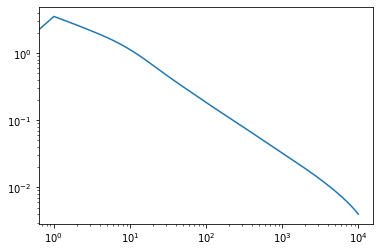

In [118]:
plt.loglog(np.max(ee) - scalings)

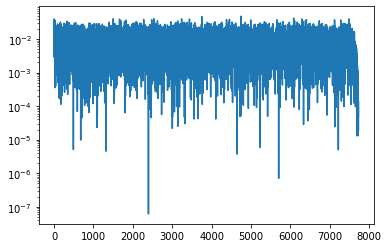

In [132]:
plt.semilogy(np.abs(u)[:-130])

In [133]:
ee[130:150]

array([-0.00311216, -0.00307472, -0.00304365, -0.0029946 , -0.00298447,
       -0.00289358, -0.00288065, -0.00286006, -0.00285241, -0.00277046,
       -0.00276137, -0.00272811, -0.00269927, -0.00266063, -0.00265032,
       -0.00261373, -0.00258351, -0.00254241, -0.0025251 , -0.00250625])

In [134]:
for k in range(100):
    u = ee * u
    scaling = np.linalg.norm(u)
    u = u / scaling
    print('k=', k, ', scaling=', scaling, 'np.max(ee)=', np.max(ee))

k= 0 , scaling= 0.058100990071995706 np.max(ee)= 11582.544111481851
k= 1 , scaling= 1.2026316992566464 np.max(ee)= 11582.544111481851
k= 2 , scaling= 2.381204544487519 np.max(ee)= 11582.544111481851
k= 3 , scaling= 3.473721455975933 np.max(ee)= 11582.544111481851
k= 4 , scaling= 4.526056268516953 np.max(ee)= 11582.544111481851
k= 5 , scaling= 5.709964369172358 np.max(ee)= 11582.544111481851
k= 6 , scaling= 7.087300913043264 np.max(ee)= 11582.544111481851
k= 7 , scaling= 8.454287766924553 np.max(ee)= 11582.544111481851
k= 8 , scaling= 9.619907258207347 np.max(ee)= 11582.544111481851
k= 9 , scaling= 10.604162306062175 np.max(ee)= 11582.544111481851
k= 10 , scaling= 11.515146476144656 np.max(ee)= 11582.544111481851
k= 11 , scaling= 12.49674911255606 np.max(ee)= 11582.544111481851
k= 12 , scaling= 13.733390290869087 np.max(ee)= 11582.544111481851
k= 13 , scaling= 15.333257356513965 np.max(ee)= 11582.544111481851
k= 14 , scaling= 17.11835009063044 np.max(ee)= 11582.544111481851
k= 15 , scal

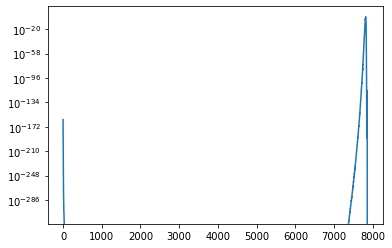

In [135]:
plt.semilogy(np.abs(u))

In [140]:
for k in range(10000):
    u = (np.max(ee) - ee) * u
    scaling = np.linalg.norm(u)
    u = u / scaling
    print('k=', k, ', scaling=', scaling, 'np.max(ee)=', np.max(ee))

k= 0 , scaling= 11482.87056813531 np.max(ee)= 11582.544111481851
k= 1 , scaling= 11482.879175799311 np.max(ee)= 11582.544111481851
k= 2 , scaling= 11482.887769121582 np.max(ee)= 11582.544111481851
k= 3 , scaling= 11482.896348114406 np.max(ee)= 11582.544111481851
k= 4 , scaling= 11482.904912790114 np.max(ee)= 11582.544111481851
k= 5 , scaling= 11482.913463161094 np.max(ee)= 11582.544111481851
k= 6 , scaling= 11482.921999239768 np.max(ee)= 11582.544111481851
k= 7 , scaling= 11482.930521038634 np.max(ee)= 11582.544111481851
k= 8 , scaling= 11482.939028570214 np.max(ee)= 11582.544111481851
k= 9 , scaling= 11482.947521847094 np.max(ee)= 11582.544111481851
k= 10 , scaling= 11482.956000881904 np.max(ee)= 11582.544111481851
k= 11 , scaling= 11482.964465687326 np.max(ee)= 11582.544111481851
k= 12 , scaling= 11482.972916276087 np.max(ee)= 11582.544111481851
k= 13 , scaling= 11482.981352660965 np.max(ee)= 11582.544111481851
k= 14 , scaling= 11482.989774854781 np.max(ee)= 11582.544111481851
k= 15 

k= 189 , scaling= 11484.25837195919 np.max(ee)= 11582.544111481851
k= 190 , scaling= 11484.264531031 np.max(ee)= 11582.544111481851
k= 191 , scaling= 11484.270678721308 np.max(ee)= 11582.544111481851
k= 192 , scaling= 11484.276815047888 np.max(ee)= 11582.544111481851
k= 193 , scaling= 11484.282940028515 np.max(ee)= 11582.544111481851
k= 194 , scaling= 11484.289053680983 np.max(ee)= 11582.544111481851
k= 195 , scaling= 11484.295156023092 np.max(ee)= 11582.544111481851
k= 196 , scaling= 11484.30124707265 np.max(ee)= 11582.544111481851
k= 197 , scaling= 11484.307326847476 np.max(ee)= 11582.544111481851
k= 198 , scaling= 11484.313395365392 np.max(ee)= 11582.544111481851
k= 199 , scaling= 11484.31945264424 np.max(ee)= 11582.544111481851
k= 200 , scaling= 11484.325498701859 np.max(ee)= 11582.544111481851
k= 201 , scaling= 11484.331533556107 np.max(ee)= 11582.544111481851
k= 202 , scaling= 11484.337557224837 np.max(ee)= 11582.544111481851
k= 203 , scaling= 11484.343569725921 np.max(ee)= 11582

k= 378 , scaling= 11485.240123688362 np.max(ee)= 11582.544111481851
k= 379 , scaling= 11485.244450532451 np.max(ee)= 11582.544111481851
k= 380 , scaling= 11485.248769369658 np.max(ee)= 11582.544111481851
k= 381 , scaling= 11485.253080217257 np.max(ee)= 11582.544111481851
k= 382 , scaling= 11485.257383092501 np.max(ee)= 11582.544111481851
k= 383 , scaling= 11485.261678012646 np.max(ee)= 11582.544111481851
k= 384 , scaling= 11485.265964994924 np.max(ee)= 11582.544111481851
k= 385 , scaling= 11485.270244056557 np.max(ee)= 11582.544111481851
k= 386 , scaling= 11485.27451521476 np.max(ee)= 11582.544111481851
k= 387 , scaling= 11485.278778486736 np.max(ee)= 11582.544111481851
k= 388 , scaling= 11485.283033889675 np.max(ee)= 11582.544111481851
k= 389 , scaling= 11485.287281440747 np.max(ee)= 11582.544111481851
k= 390 , scaling= 11485.291521157129 np.max(ee)= 11582.544111481851
k= 391 , scaling= 11485.295753055963 np.max(ee)= 11582.544111481851
k= 392 , scaling= 11485.2999771544 np.max(ee)= 11

k= 564 , scaling= 11485.924753414434 np.max(ee)= 11582.544111481851
k= 565 , scaling= 11485.92787406346 np.max(ee)= 11582.544111481851
k= 566 , scaling= 11485.930989682054 np.max(ee)= 11582.544111481851
k= 567 , scaling= 11485.934100284829 np.max(ee)= 11582.544111481851
k= 568 , scaling= 11485.937205886392 np.max(ee)= 11582.544111481851
k= 569 , scaling= 11485.940306501323 np.max(ee)= 11582.544111481851
k= 570 , scaling= 11485.943402144198 np.max(ee)= 11582.544111481851
k= 571 , scaling= 11485.946492829571 np.max(ee)= 11582.544111481851
k= 572 , scaling= 11485.949578571986 np.max(ee)= 11582.544111481851
k= 573 , scaling= 11485.952659385968 np.max(ee)= 11582.544111481851
k= 574 , scaling= 11485.955735286032 np.max(ee)= 11582.544111481851
k= 575 , scaling= 11485.95880628667 np.max(ee)= 11582.544111481851
k= 576 , scaling= 11485.96187240237 np.max(ee)= 11582.544111481851
k= 577 , scaling= 11485.964933647594 np.max(ee)= 11582.544111481851
k= 578 , scaling= 11485.9679900368 np.max(ee)= 1158

k= 765 , scaling= 11486.469444689003 np.max(ee)= 11582.544111481851
k= 766 , scaling= 11486.471829456184 np.max(ee)= 11582.544111481851
k= 767 , scaling= 11486.47421186051 np.max(ee)= 11582.544111481851
k= 768 , scaling= 11486.476591914112 np.max(ee)= 11582.544111481851
k= 769 , scaling= 11486.478969629097 np.max(ee)= 11582.544111481851
k= 770 , scaling= 11486.481345017573 np.max(ee)= 11582.544111481851
k= 771 , scaling= 11486.483718091627 np.max(ee)= 11582.544111481851
k= 772 , scaling= 11486.486088863358 np.max(ee)= 11582.544111481851
k= 773 , scaling= 11486.488457344834 np.max(ee)= 11582.544111481851
k= 774 , scaling= 11486.490823548129 np.max(ee)= 11582.544111481851
k= 775 , scaling= 11486.493187485303 np.max(ee)= 11582.544111481851
k= 776 , scaling= 11486.49554916841 np.max(ee)= 11582.544111481851
k= 777 , scaling= 11486.497908609488 np.max(ee)= 11582.544111481851
k= 778 , scaling= 11486.500265820578 np.max(ee)= 11582.544111481851
k= 779 , scaling= 11486.502620813702 np.max(ee)= 1

k= 973 , scaling= 11486.931996893942 np.max(ee)= 11582.544111481851
k= 974 , scaling= 11486.934141505499 np.max(ee)= 11582.544111481851
k= 975 , scaling= 11486.936286152828 np.max(ee)= 11582.544111481851
k= 976 , scaling= 11486.93843084722 np.max(ee)= 11582.544111481851
k= 977 , scaling= 11486.94057559996 np.max(ee)= 11582.544111481851
k= 978 , scaling= 11486.942720422328 np.max(ee)= 11582.544111481851
k= 979 , scaling= 11486.944865325611 np.max(ee)= 11582.544111481851
k= 980 , scaling= 11486.947010321095 np.max(ee)= 11582.544111481851
k= 981 , scaling= 11486.949155420078 np.max(ee)= 11582.544111481851
k= 982 , scaling= 11486.951300633835 np.max(ee)= 11582.544111481851
k= 983 , scaling= 11486.953445973671 np.max(ee)= 11582.544111481851
k= 984 , scaling= 11486.95559145087 np.max(ee)= 11582.544111481851
k= 985 , scaling= 11486.957737076726 np.max(ee)= 11582.544111481851
k= 986 , scaling= 11486.959882862542 np.max(ee)= 11582.544111481851
k= 987 , scaling= 11486.962028819607 np.max(ee)= 11

k= 1190 , scaling= 11487.417447119871 np.max(ee)= 11582.544111481851
k= 1191 , scaling= 11487.419870032505 np.max(ee)= 11582.544111481851
k= 1192 , scaling= 11487.422295534461 np.max(ee)= 11582.544111481851
k= 1193 , scaling= 11487.42472363835 np.max(ee)= 11582.544111481851
k= 1194 , scaling= 11487.427154356801 np.max(ee)= 11582.544111481851
k= 1195 , scaling= 11487.429587702447 np.max(ee)= 11582.544111481851
k= 1196 , scaling= 11487.432023687936 np.max(ee)= 11582.544111481851
k= 1197 , scaling= 11487.43446232593 np.max(ee)= 11582.544111481851
k= 1198 , scaling= 11487.43690362909 np.max(ee)= 11582.544111481851
k= 1199 , scaling= 11487.4393476101 np.max(ee)= 11582.544111481851
k= 1200 , scaling= 11487.44179428165 np.max(ee)= 11582.544111481851
k= 1201 , scaling= 11487.444243656446 np.max(ee)= 11582.544111481851
k= 1202 , scaling= 11487.446695747196 np.max(ee)= 11582.544111481851
k= 1203 , scaling= 11487.449150566626 np.max(ee)= 11582.544111481851
k= 1204 , scaling= 11487.45160812747 np.

k= 1373 , scaling= 11487.917172910484 np.max(ee)= 11582.544111481851
k= 1374 , scaling= 11487.920291943406 np.max(ee)= 11582.544111481851
k= 1375 , scaling= 11487.92341608221 np.max(ee)= 11582.544111481851
k= 1376 , scaling= 11487.926545341898 np.max(ee)= 11582.544111481851
k= 1377 , scaling= 11487.929679737495 np.max(ee)= 11582.544111481851
k= 1378 , scaling= 11487.932819284024 np.max(ee)= 11582.544111481851
k= 1379 , scaling= 11487.935963996539 np.max(ee)= 11582.544111481851
k= 1380 , scaling= 11487.939113890094 np.max(ee)= 11582.544111481851
k= 1381 , scaling= 11487.942268979767 np.max(ee)= 11582.544111481851
k= 1382 , scaling= 11487.94542928065 np.max(ee)= 11582.544111481851
k= 1383 , scaling= 11487.948594807835 np.max(ee)= 11582.544111481851
k= 1384 , scaling= 11487.951765576445 np.max(ee)= 11582.544111481851
k= 1385 , scaling= 11487.954941601609 np.max(ee)= 11582.544111481851
k= 1386 , scaling= 11487.958122898468 np.max(ee)= 11582.544111481851
k= 1387 , scaling= 11487.96130948218

k= 1583 , scaling= 11488.708072849497 np.max(ee)= 11582.544111481851
k= 1584 , scaling= 11488.712612541514 np.max(ee)= 11582.544111481851
k= 1585 , scaling= 11488.717160747825 np.max(ee)= 11582.544111481851
k= 1586 , scaling= 11488.72171748544 np.max(ee)= 11582.544111481851
k= 1587 , scaling= 11488.72628277138 np.max(ee)= 11582.544111481851
k= 1588 , scaling= 11488.73085662267 np.max(ee)= 11582.544111481851
k= 1589 , scaling= 11488.735439056318 np.max(ee)= 11582.544111481851
k= 1590 , scaling= 11488.740030089351 np.max(ee)= 11582.544111481851
k= 1591 , scaling= 11488.744629738787 np.max(ee)= 11582.544111481851
k= 1592 , scaling= 11488.74923802165 np.max(ee)= 11582.544111481851
k= 1593 , scaling= 11488.753854954952 np.max(ee)= 11582.544111481851
k= 1594 , scaling= 11488.758480555722 np.max(ee)= 11582.544111481851
k= 1595 , scaling= 11488.763114840973 np.max(ee)= 11582.544111481851
k= 1596 , scaling= 11488.767757827727 np.max(ee)= 11582.544111481851
k= 1597 , scaling= 11488.772409533 np.

k= 1773 , scaling= 11489.742368266685 np.max(ee)= 11582.544111481851
k= 1774 , scaling= 11489.748823509963 np.max(ee)= 11582.544111481851
k= 1775 , scaling= 11489.755290321886 np.max(ee)= 11582.544111481851
k= 1776 , scaling= 11489.761768716293 np.max(ee)= 11582.544111481851
k= 1777 , scaling= 11489.76825870699 np.max(ee)= 11582.544111481851
k= 1778 , scaling= 11489.774760307735 np.max(ee)= 11582.544111481851
k= 1779 , scaling= 11489.781273532255 np.max(ee)= 11582.544111481851
k= 1780 , scaling= 11489.787798394225 np.max(ee)= 11582.544111481851
k= 1781 , scaling= 11489.794334907288 np.max(ee)= 11582.544111481851
k= 1782 , scaling= 11489.800883085047 np.max(ee)= 11582.544111481851
k= 1783 , scaling= 11489.807442941054 np.max(ee)= 11582.544111481851
k= 1784 , scaling= 11489.81401448883 np.max(ee)= 11582.544111481851
k= 1785 , scaling= 11489.820597741842 np.max(ee)= 11582.544111481851
k= 1786 , scaling= 11489.827192713536 np.max(ee)= 11582.544111481851
k= 1787 , scaling= 11489.83379941729

k= 1995 , scaling= 11491.478893085707 np.max(ee)= 11582.544111481851
k= 1996 , scaling= 11491.488154116812 np.max(ee)= 11582.544111481851
k= 1997 , scaling= 11491.497428250563 np.max(ee)= 11582.544111481851
k= 1998 , scaling= 11491.506715484216 np.max(ee)= 11582.544111481851
k= 1999 , scaling= 11491.516015814905 np.max(ee)= 11582.544111481851
k= 2000 , scaling= 11491.525329239654 np.max(ee)= 11582.544111481851
k= 2001 , scaling= 11491.534655755386 np.max(ee)= 11582.544111481851
k= 2002 , scaling= 11491.543995358903 np.max(ee)= 11582.544111481851
k= 2003 , scaling= 11491.553348046902 np.max(ee)= 11582.544111481851
k= 2004 , scaling= 11491.56271381597 np.max(ee)= 11582.544111481851
k= 2005 , scaling= 11491.572092662578 np.max(ee)= 11582.544111481851
k= 2006 , scaling= 11491.581484583094 np.max(ee)= 11582.544111481851
k= 2007 , scaling= 11491.590889573761 np.max(ee)= 11582.544111481851
k= 2008 , scaling= 11491.60030763072 np.max(ee)= 11582.544111481851
k= 2009 , scaling= 11491.60973875000

k= 2204 , scaling= 11493.685992420294 np.max(ee)= 11582.544111481851
k= 2205 , scaling= 11493.697752716662 np.max(ee)= 11582.544111481851
k= 2206 , scaling= 11493.709522902394 np.max(ee)= 11582.544111481851
k= 2207 , scaling= 11493.721302949027 np.max(ee)= 11582.544111481851
k= 2208 , scaling= 11493.73309282798 np.max(ee)= 11582.544111481851
k= 2209 , scaling= 11493.744892510555 np.max(ee)= 11582.544111481851
k= 2210 , scaling= 11493.756701967934 np.max(ee)= 11582.544111481851
k= 2211 , scaling= 11493.76852117119 np.max(ee)= 11582.544111481851
k= 2212 , scaling= 11493.780350091267 np.max(ee)= 11582.544111481851
k= 2213 , scaling= 11493.792188699003 np.max(ee)= 11582.544111481851
k= 2214 , scaling= 11493.804036965113 np.max(ee)= 11582.544111481851
k= 2215 , scaling= 11493.815894860203 np.max(ee)= 11582.544111481851
k= 2216 , scaling= 11493.827762354758 np.max(ee)= 11582.544111481851
k= 2217 , scaling= 11493.83963941915 np.max(ee)= 11582.544111481851
k= 2218 , scaling= 11493.851526023629

k= 2373 , scaling= 11495.787890380887 np.max(ee)= 11582.544111481851
k= 2374 , scaling= 11495.80083671807 np.max(ee)= 11582.544111481851
k= 2375 , scaling= 11495.813786767718 np.max(ee)= 11582.544111481851
k= 2376 , scaling= 11495.826740487484 np.max(ee)= 11582.544111481851
k= 2377 , scaling= 11495.839697835008 np.max(ee)= 11582.544111481851
k= 2378 , scaling= 11495.852658767892 np.max(ee)= 11582.544111481851
k= 2379 , scaling= 11495.865623243699 np.max(ee)= 11582.544111481851
k= 2380 , scaling= 11495.878591219964 np.max(ee)= 11582.544111481851
k= 2381 , scaling= 11495.891562654198 np.max(ee)= 11582.544111481851
k= 2382 , scaling= 11495.90453750387 np.max(ee)= 11582.544111481851
k= 2383 , scaling= 11495.917515726425 np.max(ee)= 11582.544111481851
k= 2384 , scaling= 11495.93049727928 np.max(ee)= 11582.544111481851
k= 2385 , scaling= 11495.943482119817 np.max(ee)= 11582.544111481851
k= 2386 , scaling= 11495.956470205398 np.max(ee)= 11582.544111481851
k= 2387 , scaling= 11495.969461493356

k= 2550 , scaling= 11498.098354590691 np.max(ee)= 11582.544111481851
k= 2551 , scaling= 11498.111295026512 np.max(ee)= 11582.544111481851
k= 2552 , scaling= 11498.124231776295 np.max(ee)= 11582.544111481851
k= 2553 , scaling= 11498.137164802249 np.max(ee)= 11582.544111481851
k= 2554 , scaling= 11498.150094066668 np.max(ee)= 11582.544111481851
k= 2555 , scaling= 11498.163019531932 np.max(ee)= 11582.544111481851
k= 2556 , scaling= 11498.175941160496 np.max(ee)= 11582.544111481851
k= 2557 , scaling= 11498.188858914902 np.max(ee)= 11582.544111481851
k= 2558 , scaling= 11498.201772757771 np.max(ee)= 11582.544111481851
k= 2559 , scaling= 11498.214682651813 np.max(ee)= 11582.544111481851
k= 2560 , scaling= 11498.227588559821 np.max(ee)= 11582.544111481851
k= 2561 , scaling= 11498.240490444668 np.max(ee)= 11582.544111481851
k= 2562 , scaling= 11498.253388269317 np.max(ee)= 11582.544111481851
k= 2563 , scaling= 11498.266281996815 np.max(ee)= 11582.544111481851
k= 2564 , scaling= 11498.279171590

k= 2759 , scaling= 11500.673689745105 np.max(ee)= 11582.544111481851
k= 2760 , scaling= 11500.685190433525 np.max(ee)= 11582.544111481851
k= 2761 , scaling= 11500.696681841611 np.max(ee)= 11582.544111481851
k= 2762 , scaling= 11500.708163955178 np.max(ee)= 11582.544111481851
k= 2763 , scaling= 11500.719636760163 np.max(ee)= 11582.544111481851
k= 2764 , scaling= 11500.731100242623 np.max(ee)= 11582.544111481851
k= 2765 , scaling= 11500.74255438874 np.max(ee)= 11582.544111481851
k= 2766 , scaling= 11500.753999184815 np.max(ee)= 11582.544111481851
k= 2767 , scaling= 11500.765434617277 np.max(ee)= 11582.544111481851
k= 2768 , scaling= 11500.776860672671 np.max(ee)= 11582.544111481851
k= 2769 , scaling= 11500.788277337662 np.max(ee)= 11582.544111481851
k= 2770 , scaling= 11500.79968459905 np.max(ee)= 11582.544111481851
k= 2771 , scaling= 11500.811082443737 np.max(ee)= 11582.544111481851
k= 2772 , scaling= 11500.822470858764 np.max(ee)= 11582.544111481851
k= 2773 , scaling= 11500.83384983128

k= 2979 , scaling= 11502.966321157728 np.max(ee)= 11582.544111481851
k= 2980 , scaling= 11502.975634189204 np.max(ee)= 11582.544111481851
k= 2981 , scaling= 11502.984937396697 np.max(ee)= 11582.544111481851
k= 2982 , scaling= 11502.994230787244 np.max(ee)= 11582.544111481851
k= 2983 , scaling= 11503.003514367936 np.max(ee)= 11582.544111481851
k= 2984 , scaling= 11503.012788145934 np.max(ee)= 11582.544111481851
k= 2985 , scaling= 11503.022052128452 np.max(ee)= 11582.544111481851
k= 2986 , scaling= 11503.031306322766 np.max(ee)= 11582.544111481851
k= 2987 , scaling= 11503.040550736216 np.max(ee)= 11582.544111481851
k= 2988 , scaling= 11503.049785376204 np.max(ee)= 11582.544111481851
k= 2989 , scaling= 11503.059010250181 np.max(ee)= 11582.544111481851
k= 2990 , scaling= 11503.068225365669 np.max(ee)= 11582.544111481851
k= 2991 , scaling= 11503.077430730242 np.max(ee)= 11582.544111481851
k= 2992 , scaling= 11503.08662635153 np.max(ee)= 11582.544111481851
k= 2993 , scaling= 11503.0958122372

k= 3186 , scaling= 11504.698498998516 np.max(ee)= 11582.544111481851
k= 3187 , scaling= 11504.705994116412 np.max(ee)= 11582.544111481851
k= 3188 , scaling= 11504.713481716311 np.max(ee)= 11582.544111481851
k= 3189 , scaling= 11504.720961811445 np.max(ee)= 11582.544111481851
k= 3190 , scaling= 11504.728434415056 np.max(ee)= 11582.544111481851
k= 3191 , scaling= 11504.735899540383 np.max(ee)= 11582.544111481851
k= 3192 , scaling= 11504.743357200672 np.max(ee)= 11582.544111481851
k= 3193 , scaling= 11504.750807409167 np.max(ee)= 11582.544111481851
k= 3194 , scaling= 11504.75825017912 np.max(ee)= 11582.544111481851
k= 3195 , scaling= 11504.765685523778 np.max(ee)= 11582.544111481851
k= 3196 , scaling= 11504.773113456396 np.max(ee)= 11582.544111481851
k= 3197 , scaling= 11504.780533990226 np.max(ee)= 11582.544111481851
k= 3198 , scaling= 11504.78794713853 np.max(ee)= 11582.544111481851
k= 3199 , scaling= 11504.795352914556 np.max(ee)= 11582.544111481851
k= 3200 , scaling= 11504.80275133157

k= 3384 , scaling= 11506.052550264381 np.max(ee)= 11582.544111481851
k= 3385 , scaling= 11506.058808538934 np.max(ee)= 11582.544111481851
k= 3386 , scaling= 11506.06506177459 np.max(ee)= 11582.544111481851
k= 3387 , scaling= 11506.071309982372 np.max(ee)= 11582.544111481851
k= 3388 , scaling= 11506.07755317328 np.max(ee)= 11582.544111481851
k= 3389 , scaling= 11506.08379135828 np.max(ee)= 11582.544111481851
k= 3390 , scaling= 11506.090024548339 np.max(ee)= 11582.544111481851
k= 3391 , scaling= 11506.096252754382 np.max(ee)= 11582.544111481851
k= 3392 , scaling= 11506.102475987334 np.max(ee)= 11582.544111481851
k= 3393 , scaling= 11506.108694258084 np.max(ee)= 11582.544111481851
k= 3394 , scaling= 11506.114907577497 np.max(ee)= 11582.544111481851
k= 3395 , scaling= 11506.121115956435 np.max(ee)= 11582.544111481851
k= 3396 , scaling= 11506.127319405727 np.max(ee)= 11582.544111481851
k= 3397 , scaling= 11506.133517936176 np.max(ee)= 11582.544111481851
k= 3398 , scaling= 11506.139711558577

k= 3590 , scaling= 11507.249577179535 np.max(ee)= 11582.544111481851
k= 3591 , scaling= 11507.254998264107 np.max(ee)= 11582.544111481851
k= 3592 , scaling= 11507.260416106836 np.max(ee)= 11582.544111481851
k= 3593 , scaling= 11507.265830714088 np.max(ee)= 11582.544111481851
k= 3594 , scaling= 11507.271242092216 np.max(ee)= 11582.544111481851
k= 3595 , scaling= 11507.276650247542 np.max(ee)= 11582.544111481851
k= 3596 , scaling= 11507.282055186372 np.max(ee)= 11582.544111481851
k= 3597 , scaling= 11507.287456914983 np.max(ee)= 11582.544111481851
k= 3598 , scaling= 11507.292855439639 np.max(ee)= 11582.544111481851
k= 3599 , scaling= 11507.298250766575 np.max(ee)= 11582.544111481851
k= 3600 , scaling= 11507.30364290201 np.max(ee)= 11582.544111481851
k= 3601 , scaling= 11507.309031852135 np.max(ee)= 11582.544111481851
k= 3602 , scaling= 11507.314417623127 np.max(ee)= 11582.544111481851
k= 3603 , scaling= 11507.319800221134 np.max(ee)= 11582.544111481851
k= 3604 , scaling= 11507.3251796522

k= 3802 , scaling= 11508.334621631264 np.max(ee)= 11582.544111481851
k= 3803 , scaling= 11508.339466137231 np.max(ee)= 11582.544111481851
k= 3804 , scaling= 11508.344308312404 np.max(ee)= 11582.544111481851
k= 3805 , scaling= 11508.34914815927 np.max(ee)= 11582.544111481851
k= 3806 , scaling= 11508.353985680315 np.max(ee)= 11582.544111481851
k= 3807 , scaling= 11508.358820878006 np.max(ee)= 11582.544111481851
k= 3808 , scaling= 11508.363653754786 np.max(ee)= 11582.544111481851
k= 3809 , scaling= 11508.368484313107 np.max(ee)= 11582.544111481851
k= 3810 , scaling= 11508.373312555386 np.max(ee)= 11582.544111481851
k= 3811 , scaling= 11508.378138484035 np.max(ee)= 11582.544111481851
k= 3812 , scaling= 11508.38296210146 np.max(ee)= 11582.544111481851
k= 3813 , scaling= 11508.387783410031 np.max(ee)= 11582.544111481851
k= 3814 , scaling= 11508.392602412128 np.max(ee)= 11582.544111481851
k= 3815 , scaling= 11508.397419110106 np.max(ee)= 11582.544111481851
k= 3816 , scaling= 11508.40223350631

k= 4020 , scaling= 11509.338733746989 np.max(ee)= 11582.544111481851
k= 4021 , scaling= 11509.343109314632 np.max(ee)= 11582.544111481851
k= 4022 , scaling= 11509.347482837882 np.max(ee)= 11582.544111481851
k= 4023 , scaling= 11509.351854317194 np.max(ee)= 11582.544111481851
k= 4024 , scaling= 11509.356223752997 np.max(ee)= 11582.544111481851
k= 4025 , scaling= 11509.360591145736 np.max(ee)= 11582.544111481851
k= 4026 , scaling= 11509.364956495838 np.max(ee)= 11582.544111481851
k= 4027 , scaling= 11509.369319803727 np.max(ee)= 11582.544111481851
k= 4028 , scaling= 11509.373681069828 np.max(ee)= 11582.544111481851
k= 4029 , scaling= 11509.378040294558 np.max(ee)= 11582.544111481851
k= 4030 , scaling= 11509.382397478319 np.max(ee)= 11582.544111481851
k= 4031 , scaling= 11509.38675262153 np.max(ee)= 11582.544111481851
k= 4032 , scaling= 11509.391105724579 np.max(ee)= 11582.544111481851
k= 4033 , scaling= 11509.39545678787 np.max(ee)= 11582.544111481851
k= 4034 , scaling= 11509.39980581179

k= 4234 , scaling= 11510.228908590774 np.max(ee)= 11582.544111481851
k= 4235 , scaling= 11510.232851244129 np.max(ee)= 11582.544111481851
k= 4236 , scaling= 11510.236791881178 np.max(ee)= 11582.544111481851
k= 4237 , scaling= 11510.240730501942 np.max(ee)= 11582.544111481851
k= 4238 , scaling= 11510.244667106444 np.max(ee)= 11582.544111481851
k= 4239 , scaling= 11510.248601694697 np.max(ee)= 11582.544111481851
k= 4240 , scaling= 11510.252534266727 np.max(ee)= 11582.544111481851
k= 4241 , scaling= 11510.256464822553 np.max(ee)= 11582.544111481851
k= 4242 , scaling= 11510.260393362198 np.max(ee)= 11582.544111481851
k= 4243 , scaling= 11510.264319885682 np.max(ee)= 11582.544111481851
k= 4244 , scaling= 11510.268244393033 np.max(ee)= 11582.544111481851
k= 4245 , scaling= 11510.27216688427 np.max(ee)= 11582.544111481851
k= 4246 , scaling= 11510.276087359422 np.max(ee)= 11582.544111481851
k= 4247 , scaling= 11510.28000581851 np.max(ee)= 11582.544111481851
k= 4248 , scaling= 11510.28392226156

k= 4448 , scaling= 11511.02681981576 np.max(ee)= 11582.544111481851
k= 4449 , scaling= 11511.03033366611 np.max(ee)= 11582.544111481851
k= 4450 , scaling= 11511.033845541275 np.max(ee)= 11582.544111481851
k= 4451 , scaling= 11511.037355441698 np.max(ee)= 11582.544111481851
k= 4452 , scaling= 11511.040863367849 np.max(ee)= 11582.544111481851
k= 4453 , scaling= 11511.044369320178 np.max(ee)= 11582.544111481851
k= 4454 , scaling= 11511.047873299145 np.max(ee)= 11582.544111481851
k= 4455 , scaling= 11511.051375305222 np.max(ee)= 11582.544111481851
k= 4456 , scaling= 11511.054875338874 np.max(ee)= 11582.544111481851
k= 4457 , scaling= 11511.058373400572 np.max(ee)= 11582.544111481851
k= 4458 , scaling= 11511.06186949079 np.max(ee)= 11582.544111481851
k= 4459 , scaling= 11511.065363610005 np.max(ee)= 11582.544111481851
k= 4460 , scaling= 11511.0688557587 np.max(ee)= 11582.544111481851
k= 4461 , scaling= 11511.072345937355 np.max(ee)= 11582.544111481851
k= 4462 , scaling= 11511.075834146455 n

k= 4637 , scaling= 11511.656509073444 np.max(ee)= 11582.544111481851
k= 4638 , scaling= 11511.659661147676 np.max(ee)= 11582.544111481851
k= 4639 , scaling= 11511.662811388738 np.max(ee)= 11582.544111481851
k= 4640 , scaling= 11511.665959797683 np.max(ee)= 11582.544111481851
k= 4641 , scaling= 11511.669106375588 np.max(ee)= 11582.544111481851
k= 4642 , scaling= 11511.672251123504 np.max(ee)= 11582.544111481851
k= 4643 , scaling= 11511.675394042504 np.max(ee)= 11582.544111481851
k= 4644 , scaling= 11511.678535133664 np.max(ee)= 11582.544111481851
k= 4645 , scaling= 11511.681674398053 np.max(ee)= 11582.544111481851
k= 4646 , scaling= 11511.684811836754 np.max(ee)= 11582.544111481851
k= 4647 , scaling= 11511.687947450842 np.max(ee)= 11582.544111481851
k= 4648 , scaling= 11511.69108124141 np.max(ee)= 11582.544111481851
k= 4649 , scaling= 11511.69421320954 np.max(ee)= 11582.544111481851
k= 4650 , scaling= 11511.69734335632 np.max(ee)= 11582.544111481851
k= 4651 , scaling= 11511.700471682852

k= 4817 , scaling= 11512.195493922825 np.max(ee)= 11582.544111481851
k= 4818 , scaling= 11512.19833603558 np.max(ee)= 11582.544111481851
k= 4819 , scaling= 11512.201176554729 np.max(ee)= 11582.544111481851
k= 4820 , scaling= 11512.20401548185 np.max(ee)= 11582.544111481851
k= 4821 , scaling= 11512.206852818543 np.max(ee)= 11582.544111481851
k= 4822 , scaling= 11512.209688566389 np.max(ee)= 11582.544111481851
k= 4823 , scaling= 11512.212522726995 np.max(ee)= 11582.544111481851
k= 4824 , scaling= 11512.21535530195 np.max(ee)= 11582.544111481851
k= 4825 , scaling= 11512.218186292865 np.max(ee)= 11582.544111481851
k= 4826 , scaling= 11512.221015701332 np.max(ee)= 11582.544111481851
k= 4827 , scaling= 11512.223843528964 np.max(ee)= 11582.544111481851
k= 4828 , scaling= 11512.226669777365 np.max(ee)= 11582.544111481851
k= 4829 , scaling= 11512.22949444815 np.max(ee)= 11582.544111481851
k= 4830 , scaling= 11512.232317542932 np.max(ee)= 11582.544111481851
k= 4831 , scaling= 11512.235139063321 

k= 4977 , scaling= 11512.63108992139 np.max(ee)= 11582.544111481851
k= 4978 , scaling= 11512.633698887452 np.max(ee)= 11582.544111481851
k= 4979 , scaling= 11512.636306544295 np.max(ee)= 11582.544111481851
k= 4980 , scaling= 11512.638912893866 np.max(ee)= 11582.544111481851
k= 4981 , scaling= 11512.641517938126 np.max(ee)= 11582.544111481851
k= 4982 , scaling= 11512.644121679023 np.max(ee)= 11582.544111481851
k= 4983 , scaling= 11512.646724118524 np.max(ee)= 11582.544111481851
k= 4984 , scaling= 11512.649325258579 np.max(ee)= 11582.544111481851
k= 4985 , scaling= 11512.651925101158 np.max(ee)= 11582.544111481851
k= 4986 , scaling= 11512.65452364822 np.max(ee)= 11582.544111481851
k= 4987 , scaling= 11512.657120901735 np.max(ee)= 11582.544111481851
k= 4988 , scaling= 11512.659716863667 np.max(ee)= 11582.544111481851
k= 4989 , scaling= 11512.662311535989 np.max(ee)= 11582.544111481851
k= 4990 , scaling= 11512.664904920668 np.max(ee)= 11582.544111481851
k= 4991 , scaling= 11512.66749701968

k= 5167 , scaling= 11513.105579165427 np.max(ee)= 11582.544111481851
k= 5168 , scaling= 11513.10797645463 np.max(ee)= 11582.544111481851
k= 5169 , scaling= 11513.110372836945 np.max(ee)= 11582.544111481851
k= 5170 , scaling= 11513.11276831464 np.max(ee)= 11582.544111481851
k= 5171 , scaling= 11513.115162889986 np.max(ee)= 11582.544111481851
k= 5172 , scaling= 11513.11755656525 np.max(ee)= 11582.544111481851
k= 5173 , scaling= 11513.119949342707 np.max(ee)= 11582.544111481851
k= 5174 , scaling= 11513.122341224627 np.max(ee)= 11582.544111481851
k= 5175 , scaling= 11513.124732213284 np.max(ee)= 11582.544111481851
k= 5176 , scaling= 11513.127122310954 np.max(ee)= 11582.544111481851
k= 5177 , scaling= 11513.12951151992 np.max(ee)= 11582.544111481851
k= 5178 , scaling= 11513.131899842452 np.max(ee)= 11582.544111481851
k= 5179 , scaling= 11513.134287280833 np.max(ee)= 11582.544111481851
k= 5180 , scaling= 11513.136673837345 np.max(ee)= 11582.544111481851
k= 5181 , scaling= 11513.139059514271 

k= 5361 , scaling= 11513.556469490959 np.max(ee)= 11582.544111481851
k= 5362 , scaling= 11513.558734899167 np.max(ee)= 11582.544111481851
k= 5363 , scaling= 11513.560999865154 np.max(ee)= 11582.544111481851
k= 5364 , scaling= 11513.563264391445 np.max(ee)= 11582.544111481851
k= 5365 , scaling= 11513.565528480563 np.max(ee)= 11582.544111481851
k= 5366 , scaling= 11513.56779213502 np.max(ee)= 11582.544111481851
k= 5367 , scaling= 11513.570055357344 np.max(ee)= 11582.544111481851
k= 5368 , scaling= 11513.57231815006 np.max(ee)= 11582.544111481851
k= 5369 , scaling= 11513.574580515691 np.max(ee)= 11582.544111481851
k= 5370 , scaling= 11513.576842456763 np.max(ee)= 11582.544111481851
k= 5371 , scaling= 11513.579103975804 np.max(ee)= 11582.544111481851
k= 5372 , scaling= 11513.581365075343 np.max(ee)= 11582.544111481851
k= 5373 , scaling= 11513.583625757914 np.max(ee)= 11582.544111481851
k= 5374 , scaling= 11513.585886026041 np.max(ee)= 11582.544111481851
k= 5375 , scaling= 11513.58814588226

k= 5582 , scaling= 11514.050966167344 np.max(ee)= 11582.544111481851
k= 5583 , scaling= 11514.053197322683 np.max(ee)= 11582.544111481851
k= 5584 , scaling= 11514.055428623482 np.max(ee)= 11582.544111481851
k= 5585 , scaling= 11514.057660072553 np.max(ee)= 11582.544111481851
k= 5586 , scaling= 11514.059891672701 np.max(ee)= 11582.544111481851
k= 5587 , scaling= 11514.062123426735 np.max(ee)= 11582.544111481851
k= 5588 , scaling= 11514.064355337463 np.max(ee)= 11582.544111481851
k= 5589 , scaling= 11514.066587407706 np.max(ee)= 11582.544111481851
k= 5590 , scaling= 11514.06881964027 np.max(ee)= 11582.544111481851
k= 5591 , scaling= 11514.071052037974 np.max(ee)= 11582.544111481851
k= 5592 , scaling= 11514.073284603632 np.max(ee)= 11582.544111481851
k= 5593 , scaling= 11514.075517340063 np.max(ee)= 11582.544111481851
k= 5594 , scaling= 11514.077750250086 np.max(ee)= 11582.544111481851
k= 5595 , scaling= 11514.079983336524 np.max(ee)= 11582.544111481851
k= 5596 , scaling= 11514.0822166021

k= 5783 , scaling= 11514.5061892381 np.max(ee)= 11582.544111481851
k= 5784 , scaling= 11514.508507974024 np.max(ee)= 11582.544111481851
k= 5785 , scaling= 11514.51082744888 np.max(ee)= 11582.544111481851
k= 5786 , scaling= 11514.513147665772 np.max(ee)= 11582.544111481851
k= 5787 , scaling= 11514.5154686278 np.max(ee)= 11582.544111481851
k= 5788 , scaling= 11514.517790338085 np.max(ee)= 11582.544111481851
k= 5789 , scaling= 11514.520112799717 np.max(ee)= 11582.544111481851
k= 5790 , scaling= 11514.52243601582 np.max(ee)= 11582.544111481851
k= 5791 , scaling= 11514.524759989503 np.max(ee)= 11582.544111481851
k= 5792 , scaling= 11514.527084723875 np.max(ee)= 11582.544111481851
k= 5793 , scaling= 11514.529410222058 np.max(ee)= 11582.544111481851
k= 5794 , scaling= 11514.531736487159 np.max(ee)= 11582.544111481851
k= 5795 , scaling= 11514.534063522302 np.max(ee)= 11582.544111481851
k= 5796 , scaling= 11514.536391330608 np.max(ee)= 11582.544111481851
k= 5797 , scaling= 11514.538719915192 np

k= 5970 , scaling= 11514.956045998206 np.max(ee)= 11582.544111481851
k= 5971 , scaling= 11514.958558479371 np.max(ee)= 11582.544111481851
k= 5972 , scaling= 11514.961072305134 np.max(ee)= 11582.544111481851
k= 5973 , scaling= 11514.963587478855 np.max(ee)= 11582.544111481851
k= 5974 , scaling= 11514.966104003894 np.max(ee)= 11582.544111481851
k= 5975 , scaling= 11514.968621883625 np.max(ee)= 11582.544111481851
k= 5976 , scaling= 11514.971141121405 np.max(ee)= 11582.544111481851
k= 5977 , scaling= 11514.973661720607 np.max(ee)= 11582.544111481851
k= 5978 , scaling= 11514.976183684597 np.max(ee)= 11582.544111481851
k= 5979 , scaling= 11514.97870701675 np.max(ee)= 11582.544111481851
k= 5980 , scaling= 11514.98123172043 np.max(ee)= 11582.544111481851
k= 5981 , scaling= 11514.98375779901 np.max(ee)= 11582.544111481851
k= 5982 , scaling= 11514.986285255867 np.max(ee)= 11582.544111481851
k= 5983 , scaling= 11514.988814094368 np.max(ee)= 11582.544111481851
k= 5984 , scaling= 11514.991344317898

k= 6153 , scaling= 11515.4416422832 np.max(ee)= 11582.544111481851
k= 6154 , scaling= 11515.444457697764 np.max(ee)= 11582.544111481851
k= 6155 , scaling= 11515.447275084965 np.max(ee)= 11582.544111481851
k= 6156 , scaling= 11515.45009444826 np.max(ee)= 11582.544111481851
k= 6157 , scaling= 11515.452915791107 np.max(ee)= 11582.544111481851
k= 6158 , scaling= 11515.455739116966 np.max(ee)= 11582.544111481851
k= 6159 , scaling= 11515.45856442929 np.max(ee)= 11582.544111481851
k= 6160 , scaling= 11515.461391731544 np.max(ee)= 11582.544111481851
k= 6161 , scaling= 11515.464221027176 np.max(ee)= 11582.544111481851
k= 6162 , scaling= 11515.467052319642 np.max(ee)= 11582.544111481851
k= 6163 , scaling= 11515.469885612405 np.max(ee)= 11582.544111481851
k= 6164 , scaling= 11515.472720908918 np.max(ee)= 11582.544111481851
k= 6165 , scaling= 11515.475558212633 np.max(ee)= 11582.544111481851
k= 6166 , scaling= 11515.478397527007 np.max(ee)= 11582.544111481851
k= 6167 , scaling= 11515.481238855495 

k= 6365 , scaling= 11516.08797362431 np.max(ee)= 11582.544111481851
k= 6366 , scaling= 11516.09128297562 np.max(ee)= 11582.544111481851
k= 6367 , scaling= 11516.094595003391 np.max(ee)= 11582.544111481851
k= 6368 , scaling= 11516.097909710674 np.max(ee)= 11582.544111481851
k= 6369 , scaling= 11516.101227100511 np.max(ee)= 11582.544111481851
k= 6370 , scaling= 11516.104547175953 np.max(ee)= 11582.544111481851
k= 6371 , scaling= 11516.10786994004 np.max(ee)= 11582.544111481851
k= 6372 , scaling= 11516.111195395799 np.max(ee)= 11582.544111481851
k= 6373 , scaling= 11516.11452354627 np.max(ee)= 11582.544111481851
k= 6374 , scaling= 11516.11785439448 np.max(ee)= 11582.544111481851
k= 6375 , scaling= 11516.121187943452 np.max(ee)= 11582.544111481851
k= 6376 , scaling= 11516.1245241962 np.max(ee)= 11582.544111481851
k= 6377 , scaling= 11516.127863155749 np.max(ee)= 11582.544111481851
k= 6378 , scaling= 11516.131204825104 np.max(ee)= 11582.544111481851
k= 6379 , scaling= 11516.134549207272 np.

k= 6575 , scaling= 11516.845926136057 np.max(ee)= 11582.544111481851
k= 6576 , scaling= 11516.849856572075 np.max(ee)= 11582.544111481851
k= 6577 , scaling= 11516.85379020063 np.max(ee)= 11582.544111481851
k= 6578 , scaling= 11516.857727023373 np.max(ee)= 11582.544111481851
k= 6579 , scaling= 11516.861667041952 np.max(ee)= 11582.544111481851
k= 6580 , scaling= 11516.865610258006 np.max(ee)= 11582.544111481851
k= 6581 , scaling= 11516.869556673155 np.max(ee)= 11582.544111481851
k= 6582 , scaling= 11516.873506289023 np.max(ee)= 11582.544111481851
k= 6583 , scaling= 11516.877459107212 np.max(ee)= 11582.544111481851
k= 6584 , scaling= 11516.88141512932 np.max(ee)= 11582.544111481851
k= 6585 , scaling= 11516.885374356936 np.max(ee)= 11582.544111481851
k= 6586 , scaling= 11516.889336791644 np.max(ee)= 11582.544111481851
k= 6587 , scaling= 11516.893302434997 np.max(ee)= 11582.544111481851
k= 6588 , scaling= 11516.897271288562 np.max(ee)= 11582.544111481851
k= 6589 , scaling= 11516.90124335388

k= 6778 , scaling= 11517.710789806364 np.max(ee)= 11582.544111481851
k= 6779 , scaling= 11517.715386940146 np.max(ee)= 11582.544111481851
k= 6780 , scaling= 11517.71998736345 np.max(ee)= 11582.544111481851
k= 6781 , scaling= 11517.724591075372 np.max(ee)= 11582.544111481851
k= 6782 , scaling= 11517.729198074983 np.max(ee)= 11582.544111481851
k= 6783 , scaling= 11517.73380836134 np.max(ee)= 11582.544111481851
k= 6784 , scaling= 11517.738421933489 np.max(ee)= 11582.544111481851
k= 6785 , scaling= 11517.743038790457 np.max(ee)= 11582.544111481851
k= 6786 , scaling= 11517.747658931256 np.max(ee)= 11582.544111481851
k= 6787 , scaling= 11517.75228235488 np.max(ee)= 11582.544111481851
k= 6788 , scaling= 11517.756909060321 np.max(ee)= 11582.544111481851
k= 6789 , scaling= 11517.76153904653 np.max(ee)= 11582.544111481851
k= 6790 , scaling= 11517.76617231247 np.max(ee)= 11582.544111481851
k= 6791 , scaling= 11517.770808857067 np.max(ee)= 11582.544111481851
k= 6792 , scaling= 11517.775448679246 n

k= 6991 , scaling= 11518.761450770126 np.max(ee)= 11582.544111481851
k= 6992 , scaling= 11518.766701969771 np.max(ee)= 11582.544111481851
k= 6993 , scaling= 11518.77195588925 np.max(ee)= 11582.544111481851
k= 6994 , scaling= 11518.777212524024 np.max(ee)= 11582.544111481851
k= 6995 , scaling= 11518.78247186954 np.max(ee)= 11582.544111481851
k= 6996 , scaling= 11518.787733921235 np.max(ee)= 11582.544111481851
k= 6997 , scaling= 11518.79299867452 np.max(ee)= 11582.544111481851
k= 6998 , scaling= 11518.798266124786 np.max(ee)= 11582.544111481851
k= 6999 , scaling= 11518.803536267418 np.max(ee)= 11582.544111481851
k= 7000 , scaling= 11518.80880909777 np.max(ee)= 11582.544111481851
k= 7001 , scaling= 11518.814084611191 np.max(ee)= 11582.544111481851
k= 7002 , scaling= 11518.819362803002 np.max(ee)= 11582.544111481851
k= 7003 , scaling= 11518.824643668517 np.max(ee)= 11582.544111481851
k= 7004 , scaling= 11518.82992720302 np.max(ee)= 11582.544111481851
k= 7005 , scaling= 11518.83521340179 np

k= 7192 , scaling= 11519.864443328765 np.max(ee)= 11582.544111481851
k= 7193 , scaling= 11519.870127686992 np.max(ee)= 11582.544111481851
k= 7194 , scaling= 11519.87581352385 np.max(ee)= 11582.544111481851
k= 7195 , scaling= 11519.881500831685 np.max(ee)= 11582.544111481851
k= 7196 , scaling= 11519.887189602836 np.max(ee)= 11582.544111481851
k= 7197 , scaling= 11519.892879829627 np.max(ee)= 11582.544111481851
k= 7198 , scaling= 11519.898571504375 np.max(ee)= 11582.544111481851
k= 7199 , scaling= 11519.904264619365 np.max(ee)= 11582.544111481851
k= 7200 , scaling= 11519.909959166907 np.max(ee)= 11582.544111481851
k= 7201 , scaling= 11519.915655139263 np.max(ee)= 11582.544111481851
k= 7202 , scaling= 11519.921352528698 np.max(ee)= 11582.544111481851
k= 7203 , scaling= 11519.92705132747 np.max(ee)= 11582.544111481851
k= 7204 , scaling= 11519.932751527822 np.max(ee)= 11582.544111481851
k= 7205 , scaling= 11519.938453121975 np.max(ee)= 11582.544111481851
k= 7206 , scaling= 11519.94415610215

k= 7409 , scaling= 11521.11885629478 np.max(ee)= 11582.544111481851
k= 7410 , scaling= 11521.124666495029 np.max(ee)= 11582.544111481851
k= 7411 , scaling= 11521.130476318904 np.max(ee)= 11582.544111481851
k= 7412 , scaling= 11521.136285757417 np.max(ee)= 11582.544111481851
k= 7413 , scaling= 11521.14209480159 np.max(ee)= 11582.544111481851
k= 7414 , scaling= 11521.147903442436 np.max(ee)= 11582.544111481851
k= 7415 , scaling= 11521.153711670973 np.max(ee)= 11582.544111481851
k= 7416 , scaling= 11521.159519478217 np.max(ee)= 11582.544111481851
k= 7417 , scaling= 11521.165326855193 np.max(ee)= 11582.544111481851
k= 7418 , scaling= 11521.171133792912 np.max(ee)= 11582.544111481851
k= 7419 , scaling= 11521.176940282407 np.max(ee)= 11582.544111481851
k= 7420 , scaling= 11521.182746314687 np.max(ee)= 11582.544111481851
k= 7421 , scaling= 11521.188551880785 np.max(ee)= 11582.544111481851
k= 7422 , scaling= 11521.194356971722 np.max(ee)= 11582.544111481851
k= 7423 , scaling= 11521.20016157852

k= 7604 , scaling= 11522.233973259838 np.max(ee)= 11582.544111481851
k= 7605 , scaling= 11522.239544618475 np.max(ee)= 11582.544111481851
k= 7606 , scaling= 11522.245113937515 np.max(ee)= 11582.544111481851
k= 7607 , scaling= 11522.250681209265 np.max(ee)= 11582.544111481851
k= 7608 , scaling= 11522.256246426045 np.max(ee)= 11582.544111481851
k= 7609 , scaling= 11522.261809580188 np.max(ee)= 11582.544111481851
k= 7610 , scaling= 11522.26737066404 np.max(ee)= 11582.544111481851
k= 7611 , scaling= 11522.272929669956 np.max(ee)= 11582.544111481851
k= 7612 , scaling= 11522.278486590301 np.max(ee)= 11582.544111481851
k= 7613 , scaling= 11522.284041417463 np.max(ee)= 11582.544111481851
k= 7614 , scaling= 11522.289594143833 np.max(ee)= 11582.544111481851
k= 7615 , scaling= 11522.29514476181 np.max(ee)= 11582.544111481851
k= 7616 , scaling= 11522.300693263822 np.max(ee)= 11582.544111481851
k= 7617 , scaling= 11522.306239642296 np.max(ee)= 11582.544111481851
k= 7618 , scaling= 11522.31178388967

k= 7815 , scaling= 11523.353573046808 np.max(ee)= 11582.544111481851
k= 7816 , scaling= 11523.358565394017 np.max(ee)= 11582.544111481851
k= 7817 , scaling= 11523.363554403119 np.max(ee)= 11582.544111481851
k= 7818 , scaling= 11523.368540069705 np.max(ee)= 11582.544111481851
k= 7819 , scaling= 11523.37352238939 np.max(ee)= 11582.544111481851
k= 7820 , scaling= 11523.378501357814 np.max(ee)= 11582.544111481851
k= 7821 , scaling= 11523.383476970626 np.max(ee)= 11582.544111481851
k= 7822 , scaling= 11523.388449223492 np.max(ee)= 11582.544111481851
k= 7823 , scaling= 11523.393418112108 np.max(ee)= 11582.544111481851
k= 7824 , scaling= 11523.398383632168 np.max(ee)= 11582.544111481851
k= 7825 , scaling= 11523.403345779401 np.max(ee)= 11582.544111481851
k= 7826 , scaling= 11523.408304549546 np.max(ee)= 11582.544111481851
k= 7827 , scaling= 11523.413259938363 np.max(ee)= 11582.544111481851
k= 7828 , scaling= 11523.418211941625 np.max(ee)= 11582.544111481851
k= 7829 , scaling= 11523.4231605551

k= 8028 , scaling= 11524.336060008669 np.max(ee)= 11582.544111481851
k= 8029 , scaling= 11524.340269940953 np.max(ee)= 11582.544111481851
k= 8030 , scaling= 11524.344475992088 np.max(ee)= 11582.544111481851
k= 8031 , scaling= 11524.348678161308 np.max(ee)= 11582.544111481851
k= 8032 , scaling= 11524.352876447861 np.max(ee)= 11582.544111481851
k= 8033 , scaling= 11524.357070851009 np.max(ee)= 11582.544111481851
k= 8034 , scaling= 11524.361261370037 np.max(ee)= 11582.544111481851
k= 8035 , scaling= 11524.365448004235 np.max(ee)= 11582.544111481851
k= 8036 , scaling= 11524.369630752917 np.max(ee)= 11582.544111481851
k= 8037 , scaling= 11524.373809615405 np.max(ee)= 11582.544111481851
k= 8038 , scaling= 11524.377984591038 np.max(ee)= 11582.544111481851
k= 8039 , scaling= 11524.382155679179 np.max(ee)= 11582.544111481851
k= 8040 , scaling= 11524.38632287919 np.max(ee)= 11582.544111481851
k= 8041 , scaling= 11524.390486190465 np.max(ee)= 11582.544111481851
k= 8042 , scaling= 11524.3946456123

k= 8257 , scaling= 11525.198876632212 np.max(ee)= 11582.544111481851
k= 8258 , scaling= 11525.202205036016 np.max(ee)= 11582.544111481851
k= 8259 , scaling= 11525.205529728766 np.max(ee)= 11582.544111481851
k= 8260 , scaling= 11525.208850712466 np.max(ee)= 11582.544111481851
k= 8261 , scaling= 11525.212167989133 np.max(ee)= 11582.544111481851
k= 8262 , scaling= 11525.215481560777 np.max(ee)= 11582.544111481851
k= 8263 , scaling= 11525.218791429428 np.max(ee)= 11582.544111481851
k= 8264 , scaling= 11525.222097597127 np.max(ee)= 11582.544111481851
k= 8265 , scaling= 11525.225400065912 np.max(ee)= 11582.544111481851
k= 8266 , scaling= 11525.228698837838 np.max(ee)= 11582.544111481851
k= 8267 , scaling= 11525.23199391497 np.max(ee)= 11582.544111481851
k= 8268 , scaling= 11525.235285299375 np.max(ee)= 11582.544111481851
k= 8269 , scaling= 11525.238572993128 np.max(ee)= 11582.544111481851
k= 8270 , scaling= 11525.24185699832 np.max(ee)= 11582.544111481851
k= 8271 , scaling= 11525.24513731704

k= 8472 , scaling= 11525.833013222313 np.max(ee)= 11582.544111481851
k= 8473 , scaling= 11525.835601234941 np.max(ee)= 11582.544111481851
k= 8474 , scaling= 11525.838186116285 np.max(ee)= 11582.544111481851
k= 8475 , scaling= 11525.840767869535 np.max(ee)= 11582.544111481851
k= 8476 , scaling= 11525.843346497879 np.max(ee)= 11582.544111481851
k= 8477 , scaling= 11525.845922004508 np.max(ee)= 11582.544111481851
k= 8478 , scaling= 11525.848494392623 np.max(ee)= 11582.544111481851
k= 8479 , scaling= 11525.851063665414 np.max(ee)= 11582.544111481851
k= 8480 , scaling= 11525.853629826091 np.max(ee)= 11582.544111481851
k= 8481 , scaling= 11525.856192877853 np.max(ee)= 11582.544111481851
k= 8482 , scaling= 11525.858752823902 np.max(ee)= 11582.544111481851
k= 8483 , scaling= 11525.861309667456 np.max(ee)= 11582.544111481851
k= 8484 , scaling= 11525.863863411723 np.max(ee)= 11582.544111481851
k= 8485 , scaling= 11525.866414059912 np.max(ee)= 11582.544111481851
k= 8486 , scaling= 11525.868961615

k= 8689 , scaling= 11526.326751189008 np.max(ee)= 11582.544111481851
k= 8690 , scaling= 11526.328737266329 np.max(ee)= 11582.544111481851
k= 8691 , scaling= 11526.330720936416 np.max(ee)= 11582.544111481851
k= 8692 , scaling= 11526.332702202622 np.max(ee)= 11582.544111481851
k= 8693 , scaling= 11526.334681068312 np.max(ee)= 11582.544111481851
k= 8694 , scaling= 11526.33665753684 np.max(ee)= 11582.544111481851
k= 8695 , scaling= 11526.338631611556 np.max(ee)= 11582.544111481851
k= 8696 , scaling= 11526.34060329583 np.max(ee)= 11582.544111481851
k= 8697 , scaling= 11526.342572593 np.max(ee)= 11582.544111481851
k= 8698 , scaling= 11526.344539506426 np.max(ee)= 11582.544111481851
k= 8699 , scaling= 11526.346504039468 np.max(ee)= 11582.544111481851
k= 8700 , scaling= 11526.348466195466 np.max(ee)= 11582.544111481851
k= 8701 , scaling= 11526.35042597778 np.max(ee)= 11582.544111481851
k= 8702 , scaling= 11526.352383389756 np.max(ee)= 11582.544111481851
k= 8703 , scaling= 11526.354338434745 np

k= 8916 , scaling= 11526.722174006918 np.max(ee)= 11582.544111481851
k= 8917 , scaling= 11526.72369729844 np.max(ee)= 11582.544111481851
k= 8918 , scaling= 11526.725218908316 np.max(ee)= 11582.544111481851
k= 8919 , scaling= 11526.726738839527 np.max(ee)= 11582.544111481851
k= 8920 , scaling= 11526.728257095043 np.max(ee)= 11582.544111481851
k= 8921 , scaling= 11526.729773677836 np.max(ee)= 11582.544111481851
k= 8922 , scaling= 11526.731288590885 np.max(ee)= 11582.544111481851
k= 8923 , scaling= 11526.732801837143 np.max(ee)= 11582.544111481851
k= 8924 , scaling= 11526.734313419589 np.max(ee)= 11582.544111481851
k= 8925 , scaling= 11526.735823341181 np.max(ee)= 11582.544111481851
k= 8926 , scaling= 11526.737331604878 np.max(ee)= 11582.544111481851
k= 8927 , scaling= 11526.738838213641 np.max(ee)= 11582.544111481851
k= 8928 , scaling= 11526.740343170426 np.max(ee)= 11582.544111481851
k= 8929 , scaling= 11526.741846478188 np.max(ee)= 11582.544111481851
k= 8930 , scaling= 11526.7433481398

k= 9127 , scaling= 11527.010736795208 np.max(ee)= 11582.544111481851
k= 9128 , scaling= 11527.011967543056 np.max(ee)= 11582.544111481851
k= 9129 , scaling= 11527.013197184262 np.max(ee)= 11582.544111481851
k= 9130 , scaling= 11527.014425721289 np.max(ee)= 11582.544111481851
k= 9131 , scaling= 11527.015653156595 np.max(ee)= 11582.544111481851
k= 9132 , scaling= 11527.016879492647 np.max(ee)= 11582.544111481851
k= 9133 , scaling= 11527.018104731898 np.max(ee)= 11582.544111481851
k= 9134 , scaling= 11527.019328876804 np.max(ee)= 11582.544111481851
k= 9135 , scaling= 11527.02055192982 np.max(ee)= 11582.544111481851
k= 9136 , scaling= 11527.021773893393 np.max(ee)= 11582.544111481851
k= 9137 , scaling= 11527.022994769977 np.max(ee)= 11582.544111481851
k= 9138 , scaling= 11527.024214562012 np.max(ee)= 11582.544111481851
k= 9139 , scaling= 11527.025433271941 np.max(ee)= 11582.544111481851
k= 9140 , scaling= 11527.026650902213 np.max(ee)= 11582.544111481851
k= 9141 , scaling= 11527.0278674552

k= 9330 , scaling= 11527.241110514497 np.max(ee)= 11582.544111481851
k= 9331 , scaling= 11527.24216387695 np.max(ee)= 11582.544111481851
k= 9332 , scaling= 11527.243216584746 np.max(ee)= 11582.544111481851
k= 9333 , scaling= 11527.244268639883 np.max(ee)= 11582.544111481851
k= 9334 , scaling= 11527.245320044354 np.max(ee)= 11582.544111481851
k= 9335 , scaling= 11527.246370800154 np.max(ee)= 11582.544111481851
k= 9336 , scaling= 11527.247420909274 np.max(ee)= 11582.544111481851
k= 9337 , scaling= 11527.248470373697 np.max(ee)= 11582.544111481851
k= 9338 , scaling= 11527.249519195413 np.max(ee)= 11582.544111481851
k= 9339 , scaling= 11527.250567376403 np.max(ee)= 11582.544111481851
k= 9340 , scaling= 11527.251614918654 np.max(ee)= 11582.544111481851
k= 9341 , scaling= 11527.252661824135 np.max(ee)= 11582.544111481851
k= 9342 , scaling= 11527.253708094842 np.max(ee)= 11582.544111481851
k= 9343 , scaling= 11527.25475373273 np.max(ee)= 11582.544111481851
k= 9344 , scaling= 11527.25579873978

k= 9536 , scaling= 11527.446998252914 np.max(ee)= 11582.544111481851
k= 9537 , scaling= 11527.447956018366 np.max(ee)= 11582.544111481851
k= 9538 , scaling= 11527.448913498667 np.max(ee)= 11582.544111481851
k= 9539 , scaling= 11527.449870695427 np.max(ee)= 11582.544111481851
k= 9540 , scaling= 11527.450827610248 np.max(ee)= 11582.544111481851
k= 9541 , scaling= 11527.451784244731 np.max(ee)= 11582.544111481851
k= 9542 , scaling= 11527.452740600473 np.max(ee)= 11582.544111481851
k= 9543 , scaling= 11527.453696679075 np.max(ee)= 11582.544111481851
k= 9544 , scaling= 11527.454652482129 np.max(ee)= 11582.544111481851
k= 9545 , scaling= 11527.455608011236 np.max(ee)= 11582.544111481851
k= 9546 , scaling= 11527.456563267984 np.max(ee)= 11582.544111481851
k= 9547 , scaling= 11527.457518253963 np.max(ee)= 11582.544111481851
k= 9548 , scaling= 11527.458472970768 np.max(ee)= 11582.544111481851
k= 9549 , scaling= 11527.459427419984 np.max(ee)= 11582.544111481851
k= 9550 , scaling= 11527.460381603

k= 9745 , scaling= 11527.643256817719 np.max(ee)= 11582.544111481851
k= 9746 , scaling= 11527.644187508835 np.max(ee)= 11582.544111481851
k= 9747 , scaling= 11527.645118216778 np.max(ee)= 11582.544111481851
k= 9748 , scaling= 11527.646048942854 np.max(ee)= 11582.544111481851
k= 9749 , scaling= 11527.646979688352 np.max(ee)= 11582.544111481851
k= 9750 , scaling= 11527.64791045457 np.max(ee)= 11582.544111481851
k= 9751 , scaling= 11527.648841242799 np.max(ee)= 11582.544111481851
k= 9752 , scaling= 11527.649772054336 np.max(ee)= 11582.544111481851
k= 9753 , scaling= 11527.650702890467 np.max(ee)= 11582.544111481851
k= 9754 , scaling= 11527.651633752492 np.max(ee)= 11582.544111481851
k= 9755 , scaling= 11527.652564641685 np.max(ee)= 11582.544111481851
k= 9756 , scaling= 11527.653495559349 np.max(ee)= 11582.544111481851
k= 9757 , scaling= 11527.65442650676 np.max(ee)= 11582.544111481851
k= 9758 , scaling= 11527.655357485208 np.max(ee)= 11582.544111481851
k= 9759 , scaling= 11527.65628849597

k= 9945 , scaling= 11527.831355868128 np.max(ee)= 11582.544111481851
k= 9946 , scaling= 11527.832314173964 np.max(ee)= 11582.544111481851
k= 9947 , scaling= 11527.833272732745 np.max(ee)= 11582.544111481851
k= 9948 , scaling= 11527.83423154555 np.max(ee)= 11582.544111481851
k= 9949 , scaling= 11527.835190613441 np.max(ee)= 11582.544111481851
k= 9950 , scaling= 11527.836149937488 np.max(ee)= 11582.544111481851
k= 9951 , scaling= 11527.83710951876 np.max(ee)= 11582.544111481851
k= 9952 , scaling= 11527.838069358324 np.max(ee)= 11582.544111481851
k= 9953 , scaling= 11527.839029457245 np.max(ee)= 11582.544111481851
k= 9954 , scaling= 11527.839989816588 np.max(ee)= 11582.544111481851
k= 9955 , scaling= 11527.84095043742 np.max(ee)= 11582.544111481851
k= 9956 , scaling= 11527.841911320798 np.max(ee)= 11582.544111481851
k= 9957 , scaling= 11527.842872467789 np.max(ee)= 11582.544111481851
k= 9958 , scaling= 11527.84383387945 np.max(ee)= 11582.544111481851
k= 9959 , scaling= 11527.844795556843 

In [149]:
np.argwhere(u > 0.5)

array([[7802]])

In [144]:
u[-20:]

array([ 4.4e-323, -4.0e-323,  3.5e-323,  3.0e-323,  2.5e-323, -2.5e-323,
        2.0e-323, -1.5e-323,  1.5e-323, -1.5e-323, -9.9e-324,  9.9e-324,
        4.9e-324,  4.9e-324, -4.9e-324, -4.9e-324, -0.0e+000, -0.0e+000,
        0.0e+000, -0.0e+000])

In [146]:
np.max(ee) - ee

array([11583.60402342, 11583.34687019, 11583.15911724, ...,
        5113.39719431,  1850.04288926,     0.        ])

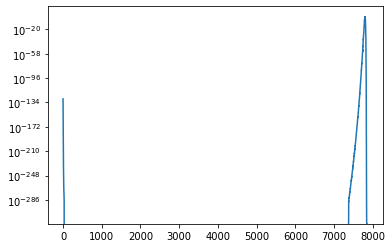

In [141]:
plt.semilogy(np.abs(u))

In [154]:
ee[:20]

array([-1.05991193, -0.80275871, -0.61500576, -0.5581386 , -0.48984224,
       -0.16237167, -0.1378707 , -0.12906815, -0.09798379, -0.09430978,
       -0.08925309, -0.08901155, -0.08418677, -0.07345259, -0.07258575,
       -0.0610366 , -0.05562053, -0.05302191, -0.04683727, -0.04485182])

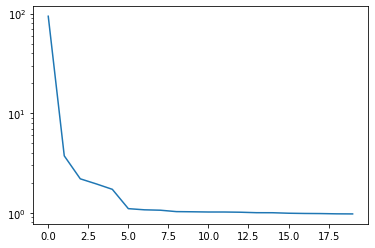

In [155]:
plt.semilogy(1.0 / (ee - 1.01*np.min(ee))[:20])

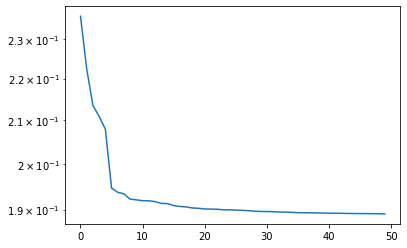

In [160]:
plt.semilogy(1.0 / (ee - 5.0*np.min(ee))[:50])

Text(0.5, 1.0, 'k=-1')

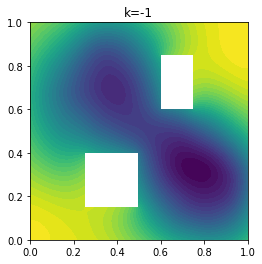

In [89]:
plt.figure()
k=-1
uk_non = dl.Function(Vh)
uk_non.vector()[:] = P_X[:,k].copy()
dl.plot(uk_non)
plt.title('k='+str(k))

In [91]:
Z = P_X[:,:100] @ (P_X[:,:100].T @ P[:,0]) - P[:,0]
np.linalg.norm(Z) / np.linalg.norm(P[:,0])

0.9999999999874283

In [40]:
X = P_non[:,:10] @ (P_non[:,:10].T @ P[:,0]) - P[:,0]
np.linalg.norm(X) / np.linalg.norm(P[:,0])

0.9967101249068913

In [54]:
X = P[:,:10] @ (P[:,:10].T @ P_non[:,:10]) - P_non[:,:10]
np.linalg.norm(X) / np.linalg.norm(P_non[:,:10])

0.9998580521671597

In [46]:
k=10
np.sum(P_non[:,:k] * (Hd_pch_dense @ P_non[:,:k]), axis=0) / np.sum(P_non[:,:k] * (Hr_dense @ P_non[:,:k]), axis=0)

array([-0.00398087, -0.00865986, -0.00639051, -0.00625952, -0.00387418,
       -0.00471069, -0.0062114 , -0.00351881, -0.00384325, -0.0024865 ])

In [45]:
np.sum(P[:,:k] * (Hd_pch_dense @ P[:,:k]), axis=0) / np.sum(P[:,:k] * (Hr_dense @ P[:,:k]), axis=0)

array([-1.05991193, -0.80275871, -0.61500576, -0.5581386 , -0.48984224,
       -0.16237167, -0.1378707 , -0.12906815, -0.09798379, -0.09430978])

In [51]:
k=500
Hd_small = P_non[:,:k].T @ (Hd_pch_dense @ P_non[:,:k])
Hr_small = P_non[:,:k].T @ (Hr_dense @ P_non[:,:k])

ee_small, P_small = sla.eigh(Hd_small, Hr_small)
print('ee_small=', ee_small)

ee_small= [-3.02626159e-02 -1.55808723e-02 -1.48547544e-02 -1.37474211e-02
 -1.27715042e-02 -1.14371613e-02 -1.12995598e-02 -1.01306960e-02
 -8.56801527e-03 -8.34832098e-03 -7.36743215e-03 -6.95205213e-03
 -6.70802531e-03 -5.84298634e-03 -5.36535340e-03 -4.89552705e-03
 -4.77443419e-03 -4.76727473e-03 -4.62598049e-03 -4.53072402e-03
 -4.32653495e-03 -4.20941477e-03 -3.99027798e-03 -3.95333773e-03
 -3.79798170e-03 -3.79271083e-03 -3.70088142e-03 -3.68219564e-03
 -3.50943426e-03 -3.27111893e-03 -3.23727395e-03 -3.19031784e-03
 -3.17208749e-03 -3.11246175e-03 -3.07103253e-03 -3.02582465e-03
 -2.96687315e-03 -2.90689817e-03 -2.82584572e-03 -2.77124740e-03
 -2.68421805e-03 -2.62420674e-03 -2.58705029e-03 -2.55805186e-03
 -2.54076573e-03 -2.52124836e-03 -2.46880167e-03 -2.33979570e-03
 -2.25048365e-03 -2.17120476e-03 -2.11167157e-03 -2.04129710e-03
 -2.03679137e-03 -2.02124426e-03 -1.97687526e-03 -1.97076555e-03
 -1.96534456e-03 -1.92712986e-03 -1.89136759e-03 -1.84563291e-03
 -1.84493296e-0

In [65]:
D = spla.LinearOperator((len(ee), len(ee)), matvec=lambda x: ee*x)

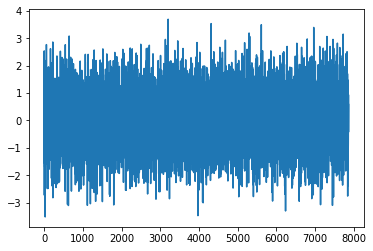

In [68]:
u = np.random.randn(D.shape[1])
plt.plot(u)

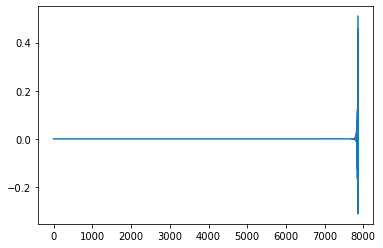

In [72]:
u2 = D @ u
u2 = u2 / np.linalg.norm(u2)
plt.plot(u2)

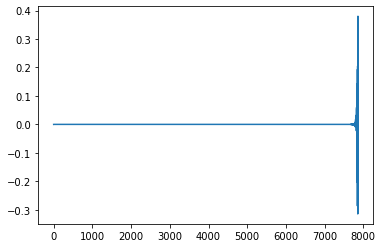

In [73]:
u3 = (np.max(ee) - ee) * u2
u3 = u3 / np.linalg.norm(u3)
plt.plot(u3)

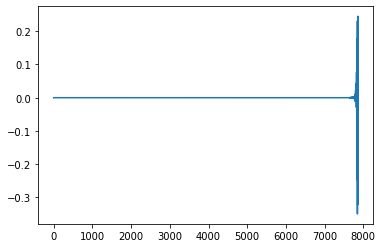

In [75]:
u4 = (np.max(ee) - ee) * u3
u4 = u4 / np.linalg.norm(u4)
plt.plot(u4)

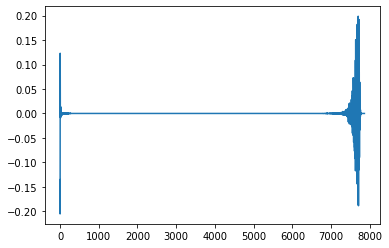

In [81]:
ux = u4
for k in range(5000):
    ux = (np.max(ee) - ee) * ux
    ux = ux / np.linalg.norm(ux)

plt.plot(ux)

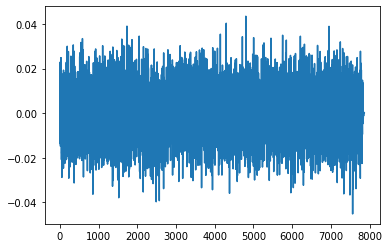

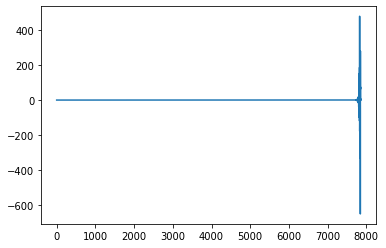

In [84]:
ux = np.random.randn(D.shape[1])
for k in range(50):
    ux = (np.max(ee) - ee) * ux
    ux = ux / np.linalg.norm(ux)

plt.plot(ux)

ux = ux * ee**2
plt.figure()
plt.plot(ux)

[-8.31903850e-05 -6.30069384e-05 -4.82705817e-05 -4.38071915e-05
 -3.84467459e-05 -1.27442305e-05 -1.08211974e-05 -1.01303034e-05
 -7.69055299e-06 -7.40218751e-06 -7.00529831e-06 -6.98634022e-06
 -6.60765226e-06 -5.76514819e-06 -5.69711132e-06 -4.79064151e-06
 -4.36554475e-06 -4.16158460e-06 -3.67616473e-06 -3.52033009e-06]
[0.05452064 0.05709857 0.06859058 0.0722635  0.08361664 0.09009421
 0.09937279 0.11984585 0.12389993 0.14059745 0.16907387 0.19580964
 0.25735265 0.28221651 0.35052862 0.38254949 0.45661301 0.50775051
 0.76388471 0.90909091]
1.0/(ee_S+tau)[:20]: [ -12166.87329282  -16127.22745999  -21154.80631267  -23360.56080907
  -26704.59011405  -85148.19272727 -101820.57859823 -109525.38604515
 -149464.47652943 -156196.61234347 -166519.62122108 -167046.97088514
 -178327.74825193 -209857.06217578 -212896.80651083 -263807.58960565
 -297128.71864811 -316297.08703508 -373669.07549944 -396773.42414905]
1.0/(ee_S+tau)[-20:]: [18.3413402  17.51326786 14.57904821 13.83805277 11.95919881

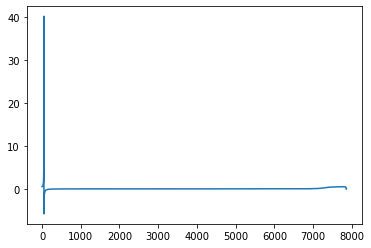

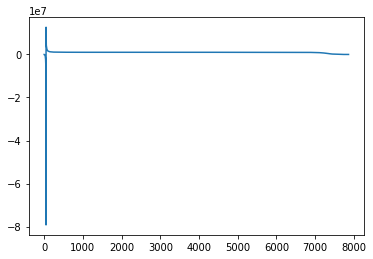

In [105]:
ee_S= ee / (1.1*np.max(ee))
print(ee_S[:20])
print(ee_S[-20:])
# plt.plot(ee_S)

tau=1e-6

plt.plot(ee_S*(0.5-ee_S)*(1.0-ee_S)/(ee_S+tau))
plt.figure()
plt.plot(1.0/(ee_S+tau))

print('1.0/(ee_S+tau)[:20]:', 1.0/(ee_S+tau)[:20])
print('1.0/(ee_S+tau)[-20:]:', 1.0/(ee_S+tau)[-20:])

[1.00012201 1.00009241 1.0000708  1.00006425 1.00005639 1.00001869
 1.00001587 1.00001486 1.00001128 1.00001086 1.00001027 1.00001025
 1.00000969 1.00000846 1.00000836 1.00000703 1.0000064  1.0000061
 1.00000539 1.00000516]
[ 0.92003639  0.91625544  0.89940048  0.89401353  0.87736226  0.86786183
  0.85425325  0.82422608  0.81828011  0.79379041  0.75202499  0.71281253
  0.62254945  0.58608245  0.48589135  0.43892742  0.33030092  0.25529926
 -0.12036425 -0.33333333]


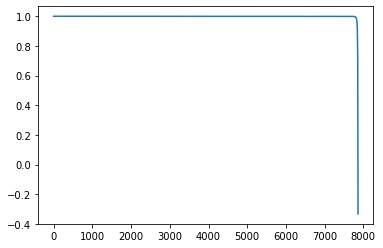

In [61]:
ee_T = 1.0 - 2.0 * ee / (1.5 * np.max(ee))
print(ee_T[:20])
print(ee_T[-20:])
plt.plot(ee_T)

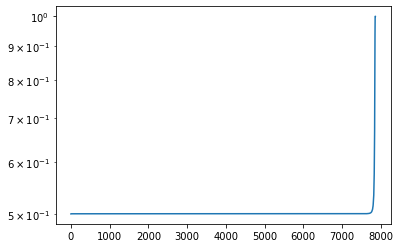

In [63]:
k = 8
ee_Pi_plus = 1.0 / (1.0 + np.power(ee_T, k))
plt.semilogy(np.abs(ee_Pi_plus))

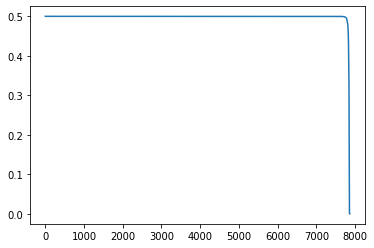

In [64]:
ee_Pi_minus = 1.0 - ee_Pi_plus
plt.plot(ee_Pi_minus)

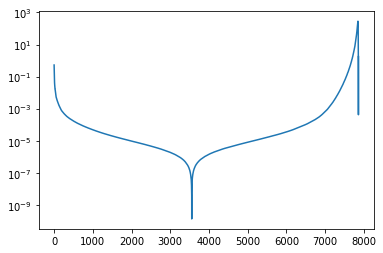

In [86]:
ee_minus = ee_Pi_minus * ee
plt.semilogy(np.abs(ee_minus))

In [28]:
T = 2.0 * Hd_pch_dense / np.max(ee) - Hr_dense

In [29]:
Z1 = Hr_dense + 1j*T

In [30]:
iZ1 = np.linalg.inv(Z1)

In [32]:
PX = iZ1 @ iZ1.conj()

u -> Au -> A(Au) -> A(A(Au))

Idea: ``Low rank'' approximation of prior preconditioned Hessian

$$\mathbf{A} \mathbf{p}_i = \lambda_i \mathbf{p_i}$$

$$u = \sum_i u_i \mathbf{p}_i$$

$$\mathbf{A}^k u = \sum_i \lambda_i^k u_i \mathbf{p}_i$$

$$\frac{(\mathbf{A}^k u)_i}{(\mathbf{A}^k u)_j} = \left(\frac{\lambda_i}{\lambda_j}\right)^k$$

(-1)--(0)----------------------------------------------------(10000)

(-10001)--(-10000)----------------------------------------------------(0)
A - 10000 I 

u -> Au (get rid of cluster from u)
Au -> (A-10000 I)^k(A^j u)

(1-lambda)^k * lambda^j

$$T = \alpha A + \beta I$$

$$A(I + T^2)^{-1} = A(I - iT)^{-1}(I + iT)^{-1}$$

$$(I + iT)(I - iT) = I + iT -iT - (i^2)T = (I + T^2)$$

(-1.0001)-B-G-(-1)---OOD---(1)

(-1)--BAD-(-0.5)-MEH--(1)--(+0.5)---GOOD------>
(-1)----------B-(1)-----GOOD------>

(-1.05)-BAD-MEH-(0)----------------GOOD------------------(10001)
                (0)--GOOD--(1)-MEH-(2)------------BAD------------------(infinity)

$$((A + 1.05 I)/1.05)^{-1}$$

$$e \sim H_r^{-1} H_d$$

$$H_r^{-1}(H_d + H_r) \sim e + 1$$

In [26]:
ee[:20]

array([-1.05991193, -0.80275871, -0.61500576, -0.5581386 , -0.48984224,
       -0.16237167, -0.1378707 , -0.12906815, -0.09798379, -0.09430978,
       -0.08925309, -0.08901155, -0.08418677, -0.07345259, -0.07258575,
       -0.0610366 , -0.05562053, -0.05302191, -0.04683727, -0.04485182])

In [27]:
ee[-20:]

array([  694.63652587,   727.48132968,   873.89880278,   920.6947266 ,
        1065.34278343,  1147.87215793,  1266.0886466 ,  1526.93187891,
        1578.58400732,  1791.32377907,  2154.1361131 ,  2494.77119462,
        3278.87822383,  3595.66373079,  4466.01455326,  4873.98594275,
        5817.61437904,  6469.14691717,  9732.50122222, 11582.54411148])

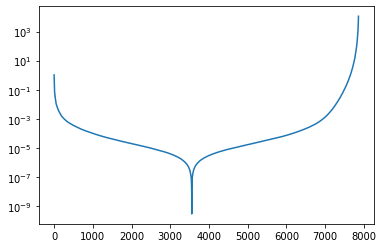

In [27]:
plt.semilogy(np.abs(ee))

ee[0]= -1.0599119341136547


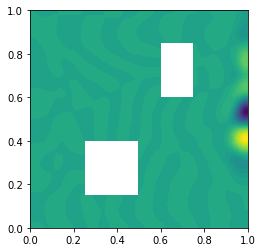

In [74]:
k=0
kth_evec = dl.Function(Vh)
kth_evec.vector()[:] = P[:,k]
dl.plot(kth_evec)
print('ee['+str(k)+']=', ee[k])

In [28]:
iHr_dense = np.linalg.inv(Hr_dense)

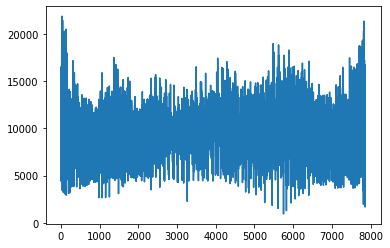

In [114]:
plt.plot(np.sum(Hd_pch_dense, axis=1) - Hd_pch_dense.diagonal())

In [ ]:
Hd_count = [0]
def apply_Hd_count(x):
    Hd_count[0] += 1
    print('Hd_count[0]=', Hd_count[0])
    return Hd_pch_dense @ x
apply_Hd_linop = spla.LinearOperator(Hd_pch_dense.shape, matvec=apply_Hd_count)

Hr_count = [0]
def apply_Hr_count(x):
    Hr_count[0] += 1
    print('Hr_count[0]=', Hr_count[0])
    return Hr_dense @ x
apply_Hr_linop = spla.LinearOperator(Hr_dense.shape, matvec=apply_Hr_count)

iHr_count = [0]
def solve_Hr_count(x):
    iHr_count[0] += 1
    print('iHr_count[0]=', iHr_count[0])
    return iHr_dense @ x
solve_Hr_linop = spla.LinearOperator(iHr_dense.shape, matvec=solve_Hr_count)

In [46]:
Hd_count[0] = 0
Hr_count[0] = 0
iHr_count[0] = 0
ee2, P2 = spla.eigsh(apply_Hd_linop, k=1, M=apply_Hr_linop, Minv=solve_Hr_linop, 
                     which='LM', tol=1e-2)
print(ee2)

Hd_count[0]= 1
iHr_count[0]= 1
Hr_count[0]= 1
Hd_count[0]= 2
iHr_count[0]= 2
Hr_count[0]= 2
Hr_count[0]= 3
Hd_count[0]= 3
iHr_count[0]= 3
Hr_count[0]= 4
Hr_count[0]= 5
Hd_count[0]= 4
iHr_count[0]= 4
Hr_count[0]= 6
Hr_count[0]= 7
Hd_count[0]= 5
iHr_count[0]= 5
Hr_count[0]= 8
Hr_count[0]= 9
Hd_count[0]= 6
iHr_count[0]= 6
Hr_count[0]= 10
Hr_count[0]= 11
Hd_count[0]= 7
iHr_count[0]= 7
Hr_count[0]= 12
Hr_count[0]= 13
Hd_count[0]= 8
iHr_count[0]= 8
Hr_count[0]= 14
Hr_count[0]= 15
Hd_count[0]= 9
iHr_count[0]= 9
Hr_count[0]= 16
Hr_count[0]= 17
Hd_count[0]= 10
iHr_count[0]= 10
Hr_count[0]= 18
Hr_count[0]= 19
Hd_count[0]= 11
iHr_count[0]= 11
Hr_count[0]= 20
Hr_count[0]= 21
Hd_count[0]= 12
iHr_count[0]= 12
Hr_count[0]= 22
Hr_count[0]= 23
Hd_count[0]= 13
iHr_count[0]= 13
Hr_count[0]= 24
Hr_count[0]= 25
Hd_count[0]= 14
iHr_count[0]= 14
Hr_count[0]= 26
Hr_count[0]= 27
Hd_count[0]= 15
iHr_count[0]= 15
Hr_count[0]= 28
Hr_count[0]= 29
Hd_count[0]= 16
iHr_count[0]= 16
Hr_count[0]= 30
Hr_count[0]= 31
Hd_

In [42]:
Hd_count[0] = 0
Hr_count[0] = 0
iHr_count[0] = 0
ee2, P2 = spla.eigsh(apply_Hd_linop, k=1, M=apply_Hr_linop, Minv=solve_Hr_linop, 
                     which='SA', tol=1e-1)
print(ee3)

Hd_count[0]= 1
iHr_count[0]= 1
Hr_count[0]= 1
Hd_count[0]= 2
iHr_count[0]= 2
Hr_count[0]= 2
Hr_count[0]= 3
Hd_count[0]= 3
iHr_count[0]= 3
Hr_count[0]= 4
Hr_count[0]= 5
Hd_count[0]= 4
iHr_count[0]= 4
Hr_count[0]= 6
Hr_count[0]= 7
Hd_count[0]= 5
iHr_count[0]= 5
Hr_count[0]= 8
Hr_count[0]= 9
Hd_count[0]= 6
iHr_count[0]= 6
Hr_count[0]= 10
Hr_count[0]= 11
Hd_count[0]= 7
iHr_count[0]= 7
Hr_count[0]= 12
Hr_count[0]= 13
Hd_count[0]= 8
iHr_count[0]= 8
Hr_count[0]= 14
Hr_count[0]= 15
Hd_count[0]= 9
iHr_count[0]= 9
Hr_count[0]= 16
Hr_count[0]= 17
Hd_count[0]= 10
iHr_count[0]= 10
Hr_count[0]= 18
Hr_count[0]= 19
Hd_count[0]= 11
iHr_count[0]= 11
Hr_count[0]= 20
Hr_count[0]= 21
Hd_count[0]= 12
iHr_count[0]= 12
Hr_count[0]= 22
Hr_count[0]= 23
Hd_count[0]= 13
iHr_count[0]= 13
Hr_count[0]= 24
Hr_count[0]= 25
Hd_count[0]= 14
iHr_count[0]= 14
Hr_count[0]= 26
Hr_count[0]= 27
Hd_count[0]= 15
iHr_count[0]= 15
Hr_count[0]= 28
Hr_count[0]= 29
Hd_count[0]= 16
iHr_count[0]= 16
Hr_count[0]= 30
Hr_count[0]= 31
Hd_

Hr_count[0]= 252
Hd_count[0]= 124
iHr_count[0]= 124
Hr_count[0]= 253
Hr_count[0]= 254
Hd_count[0]= 125
iHr_count[0]= 125
Hr_count[0]= 255
Hr_count[0]= 256
Hd_count[0]= 126
iHr_count[0]= 126
Hr_count[0]= 257
Hr_count[0]= 258
Hd_count[0]= 127
iHr_count[0]= 127
Hr_count[0]= 259
Hr_count[0]= 260
Hd_count[0]= 128
iHr_count[0]= 128
Hr_count[0]= 261
Hr_count[0]= 262
Hd_count[0]= 129
iHr_count[0]= 129
Hr_count[0]= 263
Hr_count[0]= 264
Hd_count[0]= 130
iHr_count[0]= 130
Hr_count[0]= 265
Hr_count[0]= 266
Hd_count[0]= 131
iHr_count[0]= 131
Hr_count[0]= 267
Hr_count[0]= 268
Hr_count[0]= 269
Hd_count[0]= 132
iHr_count[0]= 132
Hr_count[0]= 270
Hr_count[0]= 271
Hd_count[0]= 133
iHr_count[0]= 133
Hr_count[0]= 272
Hr_count[0]= 273
Hd_count[0]= 134
iHr_count[0]= 134
Hr_count[0]= 274
Hr_count[0]= 275
Hd_count[0]= 135
iHr_count[0]= 135
Hr_count[0]= 276
Hr_count[0]= 277
Hd_count[0]= 136
iHr_count[0]= 136
Hr_count[0]= 278
Hr_count[0]= 279
Hd_count[0]= 137
iHr_count[0]= 137
Hr_count[0]= 280
Hr_count[0]= 281


Hr_count[0]= 495
Hr_count[0]= 496
Hr_count[0]= 497
Hd_count[0]= 242
iHr_count[0]= 242
Hr_count[0]= 498
Hr_count[0]= 499
Hd_count[0]= 243
iHr_count[0]= 243
Hr_count[0]= 500
Hr_count[0]= 501
Hd_count[0]= 244
iHr_count[0]= 244
Hr_count[0]= 502
Hr_count[0]= 503
Hd_count[0]= 245
iHr_count[0]= 245
Hr_count[0]= 504
Hr_count[0]= 505
Hd_count[0]= 246
iHr_count[0]= 246
Hr_count[0]= 506
Hr_count[0]= 507
Hd_count[0]= 247
iHr_count[0]= 247
Hr_count[0]= 508
Hr_count[0]= 509
Hd_count[0]= 248
iHr_count[0]= 248
Hr_count[0]= 510
Hr_count[0]= 511
Hd_count[0]= 249
iHr_count[0]= 249
Hr_count[0]= 512
Hr_count[0]= 513
Hd_count[0]= 250
iHr_count[0]= 250
Hr_count[0]= 514
Hr_count[0]= 515
Hd_count[0]= 251
iHr_count[0]= 251
Hr_count[0]= 516
Hr_count[0]= 517
Hr_count[0]= 518
Hd_count[0]= 252
iHr_count[0]= 252
Hr_count[0]= 519
Hr_count[0]= 520
Hd_count[0]= 253
iHr_count[0]= 253
Hr_count[0]= 521
Hr_count[0]= 522
Hd_count[0]= 254
iHr_count[0]= 254
Hr_count[0]= 523
Hr_count[0]= 524
Hd_count[0]= 255
iHr_count[0]= 255


Hr_count[0]= 739
Hr_count[0]= 740
Hd_count[0]= 359
iHr_count[0]= 359
Hr_count[0]= 741
Hr_count[0]= 742
Hd_count[0]= 360
iHr_count[0]= 360
Hr_count[0]= 743
Hr_count[0]= 744
Hd_count[0]= 361
iHr_count[0]= 361
Hr_count[0]= 745
Hr_count[0]= 746
Hr_count[0]= 747
Hd_count[0]= 362
iHr_count[0]= 362
Hr_count[0]= 748
Hr_count[0]= 749
Hd_count[0]= 363
iHr_count[0]= 363
Hr_count[0]= 750
Hr_count[0]= 751
Hd_count[0]= 364
iHr_count[0]= 364
Hr_count[0]= 752
Hr_count[0]= 753
Hd_count[0]= 365
iHr_count[0]= 365
Hr_count[0]= 754
Hr_count[0]= 755
Hd_count[0]= 366
iHr_count[0]= 366
Hr_count[0]= 756
Hr_count[0]= 757
Hd_count[0]= 367
iHr_count[0]= 367
Hr_count[0]= 758
Hr_count[0]= 759
Hd_count[0]= 368
iHr_count[0]= 368
Hr_count[0]= 760
Hr_count[0]= 761
Hd_count[0]= 369
iHr_count[0]= 369
Hr_count[0]= 762
Hr_count[0]= 763
Hd_count[0]= 370
iHr_count[0]= 370
Hr_count[0]= 764
Hr_count[0]= 765
Hd_count[0]= 371
iHr_count[0]= 371
Hr_count[0]= 766
Hr_count[0]= 767
Hr_count[0]= 768
Hd_count[0]= 372
iHr_count[0]= 372


Hr_count[0]= 984
Hd_count[0]= 475
iHr_count[0]= 475
Hr_count[0]= 985
Hr_count[0]= 986
Hd_count[0]= 476
iHr_count[0]= 476
Hr_count[0]= 987
Hr_count[0]= 988
Hd_count[0]= 477
iHr_count[0]= 477
Hr_count[0]= 989
Hr_count[0]= 990
Hd_count[0]= 478
iHr_count[0]= 478
Hr_count[0]= 991
Hr_count[0]= 992
Hd_count[0]= 479
iHr_count[0]= 479
Hr_count[0]= 993
Hr_count[0]= 994
Hd_count[0]= 480
iHr_count[0]= 480
Hr_count[0]= 995
Hr_count[0]= 996
Hd_count[0]= 481
iHr_count[0]= 481
Hr_count[0]= 997
Hr_count[0]= 998
Hr_count[0]= 999
Hd_count[0]= 482
iHr_count[0]= 482
Hr_count[0]= 1000
Hr_count[0]= 1001
Hd_count[0]= 483
iHr_count[0]= 483
Hr_count[0]= 1002
Hr_count[0]= 1003
Hd_count[0]= 484
iHr_count[0]= 484
Hr_count[0]= 1004
Hr_count[0]= 1005
Hd_count[0]= 485
iHr_count[0]= 485
Hr_count[0]= 1006
Hr_count[0]= 1007
Hd_count[0]= 486
iHr_count[0]= 486
Hr_count[0]= 1008
Hr_count[0]= 1009
Hd_count[0]= 487
iHr_count[0]= 487
Hr_count[0]= 1010
Hr_count[0]= 1011
Hd_count[0]= 488
iHr_count[0]= 488
Hr_count[0]= 1012
Hr_c

Hr_count[0]= 1223
Hd_count[0]= 589
iHr_count[0]= 589
Hr_count[0]= 1224
Hr_count[0]= 1225
Hd_count[0]= 590
iHr_count[0]= 590
Hr_count[0]= 1226
Hr_count[0]= 1227
Hd_count[0]= 591
iHr_count[0]= 591
Hr_count[0]= 1228
Hr_count[0]= 1229
Hr_count[0]= 1230
Hd_count[0]= 592
iHr_count[0]= 592
Hr_count[0]= 1231
Hr_count[0]= 1232
Hd_count[0]= 593
iHr_count[0]= 593
Hr_count[0]= 1233
Hr_count[0]= 1234
Hd_count[0]= 594
iHr_count[0]= 594
Hr_count[0]= 1235
Hr_count[0]= 1236
Hd_count[0]= 595
iHr_count[0]= 595
Hr_count[0]= 1237
Hr_count[0]= 1238
Hd_count[0]= 596
iHr_count[0]= 596
Hr_count[0]= 1239
Hr_count[0]= 1240
Hd_count[0]= 597
iHr_count[0]= 597
Hr_count[0]= 1241
Hr_count[0]= 1242
Hd_count[0]= 598
iHr_count[0]= 598
Hr_count[0]= 1243
Hr_count[0]= 1244
Hd_count[0]= 599
iHr_count[0]= 599
Hr_count[0]= 1245
Hr_count[0]= 1246
Hd_count[0]= 600
iHr_count[0]= 600
Hr_count[0]= 1247
Hr_count[0]= 1248
Hd_count[0]= 601
iHr_count[0]= 601
Hr_count[0]= 1249
Hr_count[0]= 1250
Hr_count[0]= 1251
Hd_count[0]= 602
iHr_co

KeyboardInterrupt: 

In [47]:
emax = np.max(ee2)
print('emax=', emax)

emax= 11582.544103238568


In [51]:
Z_count = [0]
def apply_Z_count(x):
    Z_count[0] += 1
    print('Z_count[0]=', Z_count[0])
    return emax*(Hr_dense @ x) - Hd_pch_dense @ x
apply_Z_linop = spla.LinearOperator(Hd_pch_dense.shape, matvec=apply_Z_count)

Z_count[0] = 0
Hr_count[0] = 0
iHr_count[0] = 0
ee4, P4 = spla.eigsh(apply_Z_linop, k=1, M=apply_Hr_linop, Minv=solve_Hr_linop, 
                     which='LM', tol=1e-6)
print(ee4)

Z_count[0]= 1
Z_count[0]= 1
iHr_count[0]= 1
Hr_count[0]= 1
Z_count[0]= 2
iHr_count[0]= 2
Hr_count[0]= 2
Hr_count[0]= 3
Z_count[0]= 3
iHr_count[0]= 3
Hr_count[0]= 4
Hr_count[0]= 5
Z_count[0]= 4
iHr_count[0]= 4
Hr_count[0]= 6
Hr_count[0]= 7
Z_count[0]= 5
iHr_count[0]= 5
Hr_count[0]= 8
Hr_count[0]= 9
Z_count[0]= 6
iHr_count[0]= 6
Hr_count[0]= 10
Hr_count[0]= 11
Z_count[0]= 7
iHr_count[0]= 7
Hr_count[0]= 12
Hr_count[0]= 13
Z_count[0]= 8
iHr_count[0]= 8
Hr_count[0]= 14
Hr_count[0]= 15
Z_count[0]= 9
iHr_count[0]= 9
Hr_count[0]= 16
Hr_count[0]= 17
Z_count[0]= 10
iHr_count[0]= 10
Hr_count[0]= 18
Hr_count[0]= 19
Z_count[0]= 11
iHr_count[0]= 11
Hr_count[0]= 20
Hr_count[0]= 21
Z_count[0]= 12
iHr_count[0]= 12
Hr_count[0]= 22
Hr_count[0]= 23
Z_count[0]= 13
iHr_count[0]= 13
Hr_count[0]= 24
Hr_count[0]= 25
Z_count[0]= 14
iHr_count[0]= 14
Hr_count[0]= 26
Hr_count[0]= 27
Z_count[0]= 15
iHr_count[0]= 15
Hr_count[0]= 28
Hr_count[0]= 29
Z_count[0]= 16
iHr_count[0]= 16
Hr_count[0]= 30
Hr_count[0]= 31
Z_cou

iHr_count[0]= 124
Hr_count[0]= 257
Hr_count[0]= 258
Z_count[0]= 125
iHr_count[0]= 125
Hr_count[0]= 259
Hr_count[0]= 260
Z_count[0]= 126
iHr_count[0]= 126
Hr_count[0]= 261
Hr_count[0]= 262
Z_count[0]= 127
iHr_count[0]= 127
Hr_count[0]= 263
Hr_count[0]= 264
Z_count[0]= 128
iHr_count[0]= 128
Hr_count[0]= 265
Hr_count[0]= 266
Z_count[0]= 129
iHr_count[0]= 129
Hr_count[0]= 267
Hr_count[0]= 268
Z_count[0]= 130
iHr_count[0]= 130
Hr_count[0]= 269
Hr_count[0]= 270
Z_count[0]= 131
iHr_count[0]= 131
Hr_count[0]= 271
Hr_count[0]= 272
Hr_count[0]= 273
Z_count[0]= 132
iHr_count[0]= 132
Hr_count[0]= 274
Hr_count[0]= 275
Z_count[0]= 133
iHr_count[0]= 133
Hr_count[0]= 276
Hr_count[0]= 277
Z_count[0]= 134
iHr_count[0]= 134
Hr_count[0]= 278
Hr_count[0]= 279
Z_count[0]= 135
iHr_count[0]= 135
Hr_count[0]= 280
Hr_count[0]= 281
Z_count[0]= 136
iHr_count[0]= 136
Hr_count[0]= 282
Hr_count[0]= 283
Z_count[0]= 137
iHr_count[0]= 137
Hr_count[0]= 284
Hr_count[0]= 285
Z_count[0]= 138
iHr_count[0]= 138
Hr_count[0]= 

Z_count[0]= 242
iHr_count[0]= 242
Hr_count[0]= 505
Hr_count[0]= 506
Z_count[0]= 243
iHr_count[0]= 243
Hr_count[0]= 507
Hr_count[0]= 508
Z_count[0]= 244
iHr_count[0]= 244
Hr_count[0]= 509
Hr_count[0]= 510
Z_count[0]= 245
iHr_count[0]= 245
Hr_count[0]= 511
Hr_count[0]= 512
Z_count[0]= 246
iHr_count[0]= 246
Hr_count[0]= 513
Hr_count[0]= 514
Z_count[0]= 247
iHr_count[0]= 247
Hr_count[0]= 515
Hr_count[0]= 516
Z_count[0]= 248
iHr_count[0]= 248
Hr_count[0]= 517
Hr_count[0]= 518
Z_count[0]= 249
iHr_count[0]= 249
Hr_count[0]= 519
Hr_count[0]= 520
Z_count[0]= 250
iHr_count[0]= 250
Hr_count[0]= 521
Hr_count[0]= 522
Z_count[0]= 251
iHr_count[0]= 251
Hr_count[0]= 523
Hr_count[0]= 524
Hr_count[0]= 525
Z_count[0]= 252
iHr_count[0]= 252
Hr_count[0]= 526
Hr_count[0]= 527
Z_count[0]= 253
iHr_count[0]= 253
Hr_count[0]= 528
Hr_count[0]= 529
Z_count[0]= 254
iHr_count[0]= 254
Hr_count[0]= 530
Hr_count[0]= 531
Z_count[0]= 255
iHr_count[0]= 255
Hr_count[0]= 532
Hr_count[0]= 533
Z_count[0]= 256
iHr_count[0]= 2

iHr_count[0]= 361
Hr_count[0]= 754
Hr_count[0]= 755
Hr_count[0]= 756
Z_count[0]= 362
iHr_count[0]= 362
Hr_count[0]= 757
Hr_count[0]= 758
Z_count[0]= 363
iHr_count[0]= 363
Hr_count[0]= 759
Hr_count[0]= 760
Z_count[0]= 364
iHr_count[0]= 364
Hr_count[0]= 761
Hr_count[0]= 762
Z_count[0]= 365
iHr_count[0]= 365
Hr_count[0]= 763
Hr_count[0]= 764
Z_count[0]= 366
iHr_count[0]= 366
Hr_count[0]= 765
Hr_count[0]= 766
Z_count[0]= 367
iHr_count[0]= 367
Hr_count[0]= 767
Hr_count[0]= 768
Z_count[0]= 368
iHr_count[0]= 368
Hr_count[0]= 769
Hr_count[0]= 770
Z_count[0]= 369
iHr_count[0]= 369
Hr_count[0]= 771
Hr_count[0]= 772
Z_count[0]= 370
iHr_count[0]= 370
Hr_count[0]= 773
Hr_count[0]= 774
Z_count[0]= 371
iHr_count[0]= 371
Hr_count[0]= 775
Hr_count[0]= 776
Hr_count[0]= 777
Z_count[0]= 372
iHr_count[0]= 372
Hr_count[0]= 778
Hr_count[0]= 779
Z_count[0]= 373
iHr_count[0]= 373
Hr_count[0]= 780
Hr_count[0]= 781
Z_count[0]= 374
iHr_count[0]= 374
Hr_count[0]= 782
Hr_count[0]= 783
Z_count[0]= 375
iHr_count[0]= 

iHr_count[0]= 479
Hr_count[0]= 1002
Hr_count[0]= 1003
Z_count[0]= 480
iHr_count[0]= 480
Hr_count[0]= 1004
Hr_count[0]= 1005
Z_count[0]= 481
iHr_count[0]= 481
Hr_count[0]= 1006
Hr_count[0]= 1007
Hr_count[0]= 1008
Z_count[0]= 482
iHr_count[0]= 482
Hr_count[0]= 1009
Hr_count[0]= 1010
Z_count[0]= 483
iHr_count[0]= 483
Hr_count[0]= 1011
Hr_count[0]= 1012
Z_count[0]= 484
iHr_count[0]= 484
Hr_count[0]= 1013
Hr_count[0]= 1014
Z_count[0]= 485
iHr_count[0]= 485
Hr_count[0]= 1015
Hr_count[0]= 1016
Z_count[0]= 486
iHr_count[0]= 486
Hr_count[0]= 1017
Hr_count[0]= 1018
Z_count[0]= 487
iHr_count[0]= 487
Hr_count[0]= 1019
Hr_count[0]= 1020
Z_count[0]= 488
iHr_count[0]= 488
Hr_count[0]= 1021
Hr_count[0]= 1022
Z_count[0]= 489
iHr_count[0]= 489
Hr_count[0]= 1023
Hr_count[0]= 1024
Z_count[0]= 490
iHr_count[0]= 490
Hr_count[0]= 1025
Hr_count[0]= 1026
Z_count[0]= 491
iHr_count[0]= 491
Hr_count[0]= 1027
Hr_count[0]= 1028
Hr_count[0]= 1029
Z_count[0]= 492
iHr_count[0]= 492
Hr_count[0]= 1030
Hr_count[0]= 1031


Hr_count[0]= 1243
Z_count[0]= 594
iHr_count[0]= 594
Hr_count[0]= 1244
Hr_count[0]= 1245
Z_count[0]= 595
iHr_count[0]= 595
Hr_count[0]= 1246
Hr_count[0]= 1247
Z_count[0]= 596
iHr_count[0]= 596
Hr_count[0]= 1248
Hr_count[0]= 1249
Z_count[0]= 597
iHr_count[0]= 597
Hr_count[0]= 1250
Hr_count[0]= 1251
Z_count[0]= 598
iHr_count[0]= 598
Hr_count[0]= 1252
Hr_count[0]= 1253
Z_count[0]= 599
iHr_count[0]= 599
Hr_count[0]= 1254
Hr_count[0]= 1255
Z_count[0]= 600
iHr_count[0]= 600
Hr_count[0]= 1256
Hr_count[0]= 1257
Z_count[0]= 601
iHr_count[0]= 601
Hr_count[0]= 1258
Hr_count[0]= 1259
Hr_count[0]= 1260
Z_count[0]= 602
iHr_count[0]= 602
Hr_count[0]= 1261
Hr_count[0]= 1262
Z_count[0]= 603
iHr_count[0]= 603
Hr_count[0]= 1263
Hr_count[0]= 1264
Z_count[0]= 604
iHr_count[0]= 604
Hr_count[0]= 1265
Hr_count[0]= 1266
Z_count[0]= 605
iHr_count[0]= 605
Hr_count[0]= 1267
Hr_count[0]= 1268
Z_count[0]= 606
iHr_count[0]= 606
Hr_count[0]= 1269
Hr_count[0]= 1270
Z_count[0]= 607
iHr_count[0]= 607
Hr_count[0]= 1271
Hr

iHr_count[0]= 709
Hr_count[0]= 1485
Hr_count[0]= 1486
Z_count[0]= 710
iHr_count[0]= 710
Hr_count[0]= 1487
Hr_count[0]= 1488
Z_count[0]= 711
iHr_count[0]= 711
Hr_count[0]= 1489
Hr_count[0]= 1490
Hr_count[0]= 1491
Z_count[0]= 712
iHr_count[0]= 712
Hr_count[0]= 1492
Hr_count[0]= 1493
Z_count[0]= 713
iHr_count[0]= 713
Hr_count[0]= 1494
Hr_count[0]= 1495
Z_count[0]= 714
iHr_count[0]= 714
Hr_count[0]= 1496
Hr_count[0]= 1497
Z_count[0]= 715
iHr_count[0]= 715
Hr_count[0]= 1498
Hr_count[0]= 1499
Z_count[0]= 716
iHr_count[0]= 716
Hr_count[0]= 1500
Hr_count[0]= 1501
Z_count[0]= 717
iHr_count[0]= 717
Hr_count[0]= 1502
Hr_count[0]= 1503
Z_count[0]= 718
iHr_count[0]= 718
Hr_count[0]= 1504
Hr_count[0]= 1505
Z_count[0]= 719
iHr_count[0]= 719
Hr_count[0]= 1506
Hr_count[0]= 1507
Z_count[0]= 720
iHr_count[0]= 720
Hr_count[0]= 1508
Hr_count[0]= 1509
Z_count[0]= 721
iHr_count[0]= 721
Hr_count[0]= 1510
Hr_count[0]= 1511
Hr_count[0]= 1512
Z_count[0]= 722
iHr_count[0]= 722
Hr_count[0]= 1513
Hr_count[0]= 1514


Hr_count[0]= 1728
Z_count[0]= 825
iHr_count[0]= 825
Hr_count[0]= 1729
Hr_count[0]= 1730
Z_count[0]= 826
iHr_count[0]= 826
Hr_count[0]= 1731
Hr_count[0]= 1732
Z_count[0]= 827
iHr_count[0]= 827
Hr_count[0]= 1733
Hr_count[0]= 1734
Z_count[0]= 828
iHr_count[0]= 828
Hr_count[0]= 1735
Hr_count[0]= 1736
Z_count[0]= 829
iHr_count[0]= 829
Hr_count[0]= 1737
Hr_count[0]= 1738
Z_count[0]= 830
iHr_count[0]= 830
Hr_count[0]= 1739
Hr_count[0]= 1740
Z_count[0]= 831
iHr_count[0]= 831
Hr_count[0]= 1741
Hr_count[0]= 1742
Hr_count[0]= 1743
Z_count[0]= 832
iHr_count[0]= 832
Hr_count[0]= 1744
Hr_count[0]= 1745
Z_count[0]= 833
iHr_count[0]= 833
Hr_count[0]= 1746
Hr_count[0]= 1747
Z_count[0]= 834
iHr_count[0]= 834
Hr_count[0]= 1748
Hr_count[0]= 1749
Z_count[0]= 835
iHr_count[0]= 835
Hr_count[0]= 1750
Hr_count[0]= 1751
Z_count[0]= 836
iHr_count[0]= 836
Hr_count[0]= 1752
Hr_count[0]= 1753
Z_count[0]= 837
iHr_count[0]= 837
Hr_count[0]= 1754
Hr_count[0]= 1755
Z_count[0]= 838
iHr_count[0]= 838
Hr_count[0]= 1756
Hr

iHr_count[0]= 939
Hr_count[0]= 1968
Hr_count[0]= 1969
Z_count[0]= 940
iHr_count[0]= 940
Hr_count[0]= 1970
Hr_count[0]= 1971
Z_count[0]= 941
iHr_count[0]= 941
Hr_count[0]= 1972
Hr_count[0]= 1973
Hr_count[0]= 1974
Z_count[0]= 942
iHr_count[0]= 942
Hr_count[0]= 1975
Hr_count[0]= 1976
Z_count[0]= 943
iHr_count[0]= 943
Hr_count[0]= 1977
Hr_count[0]= 1978
Z_count[0]= 944
iHr_count[0]= 944
Hr_count[0]= 1979
Hr_count[0]= 1980
Z_count[0]= 945
iHr_count[0]= 945
Hr_count[0]= 1981
Hr_count[0]= 1982
Z_count[0]= 946
iHr_count[0]= 946
Hr_count[0]= 1983
Hr_count[0]= 1984
Z_count[0]= 947
iHr_count[0]= 947
Hr_count[0]= 1985
Hr_count[0]= 1986
Z_count[0]= 948
iHr_count[0]= 948
Hr_count[0]= 1987
Hr_count[0]= 1988
Z_count[0]= 949
iHr_count[0]= 949
Hr_count[0]= 1989
Hr_count[0]= 1990
Z_count[0]= 950
iHr_count[0]= 950
Hr_count[0]= 1991
Hr_count[0]= 1992
Z_count[0]= 951
iHr_count[0]= 951
Hr_count[0]= 1993
Hr_count[0]= 1994
Hr_count[0]= 1995
Z_count[0]= 952
iHr_count[0]= 952
Hr_count[0]= 1996
Hr_count[0]= 1997


iHr_count[0]= 1053
Hr_count[0]= 2208
Hr_count[0]= 2209
Z_count[0]= 1054
iHr_count[0]= 1054
Hr_count[0]= 2210
Hr_count[0]= 2211
Z_count[0]= 1055
iHr_count[0]= 1055
Hr_count[0]= 2212
Hr_count[0]= 2213
Z_count[0]= 1056
iHr_count[0]= 1056
Hr_count[0]= 2214
Hr_count[0]= 2215
Z_count[0]= 1057
iHr_count[0]= 1057
Hr_count[0]= 2216
Hr_count[0]= 2217
Z_count[0]= 1058
iHr_count[0]= 1058
Hr_count[0]= 2218
Hr_count[0]= 2219
Z_count[0]= 1059
iHr_count[0]= 1059
Hr_count[0]= 2220
Hr_count[0]= 2221
Z_count[0]= 1060
iHr_count[0]= 1060
Hr_count[0]= 2222
Hr_count[0]= 2223
Z_count[0]= 1061
iHr_count[0]= 1061
Hr_count[0]= 2224
Hr_count[0]= 2225
Hr_count[0]= 2226
Z_count[0]= 1062
iHr_count[0]= 1062
Hr_count[0]= 2227
Hr_count[0]= 2228
Z_count[0]= 1063
iHr_count[0]= 1063
Hr_count[0]= 2229
Hr_count[0]= 2230
Z_count[0]= 1064
iHr_count[0]= 1064
Hr_count[0]= 2231
Hr_count[0]= 2232
Z_count[0]= 1065
iHr_count[0]= 1065
Hr_count[0]= 2233
Hr_count[0]= 2234
Z_count[0]= 1066
iHr_count[0]= 1066
Hr_count[0]= 2235
Hr_count[

Hr_count[0]= 2442
Z_count[0]= 1165
iHr_count[0]= 1165
Hr_count[0]= 2443
Hr_count[0]= 2444
Z_count[0]= 1166
iHr_count[0]= 1166
Hr_count[0]= 2445
Hr_count[0]= 2446
Z_count[0]= 1167
iHr_count[0]= 1167
Hr_count[0]= 2447
Hr_count[0]= 2448
Z_count[0]= 1168
iHr_count[0]= 1168
Hr_count[0]= 2449
Hr_count[0]= 2450
Z_count[0]= 1169
iHr_count[0]= 1169
Hr_count[0]= 2451
Hr_count[0]= 2452
Z_count[0]= 1170
iHr_count[0]= 1170
Hr_count[0]= 2453
Hr_count[0]= 2454
Z_count[0]= 1171
iHr_count[0]= 1171
Hr_count[0]= 2455
Hr_count[0]= 2456
Hr_count[0]= 2457
Z_count[0]= 1172
iHr_count[0]= 1172
Hr_count[0]= 2458
Hr_count[0]= 2459
Z_count[0]= 1173
iHr_count[0]= 1173
Hr_count[0]= 2460
Hr_count[0]= 2461
Z_count[0]= 1174
iHr_count[0]= 1174
Hr_count[0]= 2462
Hr_count[0]= 2463
Z_count[0]= 1175
iHr_count[0]= 1175
Hr_count[0]= 2464
Hr_count[0]= 2465
Z_count[0]= 1176
iHr_count[0]= 1176
Hr_count[0]= 2466
Hr_count[0]= 2467
Z_count[0]= 1177
iHr_count[0]= 1177
Hr_count[0]= 2468
Hr_count[0]= 2469
Z_count[0]= 1178
iHr_count[0

Z_count[0]= 1277
iHr_count[0]= 1277
Hr_count[0]= 2678
Hr_count[0]= 2679
Z_count[0]= 1278
iHr_count[0]= 1278
Hr_count[0]= 2680
Hr_count[0]= 2681
Z_count[0]= 1279
iHr_count[0]= 1279
Hr_count[0]= 2682
Hr_count[0]= 2683
Z_count[0]= 1280
iHr_count[0]= 1280
Hr_count[0]= 2684
Hr_count[0]= 2685
Z_count[0]= 1281
iHr_count[0]= 1281
Hr_count[0]= 2686
Hr_count[0]= 2687
Hr_count[0]= 2688
Z_count[0]= 1282
iHr_count[0]= 1282
Hr_count[0]= 2689
Hr_count[0]= 2690
Z_count[0]= 1283
iHr_count[0]= 1283
Hr_count[0]= 2691
Hr_count[0]= 2692
Z_count[0]= 1284
iHr_count[0]= 1284
Hr_count[0]= 2693
Hr_count[0]= 2694
Z_count[0]= 1285
iHr_count[0]= 1285
Hr_count[0]= 2695
Hr_count[0]= 2696
Z_count[0]= 1286
iHr_count[0]= 1286
Hr_count[0]= 2697
Hr_count[0]= 2698
Z_count[0]= 1287
iHr_count[0]= 1287
Hr_count[0]= 2699
Hr_count[0]= 2700
Z_count[0]= 1288
iHr_count[0]= 1288
Hr_count[0]= 2701
Hr_count[0]= 2702
Z_count[0]= 1289
iHr_count[0]= 1289
Hr_count[0]= 2703
Hr_count[0]= 2704
Z_count[0]= 1290
iHr_count[0]= 1290
Hr_count[0

iHr_count[0]= 1388
Hr_count[0]= 2911
Hr_count[0]= 2912
Z_count[0]= 1389
iHr_count[0]= 1389
Hr_count[0]= 2913
Hr_count[0]= 2914
Z_count[0]= 1390
iHr_count[0]= 1390
Hr_count[0]= 2915
Hr_count[0]= 2916
Z_count[0]= 1391
iHr_count[0]= 1391
Hr_count[0]= 2917
Hr_count[0]= 2918
Hr_count[0]= 2919
Z_count[0]= 1392
iHr_count[0]= 1392
Hr_count[0]= 2920
Hr_count[0]= 2921
Z_count[0]= 1393
iHr_count[0]= 1393
Hr_count[0]= 2922
Hr_count[0]= 2923
Z_count[0]= 1394
iHr_count[0]= 1394
Hr_count[0]= 2924
Hr_count[0]= 2925
Z_count[0]= 1395
iHr_count[0]= 1395
Hr_count[0]= 2926
Hr_count[0]= 2927
Z_count[0]= 1396
iHr_count[0]= 1396
Hr_count[0]= 2928
Hr_count[0]= 2929
Z_count[0]= 1397
iHr_count[0]= 1397
Hr_count[0]= 2930
Hr_count[0]= 2931
Z_count[0]= 1398
iHr_count[0]= 1398
Hr_count[0]= 2932
Hr_count[0]= 2933
Z_count[0]= 1399
iHr_count[0]= 1399
Hr_count[0]= 2934
Hr_count[0]= 2935
Z_count[0]= 1400
iHr_count[0]= 1400
Hr_count[0]= 2936
Hr_count[0]= 2937
Z_count[0]= 1401
iHr_count[0]= 1401
Hr_count[0]= 2938
Hr_count[

In [53]:
ee[-1] - ee[0]

11583.604023415972

In [115]:
tau = 0.5
Z2 = (Hd_pch_dense + tau*Hr_dense) / tau
iZ2 = np.linalg.inv(Z2)

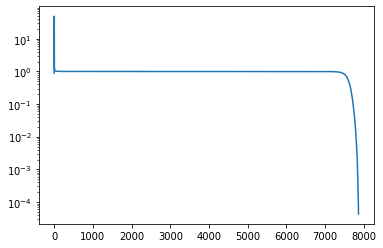

In [117]:
plt.semilogy(np.abs(1.0 / (ee / tau + 1.0)))

In [116]:
iZ2_count = [0]
def apply_iZ2_count(x):
    iZ2_count[0] += 1
    print('iZ2_count[0]=', iZ2_count[0])
    return iZ2 @ x
apply_iZ2_linop = spla.LinearOperator(Hd_pch_dense.shape, matvec=apply_iZ2_count)

iZ2_count[0] = 0
Hr_count[0] = 0
iHr_count[0] = 0
ee5, P5 = spla.eigsh(apply_iZ2_linop, k=6, M=solve_Hr_linop, Minv=apply_Hr_linop, 
                     which='SA', tol=1e-2)
print(ee5)

iZ2_count[0]= 1
iZ2_count[0]= 1
Hr_count[0]= 1
iHr_count[0]= 1
iZ2_count[0]= 2
Hr_count[0]= 2
iHr_count[0]= 2
iHr_count[0]= 3
iZ2_count[0]= 3
Hr_count[0]= 3
iHr_count[0]= 4
iHr_count[0]= 5
iZ2_count[0]= 4
Hr_count[0]= 4
iHr_count[0]= 6
iHr_count[0]= 7
iZ2_count[0]= 5
Hr_count[0]= 5
iHr_count[0]= 8
iHr_count[0]= 9
iZ2_count[0]= 6
Hr_count[0]= 6
iHr_count[0]= 10
iHr_count[0]= 11
iZ2_count[0]= 7
Hr_count[0]= 7
iHr_count[0]= 12
iHr_count[0]= 13
iZ2_count[0]= 8
Hr_count[0]= 8
iHr_count[0]= 14
iZ2_count[0]= 9
Hr_count[0]= 9
iHr_count[0]= 15
iHr_count[0]= 16
iZ2_count[0]= 10
Hr_count[0]= 10
iHr_count[0]= 17
iHr_count[0]= 18
iZ2_count[0]= 11
Hr_count[0]= 11
iHr_count[0]= 19
iHr_count[0]= 20
iZ2_count[0]= 12
Hr_count[0]= 12
iHr_count[0]= 21
iHr_count[0]= 22
iZ2_count[0]= 13
Hr_count[0]= 13
iHr_count[0]= 23
iHr_count[0]= 24
iZ2_count[0]= 14
Hr_count[0]= 14
iHr_count[0]= 25
iHr_count[0]= 26
iZ2_count[0]= 15
Hr_count[0]= 15
iHr_count[0]= 27
iHr_count[0]= 28
iZ2_count[0]= 16
Hr_count[0]= 16
iHr_cou

iZ2_count[0]= 120
Hr_count[0]= 120
iHr_count[0]= 244
iHr_count[0]= 245
iZ2_count[0]= 121
Hr_count[0]= 121
iHr_count[0]= 246
iHr_count[0]= 247
iZ2_count[0]= 122
Hr_count[0]= 122
iHr_count[0]= 248
iHr_count[0]= 249
iZ2_count[0]= 123
Hr_count[0]= 123
iHr_count[0]= 250
iHr_count[0]= 251
iZ2_count[0]= 124
Hr_count[0]= 124
iHr_count[0]= 252
iHr_count[0]= 253
iHr_count[0]= 254
iZ2_count[0]= 125
Hr_count[0]= 125
iHr_count[0]= 255
iZ2_count[0]= 126
Hr_count[0]= 126
iHr_count[0]= 256
iHr_count[0]= 257
iZ2_count[0]= 127
Hr_count[0]= 127
iHr_count[0]= 258
iHr_count[0]= 259
iZ2_count[0]= 128
Hr_count[0]= 128
iHr_count[0]= 260
iHr_count[0]= 261
iZ2_count[0]= 129
Hr_count[0]= 129
iHr_count[0]= 262
iHr_count[0]= 263
iZ2_count[0]= 130
Hr_count[0]= 130
iHr_count[0]= 264
iHr_count[0]= 265
iZ2_count[0]= 131
Hr_count[0]= 131
iHr_count[0]= 266
iHr_count[0]= 267
iZ2_count[0]= 132
Hr_count[0]= 132
iHr_count[0]= 268
iHr_count[0]= 269
iZ2_count[0]= 133
Hr_count[0]= 133
iHr_count[0]= 270
iHr_count[0]= 271
iHr_co

iHr_count[0]= 474
iHr_count[0]= 475
iZ2_count[0]= 236
Hr_count[0]= 236
iHr_count[0]= 476
iHr_count[0]= 477
iZ2_count[0]= 237
Hr_count[0]= 237
iHr_count[0]= 478
iHr_count[0]= 479
iZ2_count[0]= 238
Hr_count[0]= 238
iHr_count[0]= 480
iHr_count[0]= 481
iZ2_count[0]= 239
Hr_count[0]= 239
iHr_count[0]= 482
iHr_count[0]= 483
iZ2_count[0]= 240
Hr_count[0]= 240
iHr_count[0]= 484
iHr_count[0]= 485
iZ2_count[0]= 241
Hr_count[0]= 241
iHr_count[0]= 486
iHr_count[0]= 487
iHr_count[0]= 488
iZ2_count[0]= 242
Hr_count[0]= 242
iHr_count[0]= 489
iZ2_count[0]= 243
Hr_count[0]= 243
iHr_count[0]= 490
iHr_count[0]= 491
iZ2_count[0]= 244
Hr_count[0]= 244
iHr_count[0]= 492
iHr_count[0]= 493
iZ2_count[0]= 245
Hr_count[0]= 245
iHr_count[0]= 494
iHr_count[0]= 495
iZ2_count[0]= 246
Hr_count[0]= 246
iHr_count[0]= 496
iHr_count[0]= 497
iZ2_count[0]= 247
Hr_count[0]= 247
iHr_count[0]= 498
iHr_count[0]= 499
iZ2_count[0]= 248
Hr_count[0]= 248
iHr_count[0]= 500
iHr_count[0]= 501
iZ2_count[0]= 249
Hr_count[0]= 249
iHr_co

iHr_count[0]= 709
iZ2_count[0]= 353
Hr_count[0]= 353
iHr_count[0]= 710
iHr_count[0]= 711
iZ2_count[0]= 354
Hr_count[0]= 354
iHr_count[0]= 712
iHr_count[0]= 713
iZ2_count[0]= 355
Hr_count[0]= 355
iHr_count[0]= 714
iHr_count[0]= 715
iZ2_count[0]= 356
Hr_count[0]= 356
iHr_count[0]= 716
iHr_count[0]= 717
iZ2_count[0]= 357
Hr_count[0]= 357
iHr_count[0]= 718
iHr_count[0]= 719
iZ2_count[0]= 358
Hr_count[0]= 358
iHr_count[0]= 720
iHr_count[0]= 721
iHr_count[0]= 722
iZ2_count[0]= 359
Hr_count[0]= 359
iHr_count[0]= 723
iZ2_count[0]= 360
Hr_count[0]= 360
iHr_count[0]= 724
iHr_count[0]= 725
iZ2_count[0]= 361
Hr_count[0]= 361
iHr_count[0]= 726
iHr_count[0]= 727
iZ2_count[0]= 362
Hr_count[0]= 362
iHr_count[0]= 728
iHr_count[0]= 729
iZ2_count[0]= 363
Hr_count[0]= 363
iHr_count[0]= 730
iHr_count[0]= 731
iZ2_count[0]= 364
Hr_count[0]= 364
iHr_count[0]= 732
iHr_count[0]= 733
iZ2_count[0]= 365
Hr_count[0]= 365
iHr_count[0]= 734
iHr_count[0]= 735
iZ2_count[0]= 366
Hr_count[0]= 366
iHr_count[0]= 736
iHr_co

Hr_count[0]= 468
iHr_count[0]= 940
iHr_count[0]= 941
iZ2_count[0]= 469
Hr_count[0]= 469
iHr_count[0]= 942
iHr_count[0]= 943
iZ2_count[0]= 470
Hr_count[0]= 470
iHr_count[0]= 944
iHr_count[0]= 945
iZ2_count[0]= 471
Hr_count[0]= 471
iHr_count[0]= 946
iHr_count[0]= 947
iZ2_count[0]= 472
Hr_count[0]= 472
iHr_count[0]= 948
iHr_count[0]= 949
iZ2_count[0]= 473
Hr_count[0]= 473
iHr_count[0]= 950
iHr_count[0]= 951
iZ2_count[0]= 474
Hr_count[0]= 474
iHr_count[0]= 952
iHr_count[0]= 953
iZ2_count[0]= 475
Hr_count[0]= 475
iHr_count[0]= 954
iHr_count[0]= 955
iHr_count[0]= 956
iZ2_count[0]= 476
Hr_count[0]= 476
iHr_count[0]= 957
iZ2_count[0]= 477
Hr_count[0]= 477
iHr_count[0]= 958
iHr_count[0]= 959
iZ2_count[0]= 478
Hr_count[0]= 478
iHr_count[0]= 960
iHr_count[0]= 961
iZ2_count[0]= 479
Hr_count[0]= 479
iHr_count[0]= 962
iHr_count[0]= 963
iZ2_count[0]= 480
Hr_count[0]= 480
iHr_count[0]= 964
iHr_count[0]= 965
iZ2_count[0]= 481
Hr_count[0]= 481
iHr_count[0]= 966
iHr_count[0]= 967
iZ2_count[0]= 482
Hr_cou

KeyboardInterrupt: 

In [102]:
(1.0 / (ee + tau))[:6][::-1]

array([ 1.06652068,  1.63892041,  1.84549038,  2.06188014,  3.36427013,
       24.94507974])

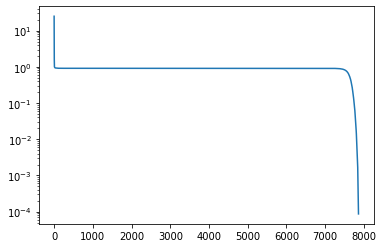

In [103]:
plt.semilogy(1.0 / (ee + tau))

# Find positive definite low rank correction

In [44]:
np.linalg.norm(Hd_pch_dense - Hd_pch_dense.T) / np.linalg.norm(Hd_pch_dense)

3.771267733233928e-10

In [45]:
from localpsf.positive_definite_modifications import bad_eig_correction
# U_bad, ee_bad = bad_eig_correction(Hd_pch_sym.matvec, 
U_bad, ee_bad = bad_eig_correction(lambda x: Hd_pch_dense @ x, 
                                   ADP.apply_Hr_numpy, ADP.solve_Hr_numpy, 
                                   Vh.dim(), tau=0.5,
                                   display=True, chunk_size=1)

computing chunk, chunk_size= 1
eig= -1.0599119341300969 , tau-1.0= -0.5
computing chunk, chunk_size= 1
eig= -0.8027587079599496 , tau-1.0= -0.5
computing chunk, chunk_size= 1
eig= -0.6150057560397761 , tau-1.0= -0.5
computing chunk, chunk_size= 1
eig= -0.5581386006176663 , tau-1.0= -0.5
computing chunk, chunk_size= 1
eig= -0.4898422431946775 , tau-1.0= -0.5


# Build dense Hessian (brute force)

In [18]:
Hd_dense = nhf.build_dense_matrix_from_matvecs(ADP.apply_Hd_numpy,Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [19]:
Hr_dense = nhf.build_dense_matrix_from_matvecs(ADP.apply_Hr_numpy,Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [20]:
from localpsf.positive_definite_modifications import bad_eig_correction

In [ ]:
apply_Hd = lambda x: Hd_dense @ x
apply_Hr = lambda x: Hr_dense @ x
iHr_dense = np.linalg.inv(Hr_dense)
solve_Hr = lambda x: iHr_dense @ x

In [21]:
from localpsf.positive_definite_modifications import bad_eig_correction
U_bad, ee_bad = bad_eig_correction(apply_Hd, apply_Hr, solve_Hr, Vh.dim(), display=True)

computing chunk, chunk_size= 5


KeyboardInterrupt: 

In [23]:
ee, P = sla.eigh(Hd_dense, Hr_dense)

In [24]:
ee

array([-1.22092054e-11, -5.30875199e-12, -4.07909240e-12, ...,
        6.65000715e+03,  9.97789223e+03,  1.18848915e+04])

# Solve for MAP point

In [85]:
def solve_inverse_problem(a_reg):
    H_dense = Hd_dense + a_reg*Hr_dense
    ADP.update_gamma(a_reg)
    g0_numpy = ADP.eval_gradient_numpy(np.zeros(Vh.dim()))
    m_star = np.linalg.solve(H_dense, -g0_numpy)
    return m_star

In [86]:
a_reg_morozov = compute_morozov_regularization_parameter(solve_inverse_problem,
                                                         ADP.compute_morozov_discrepancy,
                                                         ADP.noise_norm,
                                                         a_reg_min=1e-2, a_reg_max=1e2,
                                                         rtol=1e-2)
print('a_reg_morozov=', a_reg_morozov)

Computing regularization parameter via Morozov discrepancy principle
a_reg= 0.010000000000000004 , morozov discrepancy= 0.8441721934420741 , noise level= 0.8794651185039749
a_reg= 100.00000000000004 , morozov discrepancy= 73.84795275012368 , noise level= 0.8794651185039749
a_reg= 0.01088026294879784 , morozov discrepancy= 0.8453012580508893 , noise level= 0.8794651185039749
a_reg= 0.12975485362490843 , morozov discrepancy= 0.9566241038983082 , noise level= 0.8794651185039749
a_reg= 0.024065015555031925 , morozov discrepancy= 0.8599345490481616 , noise level= 0.8794651185039749
a_reg= 0.05462676025304684 , morozov discrepancy= 0.8893974673744619 , noise level= 0.8794651185039749
a_reg= 0.04156441382494203 , morozov discrepancy= 0.8771170359638478 , noise level= 0.8794651185039749
a_reg= 0.04380690580116262 , morozov discrepancy= 0.8792477008708321 , noise level= 0.8794651185039749
a_reg= 0.04449742359191441 , morozov discrepancy= 0.8799016336211211 , noise level= 0.8794651185039749
a_re

a_reg_morozov= 0.04380690580116262 , noise_norm= 0.8794651185039749 , mzd= 0.8792477008708321


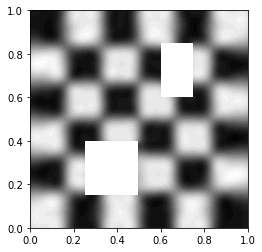

In [87]:
m_star = solve_inverse_problem(a_reg_morozov)
m_MAP = dl.Function(Vh)
m_MAP.vector()[:] = m_star
dl.plot(m_MAP, cmap='gray')

mzd = compute_morozov_discrepancy(m_star)
print('a_reg_morozov=', a_reg_morozov, ', noise_norm=', ADP.noise_norm, ', mzd=', mzd)

In [118]:
del Hd_pch
del Hd_pch_nonsym
del Hd_pch_nonsym_dense

In [120]:
Hd_pch_nonsym.visualize('20nonsym_3')

In [100]:
# Hd_pch = Hd_pch_nonsym.spd(rtol=1e-3)

━━ H-matrix inverse ( rtol =  0.001 , atol =  1e-12 , overwrite= False  )
    done in  35.18794584274292
    size of inverse =  105469305  bytes


In [101]:
# Hd_pch.visualize('20spd_3')

In [158]:
Hd_pch_nonsym_dense = nhf.build_dense_matrix_from_matvecs(Hd_pch_nonsym.matvec, Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [122]:
np.linalg.norm(Hd_pch_nonsym_dense - Hd_dense) / np.linalg.norm(Hd_dense)

0.20260182860558615

In [126]:
rowsums = Hd_pch_nonsym * np.ones(Hd_pch_nonsym.shape[1])

In [124]:
diagonal = Hd_pch_nonsym_dense.diagonal()

In [127]:
print(rowsums)
print(diagonal)

[ 3520.3301259   5286.95797458 13355.34876599 ...  4942.38487223
  7239.82136641  3516.16570009]
[172.71805113   6.61436046 266.50541695 ...   1.66100203 106.56500064
 171.85150445]


In [129]:
H_pch_dense = Hd_pch_nonsym_dense + a_reg_morozov*Hr_dense

In [130]:
H_dense = Hd_dense + a_reg_morozov*Hr_dense

In [131]:
X = np.linalg.solve(H_pch_dense, H_dense)

In [134]:
del Hd_pch_nonsym_dense
del H_pch_dense
del H_dense

In [161]:
emin, vmin = spla.eigsh(Hd_pch_nonsym_dense, which='SA')

In [164]:
mu = -emin[0]
emin

array([-558.44541085, -469.09752385, -425.78797548, -420.69943623,
       -416.32856649, -401.94604667])

In [194]:
ee2 = sla.eigh(Hd_pch_nonsym_dense + a_reg_morozov*Hr_dense, 
              a_reg_morozov*Hr_dense, eigvals_only=True)

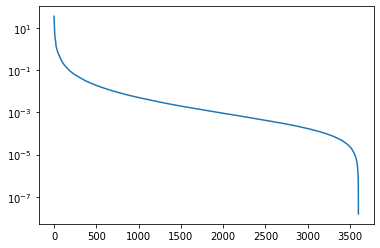

In [225]:
plt.semilogy(1.0 - ee2[ee2 < 1.0])

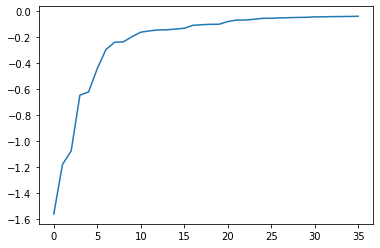

In [193]:
plt.plot(ee[ee < -0.95*a_reg_morozov])

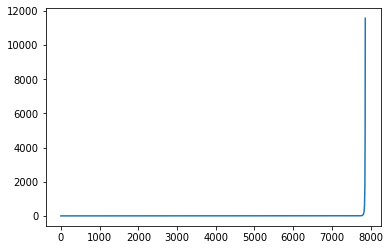

In [215]:
plt.plot(ee)

In [223]:
ee[ee < -0.1*a_reg_morozov]

array([-1.56302959, -1.18265574, -1.07795387, -0.64905631, -0.62427922,
       -0.44524002, -0.29766728, -0.24199773, -0.23900334, -0.19884879,
       -0.16488235, -0.15462834, -0.14739473, -0.14608094, -0.14069036,
       -0.13470314, -0.11174604, -0.10744633, -0.10413242, -0.1036166 ,
       -0.08305149, -0.07119672, -0.07109547, -0.06527973, -0.0581564 ,
       -0.05751036, -0.05470132, -0.05316703, -0.05119439, -0.0504444 ,
       -0.04695811, -0.0465554 , -0.04488735, -0.04441073, -0.04358005,
       -0.04200737, -0.04075502, -0.03896447, -0.03891974, -0.03797977,
       -0.03706449, -0.03433998, -0.03251581, -0.03215629, -0.03065206,
       -0.029963  , -0.0294656 , -0.02842681, -0.02789869, -0.02767249,
       -0.02668833, -0.02562033, -0.02550397, -0.02420545, -0.02384042,
       -0.02336697, -0.02332357, -0.02299137, -0.02263775, -0.02237243,
       -0.02233538, -0.02215113, -0.02209757, -0.02100203, -0.02030951,
       -0.01986541, -0.01893565, -0.01887095, -0.01879591, -0.01

In [219]:
a_reg_morozov

0.04380690580116262

In [ ]:
iH2 = np.linalg.inv(Hd_pch_nonsym_dense + Hr_dense)

In [165]:
H_mu = Hd_pch_nonsym_dense + a_reg_morozov*Hr_dense + mu*np.eye(Vh.dim())

In [166]:
R_mu = a_reg_morozov*Hr_dense + mu*np.eye(Vh.dim())

In [167]:
inv_R_mu = np.linalg.inv(R_mu)

In [170]:
inv_H_mu = np.linalg.inv(H_mu)

In [171]:
R_mu_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=lambda x: R_mu @ x)
inv_R_mu_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=lambda x: inv_R_mu @ x)
inv_H_mu_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=lambda x: inv_H_mu @ x)

In [172]:
emax, vmax = spla.eigsh(inv_H_mu_linop, M=R_mu_linop, Minv=inv_R_mu_linop, which='LA')

In [173]:
emax

array([3.79248468e-06, 3.97165353e-06, 4.08181896e-06, 4.57617195e-06,
       5.12794183e-06, 6.22243470e-06])

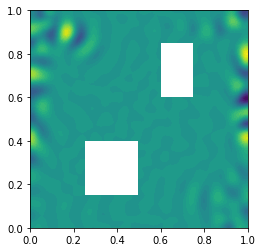

In [185]:
vmax_fct = dl.Function(Vh)
vmax_fct.vector()[:] = vmax[:,0].copy()
dl.plot(vmax_fct)

In [136]:
ee = np.linalg.eigvals(X)

11.211456037820122
0.08718317135256151


array([0.08718317, 0.08718317, 0.11450307, 0.11450307, 0.12400823,
       0.12400823, 0.1292024 , 0.1292024 , 0.14578823, 0.14578823,
       0.150111  , 0.150111  , 0.18408198, 0.18408198, 0.19224438,
       0.1958344 , 0.1958344 , 0.22362596, 0.22362596, 0.29972174,
       0.33310374, 0.33310374, 0.33313302, 0.34451923, 0.34451923,
       0.38149839, 0.39776811, 0.39776811, 0.40307652, 0.40307652,
       0.40382521, 0.40382521, 0.40706831, 0.42449147, 0.42449147,
       0.42488846, 0.42488846, 0.4758122 , 0.4758122 , 0.47608481,
       0.47608481, 0.48090564, 0.48090564, 0.50367586, 0.51022768,
       0.51022768, 0.52317693, 0.52317693, 0.52668407, 0.52668407,
       0.52837952, 0.52837952, 0.5452551 , 0.5452551 , 0.55556038,
       0.55556038, 0.5599229 , 0.5599229 , 0.59273312, 0.59273312,
       0.59589147, 0.59589147, 0.61051577, 0.61051577, 0.62572575,
       0.62572575, 0.63019266, 0.63019266, 0.6376185 , 0.6376185 ,
       0.65740742, 0.66048173, 0.66048173, 0.66280834, 0.66280

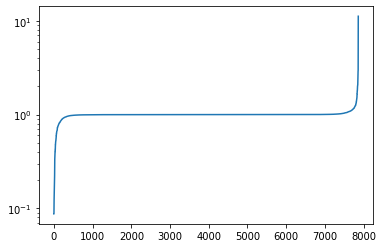

In [155]:
print(np.max(np.abs(ee)))
print(np.min(np.abs(ee)))

inds = np.argsort(np.abs(ee))
plt.semilogy(np.abs(ee[inds]))
np.abs(ee[inds])[:100]

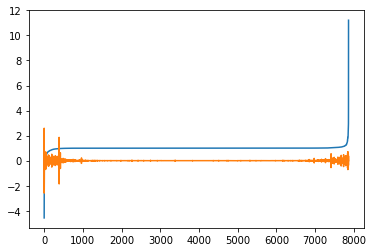

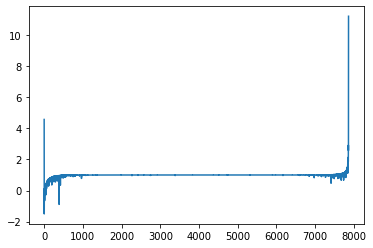

In [145]:
inds = np.argsort(np.real(ee))

plt.plot(np.real(ee[inds]))
plt.plot(np.imag(ee[inds]))

plt.figure()
plt.plot(np.abs(np.real(ee[inds])) - np.abs(np.imag(ee[inds])))

In [ ]:
raise RuntimeError

# Compute spectra

In [ ]:
H_dense = Hd_dense + a_reg_morozov*Hr_dense

evals_REG, evecs_REG = sla.eigh(H_dense, a_reg_morozov*Hr_dense)

Text(0.5, 1.0, 'Regularization preconditioned misfit Hessian eigenvalues')

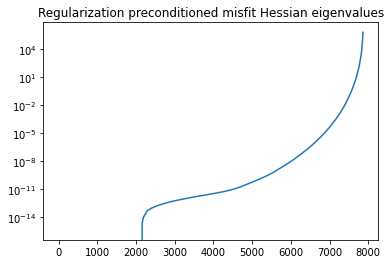

In [36]:
plt.semilogy(evals_REG - 1.0)
plt.title('Regularization preconditioned misfit Hessian eigenvalues')

Text(0.5, 1.0, 'Misfit Hessian eigenvalues')

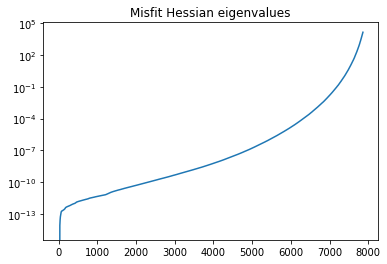

In [26]:
evals_NONE, evecs_NONE = sla.eigh(Hd_dense)

plt.semilogy(evals_NONE)
plt.title('Misfit Hessian eigenvalues')

In [38]:
g0_numpy = eval_gradient(dl.Function(Vh).vector())[:]

H_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=apply_H_numpy)

# p, info = spla.cg(H_linop, -g0)
result_NONE = nhf.custom_cg(H_linop, -g0_numpy, x_true=m_star, maxiter=1000, display=True, tol=1e-13)
p_true = result_NONE[0]

solve_Hr_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=REG.solve_R_numpy)

result_REG = nhf.custom_cg(H_linop, -g0_numpy, x_true=m_star, M=solve_Hr_linop, maxiter=1000, display=True, tol=1e-13)

k=0, res=0.22011206862780225, err=0.5303878188988942
k=1, res=0.11429959996054702, err=0.45971039098509753
k=2, res=0.09350571514161896, err=0.3726397894943674
k=3, res=0.041903936576430253, err=0.336112306614519
k=4, res=0.03293659364723691, err=0.316040538040448
k=5, res=0.024740372249091497, err=0.2938821654911822
k=6, res=0.017602858742378196, err=0.2787574490042068
k=7, res=0.01680398401783641, err=0.26239011172006244
k=8, res=0.012710742198317127, err=0.2485645130424165
k=9, res=0.010122840897826745, err=0.23815244792894832
k=10, res=0.009093714730603912, err=0.22824753701758077
k=11, res=0.008014115549785969, err=0.21813832328727858
k=12, res=0.006827076327233087, err=0.20811654741036523
k=13, res=0.006293604282930342, err=0.1994241613066421
k=14, res=0.0056327453628629825, err=0.1908619023628568
k=15, res=0.004972003537051079, err=0.18255055272438378
k=16, res=0.004228467130800256, err=0.17593802814113627
k=17, res=0.0037955782714567676, err=0.16986517548942545
k=18, res=0.0033

k=145, res=2.7300496833571855e-05, err=0.022783397677928873
k=146, res=2.680299828915723e-05, err=0.022758893963858103
k=147, res=2.5915474064248914e-05, err=0.022736300828015955
k=148, res=2.520439321365707e-05, err=0.02271621642464058
k=149, res=2.489378005502581e-05, err=0.02269959609590298
k=150, res=2.3358758292408336e-05, err=0.022685097785528855
k=151, res=2.1922197184335664e-05, err=0.022669545376922225
k=152, res=2.1129981531304395e-05, err=0.022655014031770736
k=153, res=2.0455723844877056e-05, err=0.022641853926949233
k=154, res=1.8928027736664215e-05, err=0.02263010025737413
k=155, res=1.8008349766100835e-05, err=0.022618947811979578
k=156, res=1.777645448688433e-05, err=0.022608273088491577
k=157, res=1.8030502180827414e-05, err=0.022599091021506836
k=158, res=1.7569026496636686e-05, err=0.022591048003910912
k=159, res=1.657560511805102e-05, err=0.02258235627379933
k=160, res=1.6418925378694426e-05, err=0.022573744250756266
k=161, res=1.6682186205779014e-05, err=0.02256532

k=289, res=6.795878329052777e-07, err=0.022254418926671488
k=290, res=6.290824652218968e-07, err=0.022254113569418785
k=291, res=6.303017657262007e-07, err=0.022253813944973715
k=292, res=6.480494671809097e-07, err=0.02225355162488915
k=293, res=6.22817524006845e-07, err=0.022253336119138066
k=294, res=5.948302186315006e-07, err=0.022253120164839896
k=295, res=5.672212397899054e-07, err=0.022252916730098927
k=296, res=5.846710354178669e-07, err=0.022252737719372813
k=297, res=5.4318853650423e-07, err=0.022252584567961826
k=298, res=5.177646306448246e-07, err=0.022252428776875194
k=299, res=4.860665701372843e-07, err=0.02225229129765721
k=300, res=4.7158503414058877e-07, err=0.02225217398768184
k=301, res=4.6216158954182363e-07, err=0.022252074622360885
k=302, res=4.6189981226066246e-07, err=0.022251990598556533
k=303, res=4.56614086585753e-07, err=0.022251923404877614
k=304, res=4.4103106961833663e-07, err=0.022251869165836758
k=305, res=4.30924170317595e-07, err=0.02225182895790768
k=

k=433, res=1.652204728652128e-08, err=0.022258765736013514
k=434, res=1.5231329534188688e-08, err=0.02225876170710081
k=435, res=1.5040286058178186e-08, err=0.022258757632496743
k=436, res=1.4830691953417436e-08, err=0.022258754316601327
k=437, res=1.4275571125379915e-08, err=0.02225875127710333
k=438, res=1.4359926981031257e-08, err=0.022258748546725597
k=439, res=1.4225169697261592e-08, err=0.022258746186689236
k=440, res=1.377323995830504e-08, err=0.0222587442183038
k=441, res=1.2603473632009933e-08, err=0.02225874230465563
k=442, res=1.3389409110813282e-08, err=0.022258740677218163
k=443, res=1.3052962550373e-08, err=0.022258739502112355
k=444, res=1.192191877017471e-08, err=0.022258738337321386
k=445, res=1.144723443054537e-08, err=0.022258737289507526
k=446, res=1.2034109513807916e-08, err=0.022258736547395897
k=447, res=1.2103935857820404e-08, err=0.02225873611280193
k=448, res=1.0816055043455674e-08, err=0.022258735773151135
k=449, res=1.0212151028492199e-08, err=0.022258735613

k=577, res=3.763320503242552e-10, err=0.022258873773620708
k=578, res=3.9557681842620947e-10, err=0.022258873719803538
k=579, res=3.852116169408738e-10, err=0.022258873662645833
k=580, res=3.501145586673645e-10, err=0.02225887359287811
k=581, res=3.4759246196353035e-10, err=0.022258873514867997
k=582, res=3.5598976634499574e-10, err=0.022258873441582738
k=583, res=3.4442774715192665e-10, err=0.022258873372602506
k=584, res=3.3210952517292067e-10, err=0.022258873302269985
k=585, res=3.132105347178672e-10, err=0.022258873227065913
k=586, res=3.2091396734151175e-10, err=0.02225887315583926
k=587, res=2.909509328380622e-10, err=0.022258873075976512
k=588, res=2.7360389798839903e-10, err=0.02225887298678038
k=589, res=2.6958485833659645e-10, err=0.022258872893000627
k=590, res=2.734390381631885e-10, err=0.02225887280130617
k=591, res=2.772023410099104e-10, err=0.02225887271859291
k=592, res=2.492225340232678e-10, err=0.022258872635364572
k=593, res=2.4284550072209435e-10, err=0.022258872548

k=721, res=4.937182462382682e-12, err=0.02225887100649523
k=722, res=5.437019412408239e-12, err=0.022258871008187665
k=723, res=4.873795408465638e-12, err=0.022258871009527895
k=724, res=4.442990291924518e-12, err=0.022258871011027564
k=725, res=4.1626704254015085e-12, err=0.02225887101252632
k=726, res=4.2472010917372676e-12, err=0.022258871013847336
k=727, res=4.2668760237037836e-12, err=0.02225887101498206
k=728, res=4.2826962021747274e-12, err=0.022258871016039912
k=729, res=4.148873034473681e-12, err=0.022258871017024798
k=730, res=3.9242807818576774e-12, err=0.022258871018074857
k=731, res=3.658872854493904e-12, err=0.022258871019097824
k=732, res=3.5061967385499485e-12, err=0.022258871020051935
k=733, res=3.5607836955115603e-12, err=0.02225887102086087
k=734, res=3.4187546491377975e-12, err=0.022258871021615795
k=735, res=3.1987421738105868e-12, err=0.022258871022332646
k=736, res=3.183089660565198e-12, err=0.022258871022997347
k=737, res=3.1400537705507145e-12, err=0.0222588710

k=1, res=0.1874283829166283, err=0.5959947798965132
k=2, res=0.1785646744062533, err=0.5805555780848972
k=3, res=0.16760177361568918, err=0.551105219091025
k=4, res=0.14694066048639623, err=0.5166097000764649
k=5, res=0.1378218720201258, err=0.4746955525403306
k=6, res=0.11954671534191989, err=0.43426293152811024
k=7, res=0.10035856182483714, err=0.4028279280317846
k=8, res=0.08532902505479235, err=0.37009595502387843
k=9, res=0.0756113575168769, err=0.35096184615448833
k=10, res=0.06851986966528646, err=0.320019664861908
k=11, res=0.06204964566137448, err=0.2887708516774058
k=12, res=0.051817607415415114, err=0.26056824820465796
k=13, res=0.036629460197632184, err=0.2280527950632849
k=14, res=0.031959557834710765, err=0.21391282238800088
k=15, res=0.027723099432414522, err=0.20428876380243333
k=16, res=0.02449608418230133, err=0.19763544530458466
k=17, res=0.02209724300913175, err=0.18966995411697182
k=18, res=0.021500011978082517, err=0.17369659673478063
k=19, res=0.02167272360356947

k=147, res=0.0009071908416508689, err=0.04237421481882954
k=148, res=0.0008811760556378412, err=0.041451767298073434
k=149, res=0.0008592006420007117, err=0.041273581940582095
k=150, res=0.0008060374945646967, err=0.04101726434942664
k=151, res=0.0007973168213388378, err=0.040974726446982565
k=152, res=0.0008118288878212772, err=0.04090999024985462
k=153, res=0.0009183850620889377, err=0.040333044909311125
k=154, res=0.0008672136596605505, err=0.03929638526970944
k=155, res=0.0007630027374811697, err=0.03895558459412921
k=156, res=0.0007539031121973504, err=0.03888289270302018
k=157, res=0.0007595144415734154, err=0.038822255331705476
k=158, res=0.0007644655153634087, err=0.03844993137314086
k=159, res=0.0007695891923155104, err=0.038428831196140614
k=160, res=0.0007659394378982216, err=0.03747404828289586
k=161, res=0.0007221002539727506, err=0.03712585547402601
k=162, res=0.0007874370975839299, err=0.036662613170090445
k=163, res=0.0007599125729388577, err=0.036473051863540155
k=164,

k=290, res=0.0004333386977301782, err=0.01817529115231437
k=291, res=0.0004446444693075523, err=0.018258368916536018
k=292, res=0.0004123147542664712, err=0.018336977816206832
k=293, res=0.0004093603574362469, err=0.018348886682070274
k=294, res=0.0004081219305764031, err=0.01835313837898661
k=295, res=0.0004093545580948996, err=0.018358772802813957
k=296, res=0.0004079656884508394, err=0.01836098715026579
k=297, res=0.00041407018918689884, err=0.018371889902642123
k=298, res=0.0004126313067968049, err=0.018442690459099916
k=299, res=0.00041234406723161056, err=0.01844851428834914
k=300, res=0.000404431330987811, err=0.018501688774498787
k=301, res=0.00040357070720817805, err=0.01853340940118865
k=302, res=0.0003956101072971317, err=0.018551744661483557
k=303, res=0.000395837197150648, err=0.018552156411284142
k=304, res=0.00039772482212039267, err=0.018554607660327446
k=305, res=0.0003985290614214682, err=0.018554640048430295
k=306, res=0.00039517768541977023, err=0.018653191322906992

k=430, res=0.0002476662101337296, err=0.021397232711804434
k=431, res=0.00024823188409803574, err=0.021397621853469707
k=432, res=0.0002482919677260085, err=0.021398008287559347
k=433, res=0.0002507840549274291, err=0.021428931435564885
k=434, res=0.00025113354901643383, err=0.021432652887763453
k=435, res=0.0002528825871450104, err=0.021458044160272135
k=436, res=0.00023458351026326506, err=0.021594025310158922
k=437, res=0.00023372188794151244, err=0.021600883283133317
k=438, res=0.00023181132775875298, err=0.021604843835674244
k=439, res=0.00023354880297595337, err=0.021616030055036192
k=440, res=0.00023140795450206413, err=0.02163018560525123
k=441, res=0.00023342570081584342, err=0.021659934119661866
k=442, res=0.00023246791487205933, err=0.021663584562123493
k=443, res=0.000233492572834453, err=0.02167908690269848
k=444, res=0.00023160936630736072, err=0.02168413236056624
k=445, res=0.0002323727918462577, err=0.02169442922244192
k=446, res=0.000230257397928145, err=0.021699688679

k=572, res=9.686286888414596e-05, err=0.022868625857138065
k=573, res=9.657753735429238e-05, err=0.0228688079555308
k=574, res=9.471206942172706e-05, err=0.022871018943618416
k=575, res=9.307471427059303e-05, err=0.02287163786691855
k=576, res=9.299065460488611e-05, err=0.022871739513861185
k=577, res=9.209211930974776e-05, err=0.022871981392064117
k=578, res=9.19298740928824e-05, err=0.022871963812251622
k=579, res=9.207066593064126e-05, err=0.02287221425762266
k=580, res=9.044563217264333e-05, err=0.022872172015072762
k=581, res=9.038222918487801e-05, err=0.022872136872904847
k=582, res=9.215270381967856e-05, err=0.022871536636645217
k=583, res=9.189820204612939e-05, err=0.022871782401353798
k=584, res=9.19370991426578e-05, err=0.022872326206513645
k=585, res=8.737251074753792e-05, err=0.022875083516551268
k=586, res=8.776750328106591e-05, err=0.022875580131982844
k=587, res=8.801997549678246e-05, err=0.022876086242935856
k=588, res=8.562071149941727e-05, err=0.022878459560844555
k=5

k=713, res=3.318135606786815e-05, err=0.022620859462656517
k=714, res=3.115532115288609e-05, err=0.022616605179744335
k=715, res=3.030177558488953e-05, err=0.022615899175223275
k=716, res=3.0799616978044034e-05, err=0.022614734280961248
k=717, res=3.106010963184463e-05, err=0.022611337419496096
k=718, res=2.8687607781784802e-05, err=0.022598149325092635
k=719, res=2.8289497354984487e-05, err=0.02259780352174065
k=720, res=2.8471630257253073e-05, err=0.022597230536795403
k=721, res=2.744830148687039e-05, err=0.022593408224785318
k=722, res=2.732795901681921e-05, err=0.022593236147403918
k=723, res=2.7276125262915604e-05, err=0.022592033490033785
k=724, res=2.6545656471837378e-05, err=0.022590906403046188
k=725, res=2.6542595477724304e-05, err=0.022590878682818706
k=726, res=2.712448388096409e-05, err=0.022588492633132833
k=727, res=2.689592519829052e-05, err=0.022586442791441317
k=728, res=2.8131222412359155e-05, err=0.02258023408041992
k=729, res=2.8408355932829047e-05, err=0.022578665

k=854, res=7.370935844883351e-06, err=0.0223892831528608
k=855, res=7.366524180392909e-06, err=0.022389251702495058
k=856, res=7.518447308455092e-06, err=0.022388957975783413
k=857, res=7.133745293939802e-06, err=0.022387094810538476
k=858, res=7.117227656532447e-06, err=0.02238705070640442
k=859, res=7.212695082278295e-06, err=0.022386489178592026
k=860, res=7.2446476823488505e-06, err=0.022386233765028487
k=861, res=7.257666658541177e-06, err=0.022385755531516043
k=862, res=7.123592892140804e-06, err=0.022385621366631338
k=863, res=7.077930181742226e-06, err=0.022385531926236824
k=864, res=7.113179520782193e-06, err=0.022385474555690805
k=865, res=7.2914850354688594e-06, err=0.022385230043818614
k=866, res=7.076867416265392e-06, err=0.022384189368282775
k=867, res=7.093936452160231e-06, err=0.02238416347788695
k=868, res=7.122343989114892e-06, err=0.022374981428728537
k=869, res=7.020692899091214e-06, err=0.02237468707611896
k=870, res=6.627924754581039e-06, err=0.022374016404113167


k=995, res=2.3467960512525716e-06, err=0.02229781923463853
k=996, res=2.3550736386855863e-06, err=0.022297744135457098
k=997, res=2.322563093478403e-06, err=0.022297620143193125
k=998, res=2.2621822624391416e-06, err=0.022297145207637155
k=999, res=2.328705533131494e-06, err=0.022297032214198893


NameError: name 'result' is not defined

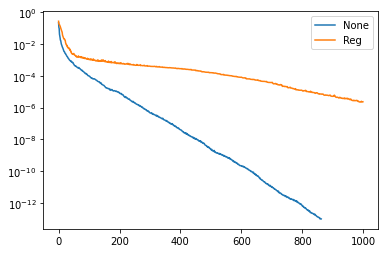

In [43]:
plt.semilogy(result_NONE[2])
plt.semilogy(result_REG[2])
plt.legend(['None', 'Reg'])

## 8. The Gaussian posterior

In [ ]:
k = 150
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, fake_prior.R, fake_prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( fake_prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

## 9. Compute the MAP point

In [ ]:
H.misfit_only = False

[u,m,p] = problem.generate_vector()

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(m, -mg)
problem.solveFwd(u, [u,m,p])
 
total_cost, reg_cost, misfit_cost = problem.cost([u,m,p])
print( "Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost) )
    
posterior.mean = m

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, m), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")

## 10. Prior and posterior pointwise variance fields

In [ ]:
compute_trace = False
# compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()

## 11. Draw samples from the prior and posterior distributions

In [ ]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + fake_prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + fake_prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    parRandom.normal(1., noise)
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019-2020, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.

In [ ]:
H.misfit_only = True

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
x_fct.vector()[:] = np.random.randn(Vh.dim())
H.mult(x_fct.vector(), y_fct.vector())

cm = dl.plot(x_fct)
plt.colorbar(cm)
plt.title('x')

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 500
# k = 1000

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

cm = dl.plot(x_fct)
plt.colorbar(cm)
plt.title('x')

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = 500
k = 1000

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 1002

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 4300

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [2]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 5710

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

NameError: name 'dl' is not defined

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 6610

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(0.75*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
# M_solver.solve(y_fct.vector(), y_dual_vec)
y_fct.vector()[:] = y_dual_vec

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

y_dual_vec = dl.Function(Vh).vector()

x_fct.vector()[:] = 1.0

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)
# y_fct.vector()[:] = y_dual_vec

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
# raise RuntimeError('Stop here')

In [3]:
# from nalger_helper_functions import *

import hlibpro_python_wrapper as hpro
from localpsf.product_convolution_kernel import ProductConvolutionKernel
from localpsf.product_convolution_hmatrix import make_hmatrix_from_kernel

ImportError: initialization failed

In [ ]:
def apply_misfit_gauss_newton_hessian_petsc(x_petsc): # Hd_gn * x = y
    H.misfit_only = True
    y_petsc = dl.Function(Vh).vector()
    H.mult(x_petsc, y_petsc)
    return y_petsc

num_batches = 20
tau = 3.0
num_neighbors = 10

PCK = ProductConvolutionKernel(Vh, Vh, 
                               apply_misfit_gauss_newton_hessian_petsc, 
                               apply_misfit_gauss_newton_hessian_petsc,
                               num_batches, num_batches,
                               tau_rows=tau, tau_cols=tau,
                               num_neighbors_rows=num_neighbors,
                               num_neighbors_cols=num_neighbors)

In [ ]:
for k in range(PCK.col_batches.num_batches):
    PCK.col_batches.visualize_impulse_response_batch(k)

hmatrix_tol=1e-6
Hd_pch_nonsym, extras = make_hmatrix_from_kernel(PCK, hmatrix_tol=hmatrix_tol)
# Hd_pch = Hd_pch_nonsym.spd()

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch_nonsym * x_fct.vector()[:]
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
Hd_pch = Hd_pch_nonsym.spd(rtol=1e-6,k=2,a_factor=2)

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch.matvec(x_fct.vector()[:])
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')

sum_true = np.sum(y_fct.vector()[:])
sum_pch = np.sum(y_fct_pch.vector()[:])
print('sum_true=', sum_true, ', sum_pch=', sum_pch, ', sum_true/sum_pch=', sum_true/sum_pch)

In [ ]:
raise RuntimeError

In [ ]:
# from tqdm.auto import tqdm

# Hdense = np.zeros((Vh.dim(), Vh.dim()))
# for k in tqdm(range(Hdense.shape[1])):
#     ek = np.zeros(Vh.dim())
#     ek[k] = 1.0
#     Hdense[:,k] = Hd_pch_nonsym * ek

In [ ]:
# Hdense_sym = 0.5*(Hdense + Hdense.T)

In [ ]:
# ee, P = np.linalg.eigh(Hdense_sym)

In [ ]:
# plt.plot(ee)

# plt.figure()
# plt.plot(ee[:100])

In [ ]:
# # Hdense_plus = np.dot(P, np.dot(np.diag(np.abs(ee)), np.linalg.inv(P)))
# Hdense_plus = np.dot(P, np.dot(np.diag(ee*(ee>0)), np.linalg.inv(P)))

In [ ]:
# M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
# M_solver = dl.LUSolver(M)

# # k = int(np.random.rand()*Vh.dim())
# # k = good_inds[int(np.random.rand()*len(good_inds))]

# p = np.random.rand(2)
# # p = np.array([0., 1.])
# # p = np.array([0.5, 0.5])
# # p = p + [0.05, -0.05]
# # p = p + [-0.05, 0.0]
# k = dof_kdt.query(p)[1]

# x_dual_vec = dl.Function(Vh).vector()
# y_dual_vec = dl.Function(Vh).vector()

# x_dual_vec[k] = 1.0

# x_fct = dl.Function(Vh)
# y_fct = dl.Function(Vh)
# y_fct_pch = dl.Function(Vh)
# y_fct_plus = dl.Function(Vh)

# # M_solver.solve(x_fct.vector(), x_dual_vec)
# x_fct.vector()[:] = x_dual_vec

# H.misfit_only = True
# H.mult(x_fct.vector(), y_fct.vector())
# y_fct_plus.vector()[:] = Hdense_plus @ x_fct.vector()[:]
# y_fct_pch.vector()[:] = Hd_pch_nonsym * x_fct.vector()[:]
# # M_solver.solve(y_fct.vector(), y_dual_vec)


# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# cm = dl.plot(y_fct)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# # plt.plot(targets[:,0], targets[:,1], '.r')

# plt.subplot(1,3,2)
# cm = dl.plot(y_fct_pch)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')

# plt.subplot(1,3,3)
# cm = dl.plot(y_fct_plus)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
Hd_pch_nonsym.visualize('adv_nonsym2')

In [ ]:
Hd_pch_sym = Hd_pch_nonsym.sym()

In [ ]:
Hd_pch_sym.visualize('adv_sym2')

In [ ]:
ee_SA, _ = spla.eigsh(Hd_pch_sym.as_linear_operator(), k=1, which='SA')
lambda_min = np.min(ee_SA)

In [ ]:
lambda_min

In [ ]:
a_factor=2.0
b_factor=0.0
k=1

a = a_factor * lambda_min
b = b_factor * lambda_min

scaling_at_lambda_min = 1. / (1.0 + ((2.0*lambda_min - (b + a)) / (b - a)) ** (2 ** k))
print('scaling_at_lambda_min=', scaling_at_lambda_min)

scaling_at_zero = 1. / (1.0 + (-(b+a)/(b-a))**(2**k))
print('scaling_at_zero=', scaling_at_zero)

In [ ]:
T = Hd_pch_sym.copy()
T = (T * 2.0).add_identity(s=-(b + a)) * (1.0 / (b - a))

In [ ]:
T.visualize('T0')

In [ ]:
T1 = hpro.h_mul(T, T, rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
T1.visualize('T1')

In [ ]:
T1 = T1.sym()
T1.visualize('T1 (sym)')

In [ ]:
T1b = T1.add_identity()

In [ ]:
iT1b = T1b.factorized_inverse(rtol=1e-6, atol=1e-10)

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch_sym.matvec(x_fct.vector()[:] - 2.0 * iT1b.matvec( x_fct.vector()[:]))
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
raise RuntimeError

In [ ]:
raise RuntimeError

In [ ]:
raise RuntimeError

In [ ]:
iT1b = T1b.inv(rtol=1e-6, atol=1e-10)

In [ ]:
raise RuntimeError

In [ ]:
iHHH = Hd_pch_sym.add_identity(s=3000.0).inv(rtol=1e-6,atol=1e-10,display_progress=False)

In [ ]:
inv_options = hpro.hpro_cpp.fac_options_t()

In [ ]:
cpp_diag_type = hpro.hpro_cpp.diag_type_t.general_diag
cpp_storage_type = hpro.hpro_cpp.storage_type_t.store_normal
do_coarsen=False

In [ ]:
inv_options = hpro.hpro_cpp.inv_options_t(cpp_diag_type, cpp_storage_type, do_coarsen, None)

In [ ]:
acc = hpro.hpro_cpp.TTruncAcc(relative_eps=1e-6, absolute_eps=1e-10)

In [ ]:
inverse_cpp_object = hpro.hpro_cpp.copy_TMatrix(Hd_pch_sym.add_identity(s=3000.0).cpp_object)

In [ ]:
hpro.hpro_cpp.invert_h_matrix(inverse_cpp_object, acc, inv_options)

In [ ]:
raise RuntimeError

In [ ]:
ee_T1b, _ = spla.eigsh(T1b.as_linear_operator(), k=1, which='LA')
lambda_max_T1b = np.max(ee_T1b)
print('lambda_max_T1b=', lambda_max_T1b)

In [ ]:
ee_T1b, _ = spla.eigsh(T1b.as_linear_operator(), k=1, which='SA')
lambda_min_T1b = np.min(ee_T1b)
print('lambda_min_T1b=', lambda_min_T1b)

In [ ]:
# Schulz iteration
rtol=1e-6
atol=1e-10

A = T1b * (1./(2*lambda_max_T1b))
X = A

In [ ]:
Z1 = hpro.h_mul(A, X, rtol=rtol, atol=atol, display_progress=True)

In [ ]:
Z2 = ((-1.0)*Z1).add_identity(s=2.0)

In [ ]:
Z3 = hpro.h_mul(X, Z2, rtol=rtol, atol=atol, display_progress=True)

In [ ]:
x = np.random.randn(Z3.shape[1])
x2 = Z3 * (A * x)

In [ ]:
x

In [ ]:
x2

In [ ]:
plt.plot(x)
plt.plot(x2)

In [ ]:
raise RuntimeError

In [ ]:
Pi_minus = T1b.sym().inv(rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
raise RuntimeError

In [ ]:
Pi_minus = T1.add_identity(s=10.0).inv(rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
3

In [ ]:
Hd_pch_deflated = hpro.rational_positive_definite_approximation_low_rank_method(Hd_pch_nonsym, cutoff=-500.0,
                                                         block_size=20,
                                                         max_rank=500,
                                                         display=True,
                                                         overwrite=False,
                                                         rtol=1e-6,
                                                         atol=1e-12)

In [ ]:
Vh.dim()

In [ ]:
Hd_pch_deflated.spd(rtol=1e-5, k=1)